In [1]:
#version stable on 230329

In [2]:
abra='/Users/rockwell/Code/peroseq/'

In [ ]:
#always
import os
#abra='/Users/rockwell/Code/peroseq/'
#os.chdir(abra)
         
#global variables
'''
strain='long_and_ont_s1'
results_file = '/Users/rockwell/Code/220323_LONG_AND_ONT/'
pc_scores='/Users/rockwell/Code/220323_LONG_AND_ONT/_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/Users/rockwell/Code/220323_LONG_AND_ONT/220323_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/Users/rockwell/Code/220323_LONG_AND_ONT/220323_long_ont_model_robust_s1.p'
'''

strain='/n/groups/datta/Dana/new_figs/'
pc_scores='/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_pca/pca_scores.h5'
#get this index file by generating/copying from oringal locatoin
index_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_and_ont_moseq6-index.yaml'
#model_file = '/Users/rockwell/Code/210610_reconstructed_results/210610_longtogeny_model3_tar.p'
model_file = '/n/groups/datta/rockwell/k2_data_gen3/longtogeny/LONG_AND_ONT/220415_long_ont_model_robust_s1.p'


use_post_hoc_sort=False
use_all_frames=False
n_frames_to_use=20000
max_syllable=80
n_training_mice=.93 #percent of mice to be used for training
n_syllables_to_plot=90

data_loc=strain+'_data'
try:
    os.mkdir(data_loc)
except FileExistsError:
    # directory already exists
    pass

os.chdir(data_loc)

In [ ]:
#standard library imports
import pylab
import copy
from sklearn.manifold import TSNE
import h5py
import scipy
import datetime
import math
import cmasher as cmr
seqmatcolor='Purples_r'
divmatcolor=cmr.watermelon_r
from matplotlib.lines import Line2D
from matplotlib_venn import venn3
from scipy import linalg as LA
import glob
import yaml
from scipy.stats import linregress
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.datasets import make_blobs
import pandas as pd
from collections import Counter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(123456)
import pickle
import seaborn as sns
from scipy.spatial.distance import squareform
import warnings
import matplotlib
import matplotlib.pyplot as plt
from importlib import reload
plt=reload(plt)
warnings.filterwarnings("ignore", category=DeprecationWarning) 
%matplotlib inline

In [ ]:
#moseq imports
from moseq2_viz.model.util import parse_model_results
from moseq2_viz.util import parse_index
from moseq2_viz.scalars.util import scalars_to_dataframe
from moseq2_viz.model.dist import get_behavioral_distance

# Behavioral Distance Dependencies
from scipy.cluster.hierarchy import linkage, dendrogram

# Transition Matrices Compute/Graphing Dependencies
from moseq2_viz.model.util import parse_model_results, relabel_by_usage
from moseq2_viz.model.trans_graph import get_trans_graph_groups, get_group_trans_mats

In [ ]:
ontogeny_color_mat=['gold',
           'orange',
           (228/255, 104/255, 42/255),
           'red',
           (192/255, 70/255, 96/255),
           (129/255, 40/255, 120/255),
           'indigo',
           (13/255, 35/255, 20/255)]

In [ ]:
'cool color map discretized'

ontogeny_color_mat2=([[0.        , 1.        , 1.        , 1.        ],
       [0.15686275, 0.84313725, 1.        , 1.        ],
       [0.31372549, 0.68627451, 1.        , 1.        ],
       [0.47058824, 0.52941176, 1.        , 1.        ],
       [0.62745098, 0.37254902, 1.        , 1.        ],
       [0.78431373, 0.21568627, 1.        , 1.        ],
       [0.94117647, 0.05882353, 1.        , 1.        ],
       [1.        , 0.        , 1.        , 1.        ]])


ontogeny_color_mat2_hex=[]
for n in ontogeny_color_mat2:
    ontogeny_color_mat2_hex.append(matplotlib.colors.rgb2hex(n))
    


In [ ]:
sns_palette_ontogeny = sns.color_palette(ontogeny_color_mat2_hex)

# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# FUNCTIONS
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
def subset_label_counts(counts,uuids_conditions,condition):
    m=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(counts[i])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(counts[i])
    return np.array(m)

In [ ]:
def subset_labels(labels,uuids_conditions,condition):
    m=[]
    u=[]
    for i in range(len(uuids_conditions)):
        if str(uuids_conditions[i][1])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[0:2] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
        if str(uuids_conditions[i][2])[17:19] == condition:
            m.append(labels[i])
            u.append(uuids_conditions[i][0])
    return np.array(m),u


In [ ]:
def labels_and_scalars(labels,results_file,uuids_conditions,a_scalar='velocity_2d_mm',condition='12'):
    ljm,bhj=get_subsetted_scalars(a_scalar,condition,uuids_conditions,results_file)
    gerf,onon=subset_labels(labels,uuids_conditions,condition)
    da_real=[]
    for n in onon:
        #print(bhj.index(n))
        da_real.append(bhj.index(n))
    return gerf, np.array(ljm)[da_real], onon

In [ ]:
def normalize(a):
    norm_a=a/(np.max(a)-np.min(a))
    norm_a=a/(np.max(a)-np.min(a)) 
    return(norm_a)


In [ ]:
fig,ax=plt.subplots()
def plot_size_corr(l,s,syllable=0,color='black',ax=ax):
    hjkjkg=[]
    gbfgbfdfd=[]
    
    for i in range(len(l)):
        if sum(l[i]==syllable) != 0:
            try:

                hjkjkg.append(  sum(l[i]==syllable) /  sum(l[i]>-4)   )
                gbfgbfdfd.append(np.nanmedian(s[i]))
            except:
                pass
    
    #x=weight y=usage
    ax.scatter(gbfgbfdfd,hjkjkg,color=color) 
    idxpp = np.isfinite(hjkjkg) & np.isfinite(gbfgbfdfd)
    
    z = np.polyfit(gbfgbfdfd,hjkjkg,  1)
    p = np.poly1d(z)
    ax.plot(gbfgbfdfd,p(gbfgbfdfd),color=color,linestyle='--')

In [ ]:
def get_subsetted_scalars(a_scalar,condition,uuids_conditions,directory):
    
    #accessing scalar data from results files
    here=os.getcwd()
    os.chdir(directory) #if the directory contains the session folders directly then you dont need the */ in front of session in the glob.glob below

    result_h5_files=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.h5"):
        result_h5_files.append(file)
        #print(file)


    result_h5_uuid=[] #create an empty matrix that will contain the addresses of the result files
    for file in glob.glob("*/session*/proc/*.yaml"):
        with open(file) as f:
            y=yaml.load(f)
            ido=y['uuid']
            result_h5_uuid.append(ido)
            #print(id)
        f.close()
    f.close()


    scalar=[]
    associated_uuid=[]
    i=0
    j=0
    for u in result_h5_uuid:
        for uc in uuids_conditions:
            if u == uc[0]:
                if str(uc[1])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[0:2] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)

                if str(uc[2])[17:19] == condition:
                    results_h5_data = h5py.File(result_h5_files[i], 'r+')
                    x=results_h5_data['scalars'][a_scalar]
                    scalar.append(np.array(x))
                    associated_uuid.append(u)
            j=j+1
        i=i+1
        j=0
    os.chdir(here)
    return scalar,associated_uuid

In [ ]:
def pca_on_np_array(nparray):
    '''rows are members (mice), columns are variables (syllables)'''
    nparray -= np.mean(nparray, axis = 0)  
    #calculate covariance matrix
    cov = np.cov(nparray, rowvar = False)
    #get eigenvectors and eigenvalues
    evals , evecs = LA.eigh(cov)

    #formatting and SORT by eigenvalues (aka sort by how much variance each eigen vector explains)
    idx = np.argsort(evals)[::-1]
    evecs = evecs[:,idx]
    evals = evals[idx]

    #this is your data represented as PCS 
    nparray_represented_as_pcs = np.dot(nparray, evecs)
    
    return nparray_represented_as_pcs,evecs,evals

In [ ]:
def trans_mat_diff(trans_mats,tm1,tm2):

    #normalize both input matrices
    tma=trans_mats[tm1]/(np.max(trans_mats[tm1])-np.min(trans_mats[tm1]))
    tmb=trans_mats[tm2]/(np.max(trans_mats[tm2])-np.min(trans_mats[tm2]))

    tmdiff=np.subtract(tmb,tma)
    
    return tmdiff

In [ ]:
def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)

In [ ]:
def counttrigram(ooga,cutoff):
    n=3
    gram_mat=np.zeros(([100]*n))
    i=ooga[2]
    j=ooga[3]
    k=ooga[4]
    for c in range(3,len(ooga)-2):
        if ooga[c] != -5 and ooga[c+1] != -5 and ooga[c+2] != -5:
            if ooga[c] < cutoff and ooga[c+1] < cutoff and ooga[c+2] < cutoff:  
                i=ooga[c]
                j=ooga[c+1]
                k=ooga[c+2]
                gram_mat[i][j][k]=gram_mat[i][j][k]+1

    return gram_mat
    

In [ ]:
def plot_a_syllable(s,s_description='',legend=False):

    from matplotlib.lines import Line2D
    custom_lines = [Line2D([0], [0], color=color_mat[0], lw=4),
                    Line2D([0], [0], color=color_mat[1], lw=4),
                    Line2D([0], [0], color=color_mat[2], lw=4),
                    Line2D([0], [0], color=color_mat[3], lw=4),
                    Line2D([0], [0], color=color_mat[4], lw=4),
                    Line2D([0], [0], color=color_mat[5], lw=4),
                    Line2D([0], [0], color=color_mat[6], lw=4),
                    Line2D([0], [0], color=color_mat[7], lw=4)]


    fig, ax = plt.subplots()
    fig.set_size_inches(3,8)
    plt.title(s_description,fontsize=17)
    a=sns.pointplot(data=frequencies[0][:,s],ax=ax,label=cohort_labels[0],linestyles='',markersize=5,color=color_mat[0])
    b=sns.pointplot(data=frequencies[1][:,s],ax=ax,label=cohort_labels[1],linestyles='',markersize=5,color=color_mat[1])
    c=sns.pointplot(data=frequencies[2][:,s],ax=ax,label=cohort_labels[2],linestyles='',markersize=5,color=color_mat[2])
    d=sns.pointplot(data=frequencies[3][:,s],ax=ax,label=cohort_labels[3],linestyles='',markersize=5,color=color_mat[3])
    e=sns.pointplot(data=frequencies[4][:,s],ax=ax,label=cohort_labels[4],linestyles='',markersize=5,color=color_mat[4])
    f=sns.pointplot(data=frequencies[5][:,s],ax=ax,label=cohort_labels[5],linestyles='',markersize=5,color=color_mat[5])
    g=sns.pointplot(data=frequencies[6][:,s],ax=ax,label=cohort_labels[6],linestyles='',markersize=5,color=color_mat[6])
    h=sns.pointplot(data=frequencies[7][:,s],ax=ax,label=cohort_labels[7],linestyles='',markersize=5,color=color_mat[7])

    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_xticks([])
    #ax.set_xlim([-1,(max_syllable-.5)])
    if legend:
        plt.legend(handles=custom_lines,labels=cohort_labels,bbox_to_anchor=(1.05, 1),loc='upper left')

    plt.xlabel('Syllable_' + str(s),fontsize=17)
    plt.ylabel('Frequency',fontsize=17)
    fig.patch.set_facecolor('white')
    plt.show()
    fig.savefig(strain + ' Syllable_' + str(s) +  '_Distribution.pdf', bbox_inches='tight')
    fig.savefig(strain + ' Syllable_' + str(s) +  '_Distribution.png', bbox_inches='tight')

In [ ]:
def get_best_nmf(datamat,uptoncomps=10,restarts=10,save=False,title='nmf_performance',howtocalc='use_sum'):
    from sklearn.decomposition import NMF
    import scipy.cluster.hierarchy as hc
    from numpy import inf
    from sklearn.cluster import KMeans
    from sklearn.metrics import silhouette_score
    Hs=[]
    for c in range(2,uptoncomps):
        Hn=[]
        for r in range(restarts):    
            model = NMF(n_components=c, init='random', random_state=r)
            W = model.fit_transform(datamat)
            H = model.components_
            Hn.append(H)
        Hs.append(Hn)
        
    fig, ax = plt.subplots(1,uptoncomps-2) 
    fig.set_size_inches((uptoncomps-2)*4,(uptoncomps-2))
    
    
    for hhh in range(len(Hs)):
        
        wrf=np.zeros((restarts,restarts))
        for i in range(len(Hs[0])):
            for j in range(restarts):
                for k in range(restarts):
                    if howtocalc=='use_sum':
                        corrrr=np.corrcoef(x=np.sum(Hs[hhh][j],axis=0),y=np.sum(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_var':
                        corrrr=np.corrcoef(x=np.var(Hs[hhh][j],axis=0),y=np.var(Hs[hhh][k],axis=0)) 
                    if howtocalc=='use_entropy':
                        try:
                            corrrr=scipy.stats.entropy(pk=Hs[hhh][j],qk=Hs[hhh][k],axis=0)
                            corrrr[corrrr == inf] = 1
                        except:
                            corrrr=0
                    #print(np.mean(corrrr))
                    if howtocalc != 'use_entropy':
                        wrf[j][k]=corrrr[0,1]
                    if howtocalc == 'use_entropy':
                        wrf[j][k]=np.nanmedian(corrrr)

        ax[hhh].set_xticks([]) 
        ax[hhh].set_yticks([])    
        #ax[hhh].imshow(wrf,cmap='gray',vmin=0, vmax=1)
        
        #sns.clustermap(wrf,cmap='gray',vmin=0, vmax=1,ax=ax[hhh])

        
        d=pd.DataFrame(wrf)
        link = hc.linkage(d.values, method='centroid')
        o1 = hc.leaves_list(link)
        mat = d.iloc[o1,:]
        mat = mat.iloc[:, o1[::-1]]
        ax[hhh].imshow(mat,cmap='gist_earth',vmin=0, vmax=1)
        
        kmeans = KMeans(init="random",n_clusters=3,n_init=10,max_iter=300,random_state=28)
        kmeans.fit(wrf)
        score = silhouette_score(wrf, kmeans.labels_)
        
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(np.mean(wrf))[0:5] + ')')#use entopy of values to determine best "cluster"
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(scipy.stats.entropy(wrf))[0:5] + ')')
        ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(kmeans.inertia_)[0:5] + ')') #use kmeans inertia
        #ax[hhh].set_title(str(hhh+2)+ ' groups (' + str(score)[0:5] + ')') #use kmeans silhoutte scores
        
        
    fraction = .04  # .05
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    cbar = ax[hhh].figure.colorbar(
    mpl.cm.ScalarMappable(norm=norm, cmap='gist_earth'),
    ax=ax[hhh], pad=0, fraction=fraction)
    fig.patch.set_facecolor('white')

    plt.show()
    
    if save:
        fig.savefig((title)+".pdf",  bbox_inches='tight')
        fig.savefig((title)+".png",  bbox_inches='tight')
        
    return Hs

In [ ]:
def wrapping_slice(lst, *args):
    return [lst[i%len(lst)] for i in range(*args)]

def return_confusion(predictions):
    cnf_mat=np.zeros((len(predictions),len(predictions)))
    for i in range(len(predictions)):
        for j in range(len(predictions)):
            cnf_mat[i,j]=np.count_nonzero(predictions[i]==j) / len(predictions[i])
    return cnf_mat

In [ ]:
#can chance based on number of pcs
def contribution_of_each_syllable_to_distance(nparray1,nparray2,npcs=10):
    pcs,eigenvectors,eigenvalues=pca_on_np_array(np.concatenate((nparray1,nparray2),axis=0))

    n_mice1=len(nparray1)
    n_mice2=len(nparray2)
    n_syllables=len(nparray1[0])

    #get the mean pc scores for each group
    group1_mean_pcs=np.mean(pcs[0:(n_mice1-1)],axis=0)
    group2_mean_pcs=np.mean(pcs[n_mice1:((n_mice1+n_mice2)-1)],axis=0)
    #calculate the absolute pairwise difference between pcs and divide by the sum 
    difference=np.abs(np.subtract(group1_mean_pcs,group2_mean_pcs))
    square_difference=np.square(difference)
    sum_of_square_difference=sum(square_difference)
    weighted_difference=square_difference/sum_of_square_difference

    #calculate how much each syllable contributes to each eigenvector and ultimately the distance between groups
    contribution_of_each_syllable=np.zeros((n_syllables,n_syllables),dtype=float)
    for i in range(n_syllables):
        pc_i_contribution_to_all_syllables=weighted_difference[i]*np.square(eigenvectors[:,i])*((eigenvalues[i]**2/sum(eigenvalues**2)))
        contribution_of_each_syllable[i,:]=pc_i_contribution_to_all_syllables
    
    contribution_of_each_syllable=sum(contribution_of_each_syllable[0:npcs])/sum(sum(contribution_of_each_syllable)[0:npcs])
    
    return contribution_of_each_syllable

In [ ]:
def plot_scalars(results_file,scalar_of_interest,ylim=False):
    ''' angle
        area_mm
        area_px
        centroid_x_mm
        centroid_x_px
        centroid_y_mm
        centroid_y_px
        height_ave_mm
        length_mm
        length_px
        velocity_2d_mm
        velocity_2d_px
        velocity_3d_mm
        velocity_3d_px
        velocity_theta
        width_mm
        width_px'''
    vel2d_03w,uuid_03w=get_subsetted_scalars(scalar_of_interest,'03',uuids_conditions,results_file)
    vel2d_05w,uuid_05w=get_subsetted_scalars(scalar_of_interest,'05',uuids_conditions,results_file)
    vel2d_07w,uuid_07w=get_subsetted_scalars(scalar_of_interest,'07',uuids_conditions,results_file)
    vel2d_09w,uuid_09w=get_subsetted_scalars(scalar_of_interest,'90',uuids_conditions,results_file)
    vel2d_03m,uuid_03m=get_subsetted_scalars(scalar_of_interest,'3m',uuids_conditions,results_file)
    vel2d_06m,uuid_06m=get_subsetted_scalars(scalar_of_interest,'6m',uuids_conditions,results_file)
    vel2d_12m,uuid_12m=get_subsetted_scalars(scalar_of_interest,'12',uuids_conditions,results_file)
    vel2d_18m,uuid_18m=get_subsetted_scalars(scalar_of_interest,'18',uuids_conditions,results_file)

    a_scalar_means_03w=[]
    for i in range(len(vel2d_03w)):
        a_scalar_means_03w.append(np.nanmean(vel2d_03w[i]))

    a_scalar_means_05w=[]
    for i in range(len(vel2d_05w)):
        a_scalar_means_05w.append(np.nanmean(vel2d_05w[i]))

    a_scalar_means_07w=[]
    for i in range(len(vel2d_07w)):
        a_scalar_means_07w.append(np.nanmean(vel2d_07w[i]))

    a_scalar_means_09w=[]
    for i in range(len(vel2d_09w)):
        a_scalar_means_09w.append(np.nanmean(vel2d_09w[i]))

    a_scalar_means_03m=[]
    for i in range(len(vel2d_03m)):
        a_scalar_means_03m.append(np.nanmean(vel2d_03m[i]))

    a_scalar_means_06m=[]
    for i in range(len(vel2d_06m)):
        a_scalar_means_06m.append(np.nanmean(vel2d_06m[i]))

    a_scalar_means_12m=[]
    for i in range(len(vel2d_12m)):
        a_scalar_means_12m.append(np.nanmean(vel2d_12m[i]))

    a_scalar_means_18m=[]
    for i in range(len(vel2d_18m)):
        a_scalar_means_18m.append(np.nanmean(vel2d_18m[i]))

    a_scalar_means_data=[a_scalar_means_03w,a_scalar_means_05w,a_scalar_means_07w,a_scalar_means_09w,
                         a_scalar_means_03m,a_scalar_means_06m,a_scalar_means_12m,a_scalar_means_18m]

    fig ,ax=plt.subplots()
    fig.set_size_inches(16,4)
    sns.boxplot(data=a_scalar_means_data)
    plt.xticks(plt.xticks()[0], cohort_labels)
    if ylim:
        ax.set_ylim(ylim)
    plt.title(strain + ' ' + scalar_of_interest)
    plt.show()
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.pdf', bbox_inches='tight')
    fig.savefig(strain + '_' + scalar_of_interest + '_scalar_plot.png', bbox_inches='tight')

In [ ]:
def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    return unique_list

In [ ]:
def to_integer(dt_time):
    return 10000*dt_time.year + 100*dt_time.month + dt_time.day

def int_to_datetime(date):
    date=str(date)
    a=date[0:4]
    b=date[4:6]
    c=date[6:8]
    return datetime.date(int(a), int(b), int(c))

# -----------------------------------------------------------------------
# -----------------------------------------------------------------------
# LOAD DATA AND QUALITY CONTROL
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
#if max syllables in the original learn model is less than 100, then you cannot sort labels by usage here
model_results = parse_model_results(model_file,sort_labels_by_usage=True) 

index, sorted_index = parse_index(index_file)

In [ ]:
#list(model_data) #get the syllable labels and the uuids (keys) from the model file
model_labels=model_results['labels']
model_keys=model_results['keys']
index_keys_and_fields=[]

#get the uuids (keys) and the user-entered metadata from the index file as well as the date of the session
for n in sorted_index['files']:
    #find the session numbers
    index_of_str_session=sorted_index['files'][n]['path'][0].index('session')
    #find the experiment (all experiment id start with the str "rec" (short for reconstructed))
    index_of_str_rec=sorted_index['files'][n]['path'][0].index('rec')
    index_of_session_name_start=sorted_index['files'][n]['path'][0].index('session_')
    index_keys_and_fields.append([n,
                             sorted_index['files'][n]['metadata']['SubjectName'],
                             sorted_index['files'][n]['metadata']['SessionName'],
                             sorted_index['files'][n]['path'][0][index_of_session_name_start+8:index_of_session_name_start+16],
                             sorted_index['files'][n]['path'][0][index_of_str_rec:index_of_str_rec+12],
                             sorted_index['files'][n]['path'][0][index_of_session_name_start:index_of_session_name_start+22]])
    
'''with open(strain + 'conditions_.pkl', 'wb') as f:
    pickle.dump(uuids_conditions, f)
    f.close()'''

In [ ]:
individual_longtogeny_males=[]
individual_longtogeny_females=[]
individual_ontogeny_males=[]

ikf1=np.array(index_keys_and_fields)[:,1]
ikf2=np.array(index_keys_and_fields)[:,2]
ikf4=np.array(index_keys_and_fields)[:,4]

for i in range(len(ikf1)):
    if 'rec_lon_male' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]) and ('5' not in ikf1[i]):
            individual_longtogeny_males.append(ikf1[i][0:5])
    if 'rec_lon_fema' in ikf4[i]:
        if ('m' not in ikf1[i]) and ('d' not in ikf1[i]):
            individual_longtogeny_females.append(ikf1[i][0:5])
    if 'rec_ont_male' in ikf4[i]:
        individual_ontogeny_males.append(ikf2[i][0:20] + '_' + ikf1[i][0:20])
            
unique_individual_longtogeny_males=unique(individual_longtogeny_males)
unique_individual_longtogeny_males.sort()
unique_individual_longtogeny_females=unique(individual_longtogeny_females)
unique_individual_longtogeny_females.sort()
unique_individual_ontogeny_males=unique(individual_ontogeny_males)
unique_individual_ontogeny_males.sort()

In [ ]:
#create different index_key_field variables for the three experiments

rec_lon_male_index_keys_and_fields=[]
rec_lon_fema_index_keys_and_fields=[]
rec_ont_male_index_keys_and_fields=[]

for n in index_keys_and_fields:
    if 'rec_lon_male' in n[4]:
        rec_lon_male_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_lon_fema' in n[4]:
        rec_lon_fema_index_keys_and_fields.append(n)
        
for n in index_keys_and_fields:
    if 'rec_ont_male' in n[4]:
        rec_ont_male_index_keys_and_fields.append(n)

In [ ]:
#remove aging and nor and default from male/female lontogeny sessions

#male
corruption=True
while corruption:
    for n in range(len(rec_lon_male_index_keys_and_fields)):
        if ('a' in rec_lon_male_index_keys_and_fields[n][1]) or ('d' in rec_lon_male_index_keys_and_fields[n][1]) or ('n' in rec_lon_male_index_keys_and_fields[n][1]) or ('a' in rec_lon_male_index_keys_and_fields[n][2]) or ('d' in rec_lon_male_index_keys_and_fields[n][2]) or ('n' in rec_lon_male_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_male_index_keys_and_fields.pop(n)
            break
        corruption=False
    print('males purged')

        #females
corruption=True
while corruption:
    for n in range(len(rec_lon_fema_index_keys_and_fields)):
        if ('a' in rec_lon_fema_index_keys_and_fields[n][1]) or ('d' in rec_lon_fema_index_keys_and_fields[n][1]) or ('n' in rec_lon_fema_index_keys_and_fields[n][1]) or ('a' in rec_lon_fema_index_keys_and_fields[n][2]) or ('d' in rec_lon_fema_index_keys_and_fields[n][2]) or ('n' in rec_lon_fema_index_keys_and_fields[n][2]):
            #print(index_keys_and_fields[n])
            corruption=True
            rec_lon_fema_index_keys_and_fields.pop(n)
            break
        corruption=False
    print('females purged')

In [ ]:
male_dates=unique(np.array(rec_lon_male_index_keys_and_fields)[:,3])
male_dates.sort()

female_dates=unique(np.array(rec_lon_fema_index_keys_and_fields)[:,3])
female_dates.sort()

In [ ]:
#show the syllable length across all sessions. unusually long ones are usually noisy syllables 
data_concatenated=np.hstack(copy.copy(model_labels))
c = Counter(data_concatenated)
plt.bar(c.keys(), c.values())
plt.show()

In [ ]:
#sort longtogeny labels by the date (can also sort the individuals later)

#males longtogeny

male_sorted_labels=[]
male_linear_sorted_fields=[]
male_linear_sorted_labels=[]
for d in male_dates:
    labels_for_d_date=[]
    for k in rec_lon_male_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                male_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3],k[5]))
                male_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    male_sorted_labels.append(labels_for_d_date)

#females longtogeny

female_sorted_labels=[]
female_linear_sorted_fields=[]
female_linear_sorted_labels=[]
for d in female_dates:
    labels_for_d_date=[]
    for k in rec_lon_fema_index_keys_and_fields:
        if d == k[3] and (('m' not in k[1]) or ('a' not in k[1]) or ('n' not in k[1]) or ('m' not in k[2]) or ('a' not in k[2]) or ('n' not in k[2])):
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_d_date.append(copy.copy(model_labels)[mdl_k_and_l_id])
                female_linear_sorted_fields.append((k[1][0:2],k[1][3:5],k[3],k[5]))
                female_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
    female_sorted_labels.append(labels_for_d_date)

In [ ]:
#show the syllable length across all sessions. unusually long ones are usually noisy syllables 
data_concatenated=np.hstack(copy.copy(model_labels))
c = Counter(data_concatenated)
plt.bar(c.keys(), c.values())
plt.show()

In [ ]:
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24

male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
male_age_labels_int=[]
for n in male_age_labels:
    male_age_labels_int.append(int(n))
    
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
female_age_labels_int=[]
for n in female_age_labels:
    female_age_labels_int.append(int(n))
    


In [ ]:
#sort ontogeny labels by group 
#ontogeny has 8 groups
ontogeny_groups=['3_weeks','5_weeks','7_weeks','9_weeks','3_months','6_months','12_months','18_months']
#they can be identified by unique strings in the unique_individual_ontogeny_males list
#these unique strings are:
ontogeny_group_string_identifiers=['y_03','y_05','y_07','y_09','3m_o','6m_o','_12m_','_18m_']


ontogeny_sorted_labels=[]
ontogeny_linear_sorted_fields=[]
ontogeny_linear_sorted_labels=[]


for g in ontogeny_group_string_identifiers:
    labels_for_group_d=[]
    for k in rec_ont_male_index_keys_and_fields:
        string_to_cross_reference=k[2][0:20] + '_' + k[1][0:20]
        #print(string_to_cross_reference)
        if g in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append([ontogeny_groups[ontogeny_group_string_identifiers.index(g)],k[5]])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])

            except:
                pass
        #add missing ontogeny data d    
        if g == 'y_03' and '_3wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append([ontogeny_groups[ontogeny_group_string_identifiers.index(g)],k[5]])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_05' and '_5wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append([ontogeny_groups[ontogeny_group_string_identifiers.index(g)],k[5]])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_07' and '_7wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append([ontogeny_groups[ontogeny_group_string_identifiers.index(g)],k[5]])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
        if g == 'y_09' and '_9wk_' in string_to_cross_reference:
            try:
                mdl_k_and_l_id=model_keys.index(k[0])
                labels_for_group_d.append(copy.copy(model_labels)[mdl_k_and_l_id])
                ontogeny_linear_sorted_fields.append([ontogeny_groups[ontogeny_group_string_identifiers.index(g)],k[5]])
                ontogeny_linear_sorted_labels.append(copy.copy(model_labels)[mdl_k_and_l_id])
            except:
                pass
            
    ontogeny_sorted_labels.append(labels_for_group_d)            

In [ ]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
male_all_label_frequency_counts=[]
for sl in male_sorted_labels[:]:
    male_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)
    
    for i in range(len(sl)):
        #list of labels
        if use_all_frames:
            m=sl[i][:]
        if not use_all_frames:
            m=sl[i][0:n_frames_to_use]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)

        for j in range(len(count)):
            male_label_frequency_counts[i][syllable[j]]=count[j]
        male_label_frequency_counts[i][-5]=0
    male_all_label_frequency_counts.append(male_label_frequency_counts)
male_linear_sorted_frequencies=list(np.vstack(male_all_label_frequency_counts))

print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))



In [ ]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
female_all_label_frequency_counts=[]
for sl in female_sorted_labels[:]:
    female_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        if use_all_frames:
            m=sl[i][:]
        if not use_all_frames:
            m=sl[i][0:n_frames_to_use]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            female_label_frequency_counts[i][syllable[j]]=count[j]
        female_label_frequency_counts[i][-5]=0
    female_all_label_frequency_counts.append(female_label_frequency_counts)
female_linear_sorted_frequencies=list(np.vstack(female_all_label_frequency_counts))

print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))

In [ ]:
#convert the sequential labels into matrices that contain the syllable counts. (male longtogeny)
#THIS CHANGES MODEL LABELS SOMEONE
ontogeny_all_label_frequency_counts=[]
for sl in ontogeny_sorted_labels[:]:
    ontogeny_label_frequency_counts=np.zeros(((len(sl)),100),dtype=float)

    for i in range((len(sl))):
        #list of labels
        if use_all_frames:
            m=sl[i][:]
        if not use_all_frames:
            m=sl[i][0:n_frames_to_use]

        cv=Counter(m)
        count=np.fromiter(cv.values(),dtype=int)
        syllable=np.fromiter(cv.keys(),dtype=int)
        for j in range(len(count)):
            ontogeny_label_frequency_counts[i][syllable[j]]=count[j]
        ontogeny_label_frequency_counts[i][-5]=0
    ontogeny_all_label_frequency_counts.append(ontogeny_label_frequency_counts)
ontogeny_linear_sorted_frequencies=list(np.vstack(ontogeny_all_label_frequency_counts))

print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
#count the number of labels in each of the sessions

male_mice_per_day_pre_pop=[]
for a in male_all_label_frequency_counts:
    male_mice_per_day_pre_pop.append(len(a))
    
female_mice_per_day_pre_pop=[]
for a in female_all_label_frequency_counts:
    female_mice_per_day_pre_pop.append(len(a))
    
ontogeny_mice_per_day_pre_pop=[]
for a in ontogeny_all_label_frequency_counts:
    ontogeny_mice_per_day_pre_pop.append(len(a))

In [ ]:
#sessions that only expressed less than 1000 syllables should be purged

#male longtogeny
corruption=True
while corruption:
    for n in range(len(male_linear_sorted_frequencies)):
        if sum(male_linear_sorted_frequencies[n])<=1000:
            print(male_linear_sorted_fields[n])
            corruption=True
            male_linear_sorted_labels.pop(n)
            male_linear_sorted_frequencies.pop(n)
            male_linear_sorted_fields.pop(n)
            break
        corruption=False

#female longtogeny
corruption=True
while corruption:
    for n in range(len(female_linear_sorted_frequencies)):
        if sum(female_linear_sorted_frequencies[n])<=1000:
            print(female_linear_sorted_fields[n])
            corruption=True
            female_linear_sorted_labels.pop(n)
            female_linear_sorted_frequencies.pop(n)
            female_linear_sorted_fields.pop(n)
            break
        corruption=False

#male ontogeny
corruption=True
while corruption:
    for n in range(len(ontogeny_linear_sorted_frequencies)):
        if sum(ontogeny_linear_sorted_frequencies[n])<=1000:
            print(ontogeny_linear_sorted_fields[n])
            corruption=True
            ontogeny_linear_sorted_labels.pop(n)
            ontogeny_linear_sorted_frequencies.pop(n)
            ontogeny_linear_sorted_fields.pop(n)
            break
        corruption=False

In [ ]:
#sessions that have median syllable == 0

bad_syllables=[]

#male longtogeny
corruption=True
while corruption:
    for n in range(len(male_linear_sorted_frequencies)):
        if np.median(male_linear_sorted_frequencies[n])<10:
            ms=str(list(male_linear_sorted_frequencies[n]).index(max(male_linear_sorted_frequencies[n])))
            bad_syllables.append(ms)
            print('corrupt session was ' + str(male_linear_sorted_fields[n]) + ': max syllable was ' + ms)
            corruption=True
            male_linear_sorted_labels.pop(n)
            male_linear_sorted_frequencies.pop(n)
            male_linear_sorted_fields.pop(n)
            break
        corruption=False

#female longtogeny
corruption=True
while corruption:
    for n in range(len(female_linear_sorted_frequencies)):
        if np.median(female_linear_sorted_frequencies[n])<10:
            ms=str(list(female_linear_sorted_frequencies[n]).index(max(female_linear_sorted_frequencies[n])))
            bad_syllables.append(ms)
            print('corrupt session was ' + str(female_linear_sorted_fields[n]) + ': max syllable was ' + ms)
            corruption=True
            female_linear_sorted_labels.pop(n)
            female_linear_sorted_frequencies.pop(n)
            female_linear_sorted_fields.pop(n)
            break
        corruption=False

#male ontogeny
corruption=True
while corruption:
    for n in range(len(ontogeny_linear_sorted_frequencies)):
        if np.median(ontogeny_linear_sorted_frequencies[n])<10:
            ms=str(list(ontogeny_linear_sorted_frequencies[n]).index(max(ontogeny_linear_sorted_frequencies[n])))
            bad_syllables.append(ms)
            print('corrupt session was ' + str(ontogeny_linear_sorted_fields[n]) + ': max syllable was ' + ms)
            corruption=True
            ontogeny_linear_sorted_labels.pop(n)
            ontogeny_linear_sorted_frequencies.pop(n)
            ontogeny_linear_sorted_fields.pop(n)
            break
        corruption=False

In [ ]:
print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))
print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))
print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))

In [ ]:
#make a new CLEAN all_label_frequency_counts variable (male longtogeny)
ttt=0
tttt=0
male_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=male_linear_sorted_fields[0][2]
for n in range(len(male_linear_sorted_fields)):
    dates_used.append(male_linear_sorted_fields[n][2])
    if male_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(male_linear_sorted_frequencies[n])
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        male_linear_sorted_frequencies[n][89]=0
    if male_linear_sorted_fields[n][2] != c_data_counter:
        
        male_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        male_linear_sorted_frequencies[n][89]=0
        mice_this_day.append(male_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=male_linear_sorted_fields[n][2]
male_all_label_frequency_counts.append(mice_this_day)

#update_dates
male_dates=unique(np.array(dates_used))
male_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
male_age_labels=[]
for n in male_dates:
    d=int_to_datetime(n)-int_to_datetime(male_dates[0])
    male_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(male_linear_sorted_fields))
print(len(male_linear_sorted_labels))
print(len(male_linear_sorted_frequencies))
print(len(np.vstack(male_all_label_frequency_counts)))

In [ ]:
#make a new CLEAN all_label_frequency_counts variable (female longtogeny)
ttt=0
tttt=0
female_all_label_frequency_counts=[]
mice_this_day=[]
dates_used=[]
c_data_counter=female_linear_sorted_fields[0][2]
for n in range(len(female_linear_sorted_fields)):
    dates_used.append(female_linear_sorted_fields[n][2])
    if female_linear_sorted_fields[n][2]==c_data_counter:
        mice_this_day.append(female_linear_sorted_frequencies[n])
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        female_linear_sorted_frequencies[n][89]=0    
    if female_linear_sorted_fields[n][2] != c_data_counter:
        
        female_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        female_linear_sorted_frequencies[n][89]=0
        
        mice_this_day.append(female_linear_sorted_frequencies[n])
        ttt+=1
        
        c_data_counter=female_linear_sorted_fields[n][2]
female_all_label_frequency_counts.append(mice_this_day)

#update_dates
female_dates=unique(np.array(dates_used))
female_dates.sort()
#based on the dates, create age labels that will be used for plots
age_of_mouse_at_time_zero_in_days=24
female_age_labels=[]
for n in female_dates:
    d=int_to_datetime(n)-int_to_datetime(female_dates[0])
    female_age_labels.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    
print(len(female_linear_sorted_fields))
print(len(female_linear_sorted_labels))
print(len(female_linear_sorted_frequencies))
print(len(np.vstack(female_all_label_frequency_counts)))

In [ ]:
dates_used

In [ ]:
#make a new CLEAN all_label_frequency_counts variable (male ontogeny)
ttt=0
tttt=0
ontogeny_all_label_frequency_counts=[]
dates_used=[]
mice_this_day=[]
c_data_counter=ontogeny_linear_sorted_fields[0][0]
for n in range(len(ontogeny_linear_sorted_fields)):
    dates_used.append(ontogeny_linear_sorted_fields[n][0])
    if ontogeny_linear_sorted_fields[n][0]==c_data_counter:
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        ontogeny_linear_sorted_frequencies[n][89]=0
        print('no k')
    if ontogeny_linear_sorted_fields[n][0] != c_data_counter:
        
        ontogeny_all_label_frequency_counts.append(mice_this_day)
        mice_this_day=[]
        #THIS IS WHERE WE GET RID OF NOISE SYLLABLE 89
        ontogeny_linear_sorted_frequencies[n][89]=0
        mice_this_day.append(ontogeny_linear_sorted_frequencies[n])
        ttt+=1
        print('ok')
        
        c_data_counter=ontogeny_linear_sorted_fields[n][0]
ontogeny_all_label_frequency_counts.append(mice_this_day)

    
print(len(ontogeny_linear_sorted_fields))
print(len(ontogeny_linear_sorted_labels))
print(len(ontogeny_linear_sorted_frequencies))

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(male_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(female_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(20,10)
plt.imshow(np.array(ontogeny_linear_sorted_frequencies).T,cmap='gist_earth')
plt.show()

In [ ]:
#syllable frequency of individual longtogeny male/females

syllable_expression_of_individual_males=[]
for n in male_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_male=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_males.append(mean_syllable_expressed_by_individual_male) 
    
syllable_expression_of_individual_females=[]
for n in female_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_female=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_females.append(mean_syllable_expressed_by_individual_female)
    
syllable_expression_of_individual_ontogeny_mice=[]
for n in ontogeny_all_label_frequency_counts:
    try:
        mean_syllable_expressed_by_individual_ontogeny_mice=((np.array(n).T/np.array(np.sum(n,axis=1))).T)
    except:
        pass
    syllable_expression_of_individual_ontogeny_mice.append(mean_syllable_expressed_by_individual_ontogeny_mice)
    
    
#mean syllable frequency for each time point of longtogeny male/female or group for ontogeny male

male_syllable_expression_by_timepoint=[]

for n in syllable_expression_of_individual_males:
    male_syllable_expression_by_timepoint.append(np.mean(n,axis=0))

female_syllable_expression_by_timepoint=[]
for n in syllable_expression_of_individual_females:
    female_syllable_expression_by_timepoint.append(np.mean(n,axis=0))
    
ontogeny_syllable_expression_by_group=[]
for n in syllable_expression_of_individual_ontogeny_mice:
    ontogeny_syllable_expression_by_group.append(np.mean(n,axis=0))

In [ ]:
#across all timepoints
plt.plot(np.mean(male_syllable_expression_by_timepoint,axis=0)) #blue
plt.plot(np.mean(female_syllable_expression_by_timepoint,axis=0)) #orange
plt.plot(np.mean(ontogeny_syllable_expression_by_group,axis=0)) #green
plt.show()

In [ ]:
#at specific timepoint
t_point=5
plt.plot(male_syllable_expression_by_timepoint[t_point])
plt.plot(female_syllable_expression_by_timepoint[t_point])
plt.plot(ontogeny_syllable_expression_by_group[t_point])
plt.show()

In [ ]:
#if the syllables need to be sorted by usage that can be done like so...
sortbyusage_indices=np.argsort(np.mean(np.concatenate(male_all_label_frequency_counts),axis=0))[::-1]

male_all_label_frequency_counts_sorted=[]
for i in range(len(male_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(male_all_label_frequency_counts[i])):
        freq_at_a_date.append(male_all_label_frequency_counts[i][ls][sortbyusage_indices])
    male_all_label_frequency_counts_sorted.append(freq_at_a_date)
    
sortbyusage_indices=np.argsort(np.mean(np.concatenate(male_all_label_frequency_counts),axis=0))[::-1]

female_all_label_frequency_counts_sorted=[]
for i in range(len(female_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(female_all_label_frequency_counts[i])):
        freq_at_a_date.append(female_all_label_frequency_counts[i][ls][sortbyusage_indices])
    female_all_label_frequency_counts_sorted.append(freq_at_a_date)
    
sortbyusage_indices=np.argsort(np.mean(np.concatenate(female_all_label_frequency_counts),axis=0))[::-1]

ontogeny_all_label_frequency_counts_sorted=[]
for i in range(len(ontogeny_all_label_frequency_counts)):
    freq_at_a_date=[]
    for ls in range(len(ontogeny_all_label_frequency_counts[i])):
        freq_at_a_date.append(ontogeny_all_label_frequency_counts[i][ls][sortbyusage_indices])
    ontogeny_all_label_frequency_counts_sorted.append(freq_at_a_date)

In [ ]:
#change to probabilities #also decide if using sorted or not

if use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts_sorted)):
        for j in range(len(male_all_label_frequency_counts_sorted[n])):
            male_all_label_frequency_counts_sorted[n][j]=male_all_label_frequency_counts_sorted[n][j]/sum(male_all_label_frequency_counts_sorted[n][j])

    male_frequencies=male_all_label_frequency_counts_sorted
    
    #female longtogeny
    for n in range(len(female_all_label_frequency_counts_sorted)):
        for j in range(len(female_all_label_frequency_counts_sorted[n])):
            female_all_label_frequency_counts_sorted[n][j]=female_all_label_frequency_counts_sorted[n][j]/sum(female_all_label_frequency_counts_sorted[n][j])

    female_frequencies=female_all_label_frequency_counts_sorted
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts_sorted)):
        for j in range(len(ontogeny_all_label_frequency_counts_sorted[n])):
            ontogeny_all_label_frequency_counts_sorted[n][j]=ontogeny_all_label_frequency_counts_sorted[n][j]/sum(ontogeny_all_label_frequency_counts_sorted[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts_sorted

if not use_post_hoc_sort:
    #male longtogeny
    for n in range(len(male_all_label_frequency_counts)):
        for j in range(len(male_all_label_frequency_counts[n])):
            male_all_label_frequency_counts[n][j]=male_all_label_frequency_counts[n][j]/sum(male_all_label_frequency_counts[n][j])

    male_frequencies=male_all_label_frequency_counts
    #female longtogeny    
    for n in range(len(female_all_label_frequency_counts)):
        for j in range(len(female_all_label_frequency_counts[n])):
            female_all_label_frequency_counts[n][j]=female_all_label_frequency_counts[n][j]/sum(female_all_label_frequency_counts[n][j])

    female_frequencies=female_all_label_frequency_counts
    
    #ontogeny
    for n in range(len(ontogeny_all_label_frequency_counts)):
        for j in range(len(ontogeny_all_label_frequency_counts[n])):
            ontogeny_all_label_frequency_counts[n][j]=ontogeny_all_label_frequency_counts[n][j]/sum(ontogeny_all_label_frequency_counts[n][j])

    ontogeny_frequencies=ontogeny_all_label_frequency_counts

In [ ]:
# get a structure that holds the data per individuval mouse (len=16)
age_of_mouse_at_time_zero_in_days=24

male_individuals_frequencies=[]
male_individuals_associated_dates=[]
male_individuals_days=[]
for ui in unique_individual_longtogeny_males:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(male_linear_sorted_fields)):
        if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
            a_mouse.append(male_linear_sorted_frequencies[lsf]/sum(male_linear_sorted_frequencies[lsf]))
            a_date.append(male_linear_sorted_fields[lsf][2])
            d=int_to_datetime(male_linear_sorted_fields[lsf][2])-int_to_datetime(male_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    male_individuals_frequencies.append(a_mouse)
    male_individuals_associated_dates.append(a_date)
    male_individuals_days.append(a_day)
    
female_individuals_frequencies=[]
female_individuals_associated_dates=[]
female_individuals_days=[]
for ui in unique_individual_longtogeny_females:
    a_mouse=[]
    a_date=[]
    a_day=[]
    for lsf in range(len(female_linear_sorted_fields)):
        if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
            a_mouse.append(female_linear_sorted_frequencies[lsf]/sum(female_linear_sorted_frequencies[lsf]))
            a_date.append(female_linear_sorted_fields[lsf][2])
            d=int_to_datetime(female_linear_sorted_fields[lsf][2])-int_to_datetime(female_dates[0])
            a_day.append(str(d.days + age_of_mouse_at_time_zero_in_days))
    female_individuals_frequencies.append(a_mouse)
    female_individuals_associated_dates.append(a_date)
    female_individuals_days.append(a_day)

In [ ]:
# remove bad session 258 and 103 from male_frequencies
# from frequencies
bd = male_age_labels.index("258")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
male_age_labels_int.pop(bd)
male_dates.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "258" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("258")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)
bd = male_age_labels.index("103")
male_frequencies.pop(bd)
male_age_labels.pop(bd)
male_age_labels_int.pop(bd)
male_dates.pop(bd)
#from individual data
for i in range(len(male_individuals_frequencies)):
    if "103" in male_individuals_days[i]:
        ind=male_individuals_days[i].index("103")
        male_individuals_days[i].pop(ind)
        male_individuals_frequencies[i].pop(ind)

In [ ]:
# match males and females time points through interpolation
# arrange according to individual mice
from scipy.interpolate import interp1d


male_individuals_intr=[]
for ind, mouse in enumerate(male_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(male_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='slinear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    male_individuals_intr.append(np.transpose(mouse_data))
    
# arrange interpolated data according to time points (much like male_frequencies)num_time=[]
num_time=[]
male_frequencies_intr=[]
for ind, mouse in enumerate(male_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    male_frequencies_intr.append([])
for ind, mouse in enumerate(male_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        male_frequencies_intr[indt].append(timep)
male_age_labels_intr = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
male_age_labels_int_intr = [int(i) for i in male_age_labels_intr]

male_individuals_frequencies_withnas_intr=male_individuals_intr[:]
for n in range(len(male_individuals_frequencies_withnas_intr)):
    for m in range(len(male_individuals_frequencies_withnas_intr[n])):
        if sum(male_individuals_frequencies_withnas_intr[n][m])==0:
            male_individuals_frequencies_withnas_intr[n][m]=male_individuals_frequencies_withnas_intr[n][m]*np.nan
            #print(m)


female_individuals_intr=[]
for ind, mouse in enumerate(female_individuals_frequencies):
    mouse_data=[]
    for inds in range(0,len(mouse[0])): #run though all data points of the mouse
        y=np.array(mouse)[:,inds] # get the probabilities of syllable x across all time points
        a=np.array(female_individuals_days[ind]) # get the days label for that mouse
        x = [int(i) for i in a] # turn days to integers
        f1 = interp1d(x, y, kind='slinear') #interpolate the data
        xnew = np.array(range(min(x), max(x)+1)) #create a new days label with all the interpulated days
        ynew = f1(xnew) # intepolated data of syllable across timepoints
        mouse_data.append(ynew) # add the data about the syllable to the structure (syllable raws X timepoints columns)
    female_individuals_intr.append(np.transpose(mouse_data))    

    # arrange interpolated data according to time points (much like male_frequencies)
num_time=[]
female_frequencies_intr=[]
for ind, mouse in enumerate(female_individuals_intr): #find the max number of timepoints
    num_time.append(len(mouse))
num_time=max(num_time)
for indx in range(0,num_time):
    female_frequencies_intr.append([])
for ind, mouse in enumerate(female_individuals_intr): # for everymouse
    for indt, timep in enumerate(mouse): #for everytime point
        female_frequencies_intr[indt].append(timep)
female_age_labels_intr = np.array(range(0,num_time))+age_of_mouse_at_time_zero_in_days
female_age_labels_int_intr = [int(i) for i in female_age_labels_intr]

female_individuals_frequencies_withnas_intr=female_individuals_intr[:]
for n in range(len(female_individuals_frequencies_withnas_intr)):
    for m in range(len(female_individuals_frequencies_withnas_intr[n])):
        if sum(female_individuals_frequencies_withnas_intr[n][m])==0:
            female_individuals_frequencies_withnas_intr[n][m]=female_individuals_frequencies_withnas_intr[n][m]*np.nan
            #print(m)


In [ ]:
#concatenate all data together
frequencies=np.hstack((male_frequencies,female_frequencies,ontogeny_frequencies))
age_labels=male_age_labels+female_age_labels+ontogeny_groups

In [ ]:
'''male_individuals_frequencies=[]
male_individuals_associated_dates=[]

for ui in unique_individual_longtogeny_males:
    
    
    a_mouse=[]
    a_date=[]
    
    #remove mouse three from each cage since half the sessions are missing...
    if ui[3:5]!='03':
    
        for lsf in range(len(male_linear_sorted_fields)):
            if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
                a_mouse.append(male_linear_sorted_frequencies[lsf])
                a_date.append(male_linear_sorted_fields[lsf][2])
        male_individuals_frequencies.append(a_mouse)
        male_individuals_associated_dates.append(a_date)'''

In [ ]:
male_individuals_frequencies=[]
male_individuals_associated_dates=[]

for ui in unique_individual_longtogeny_males:
    
    
    a_mouse=[]
    a_date=[]
    #remove mouse three from each cage since half the sessions are missing...
    if ui[3:5]!='03':
        for lsf in range(len(male_linear_sorted_fields)):
            if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
                a_mouse.append(male_linear_sorted_frequencies[lsf])
                a_date.append(male_linear_sorted_fields[lsf][2])
        male_individuals_frequencies.append(a_mouse)
        male_individuals_associated_dates.append(a_date)
    
male_individuals_frequencies_withnas=male_individuals_frequencies[:]
for n in range(len(male_individuals_frequencies_withnas)):
    for m in range(len(male_individuals_frequencies_withnas[n])):
        if sum(male_individuals_frequencies_withnas[n][m])==0:
            male_individuals_frequencies_withnas[n][m]=male_individuals_frequencies_withnas[n][m]*np.nan
            #print(m)
            
female_individuals_frequencies=[]
female_individuals_associated_dates=[]

for ui in unique_individual_longtogeny_females:
    
    
    a_mouse=[]
    a_date=[]
    #remove mouse three from each cage since half the sessions are missing...
    if ui[3:5]!='03':   
        for lsf in range(len(female_linear_sorted_fields)):
            if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
                a_mouse.append(female_linear_sorted_frequencies[lsf])
                a_date.append(female_linear_sorted_fields[lsf][2])
        female_individuals_frequencies.append(a_mouse)
        female_individuals_associated_dates.append(a_date)
    
female_individuals_frequencies_withnas=female_individuals_frequencies[:]
for n in range(len(female_individuals_frequencies_withnas)):
    for m in range(len(female_individuals_frequencies_withnas[n])):
        if sum(female_individuals_frequencies_withnas[n][m])==0:
            female_individuals_frequencies_withnas[n][m]=female_individuals_frequencies_withnas[n][m]*np.nan
            #print(m)

In [ ]:
'''#to save variables
with open('220317_long_-and_ont_analysis_variables_v001.pkl', 'wb') as f:
    pickle.dump([male_frequencies,
                 female_frequencies,
                 ontogeny_frequencies,
                 male_age_labels,
                 female_age_labels,
                 ontogeny_groups], f)
    f.close()
    
#To load variables
with open('220317_long_and_ont_analysis_variables_v001.pkl', 'rb') as f:  
    [male_frequencies,female_frequencies,ontogeny_frequencies,male_age_labels,female_age_labels,ontogeny_groups] = pickle.load(f)'''

# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# ANALYSIS
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

## -----------------------------------------------------------------------
## Euclidean Distance Between Timepoints
## -----------------------------------------------------------------------

In [ ]:
#calculate the euclidean distance between age groups 
cohort_dist=np.zeros((len(frequencies),len(frequencies)),dtype=float)
x=0
y=0
for i in frequencies:
    for j in frequencies:
        cohort_dist[x,y]=sum(np.square(np.subtract(np.mean(i,axis=0)[0:max_syllable],np.mean(j,axis=0)[0:max_syllable])))
        y=y+1
    y=0
    x=x+1
    
#normalize the distance between 0 and 1     
norm_dist=cohort_dist/(np.max(cohort_dist)-np.min(cohort_dist))     

In [ ]:
#plot the euclidean distance matrix between ages
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
im =ax.imshow(norm_dist, aspect='equal', cmap=seqmatcolor)

# We want to show all ticks...
ax.set_xticks(np.arange(len(age_labels)))
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(age_labels)
ax.set_yticklabels(age_labels)
#x and y labels
ax.set_xlabel('Longtogeny Timepoint or Cohort Age')
ax.set_ylabel('Longtogeny Timepoint or Cohort Age')

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_title("Usage-Based Behavioral Distance Between Age Timepoints (Euclidean)")
plt.colorbar(im, ax=ax, fraction=.046,pad=.04)
fig.tight_layout()
fig.patch.set_facecolor('white')
plt.show()
fig.savefig(strain + ' Behavioral Distance.pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Distance.png', bbox_inches='tight')

## -----------------------------------------------------------------------
## Syllable Distribution Across Timepoints
## -----------------------------------------------------------------------

In [ ]:
#getting the means/std and putting them in matrices
A=[]
for i in range(len(age_labels)):
    A.append(np.mean(frequencies[i],axis=0))    
    
C=[]
for i in range(len(age_labels)):
    C.append(np.std(frequencies[i],axis=0))    

    
An=np.mean(A,axis=0)
An[An==0]=100
 
    
frequency_coeff_var=np.mean(C,axis=0)/An

#replace zeros with small number
for n in A:
    n[n==0]=.0000000001

In [ ]:
#plto mean syllable exrepression for each age timepoint
fig,ax=plt.subplots()
fig.set_size_inches(24,16)
plt.imshow(np.array(A)[:,0:n_syllables_to_plot],cmap=seqmatcolor)
# We want to show all ticks...
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_yticklabels(age_labels)
plt.show()

## -----------------------------------------------------------------------
## KL-Divergence Between Timepoints
## -----------------------------------------------------------------------

In [ ]:
#KL-Divergence Matrix (Based on Mean Syllable Usages)
entropyblabla=np.zeros((len(age_labels),len(age_labels)))
for i in range(len(age_labels)):
    for j in range(len(age_labels)):
        entropyblabla[i,j]=scipy.stats.entropy(pk=A[i][0:max_syllable],qk=A[j][0:max_syllable]) 
        
        
fig,ax=plt.subplots()
fig.set_size_inches(20,20)
fig.patch.set_facecolor('white')
fig.tight_layout()


ax.set_title('Longitudinal: Behavioral Similarity Between Ages (KL-Divergence)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(age_labels)))
ax.set_yticks(np.arange(len(age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(age_labels)
ax.set_yticklabels(age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


wefww=ax.imshow(entropyblabla,cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
ax.set_ylabel('age (days)')
ax.set_xlabel('age (days)')

plt.show()

fig.savefig(strain + ' Behavioral Distance KL Divergence Usage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Distance KL Divergence Usage.png', bbox_inches='tight')

In [ ]:
#plto mean syllable exrepression for each age timepoint
fig,ax=plt.subplots()
fig.set_size_inches(12,8)
fig.patch.set_facecolor('white')
fig.tight_layout()
sns.heatmap(np.array(A)[0:len(male_age_labels)][:,0:n_syllables_to_plot].T,cmap=seqmatcolor)
# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels))+.5)
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
plt.show()

fig.savefig(strain + ' Behavioral Syllables Summary Male Long.pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Syllables Summary Male Long.png', bbox_inches='tight')

In [ ]:
#plto mean syllable exrepression for each age timepoint
fig,ax=plt.subplots()
fig.set_size_inches(12,8)
fig.patch.set_facecolor('white')
fig.tight_layout()
sns.heatmap(np.array(A)[len(male_age_labels):len(A)-8][:,0:n_syllables_to_plot].T,cmap=seqmatcolor)
# We want to show all ticks...
ax.set_xticks(np.arange(len(female_age_labels))+.5)
# ... and label them with the respective list entries
ax.set_xticklabels(female_age_labels)
plt.show()

fig.savefig(strain + ' Behavioral Syllables Summary Female Long.pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Syllables Summary Female Long.png', bbox_inches='tight')

In [ ]:
#plto mean syllable exrepression for each age timepoint
fig,ax=plt.subplots()
fig.set_size_inches(10,8)
fig.patch.set_facecolor('white')
fig.tight_layout()
sns.heatmap(np.array(A)[len(A)-8:len(A)][:,0:n_syllables_to_plot].T,cmap=seqmatcolor)
# We want to show all ticks...

ax.set_xticks(np.arange(len(ontogeny_groups))+.5)
# ... and label them with the respective list entries
ax.set_xticklabels(ontogeny_groups)

plt.show()

fig.savefig(strain + ' Behavioral Syllables Summary Male Ontogeny.pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Syllables Summary Male Ontogeny.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,9)
fig.patch.set_facecolor('white')
fig.tight_layout()

#plt.imshow(entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)])

ax.set_title('Longitudinal: Behavioral Similarity Between Ages (KL-Divergence)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels)))
ax.set_yticks(np.arange(len(male_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
ax.set_yticklabels(male_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


wefww=ax.imshow(entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)],cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
ax.set_ylabel('age (days)')
ax.set_xlabel('age (days)')

plt.show()

fig.savefig(strain + ' Male Long Behavioral Distance KL Divergence Usage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Long Behavioral Distance KL Divergence Usage.png', bbox_inches='tight')

In [ ]:
male_age_labels_int[46]

In [ ]:
#INDIVUAL DECODEABILITY MALES

# creating graph space for two graphs
fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
fig.patch.set_facecolor('white')
fig.tight_layout()

# plot1 graph for normal axes
ebbb_f=entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)][0]
ebbb_f=entropyblabla[0:46,0:46][0]

#plot1.plot(np.array(male_age_labels_int),np.nancumsum(ebbb_f)/sum(ebbb_f),color='blue')
plot1.plot(np.array(male_age_labels_int[0:46]),np.nancumsum(ebbb_f)/sum(ebbb_f),color='blue')
plot1.set_title("Forward Decoding of Individual Males")
plot1.set_ylabel('Relative Decodeability')


# plot2 graph for inverted axes
ebbb_r=entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)][len(male_age_labels_int)-1]
ebbb_r=entropyblabla[0:46,0:46][46-1]


#plot2.plot(np.array(male_age_labels_int),np.nancumsum(ebbb_r)/sum(ebbb_r),color='blue')
plot2.plot(np.array(male_age_labels_int[0:46]),np.nancumsum(ebbb_r)/sum(ebbb_r),color='blue')
plot2.set_title("Backwards Decoding of Individual Males")
plot2.invert_xaxis()
plot2.invert_yaxis()
plot2.set_yticks([])
# display the graph
plt.show()

fig.savefig(strain + ' Male Individual Decodeability F and R.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Individual Decodeability F and R.png', bbox_inches='tight')

In [ ]:
#INDIVUAL DECODEABILITY MALES

# creating graph space for two graphs
fig, ax= plt.subplots()
fig.set_size_inches(12,4)
fig.patch.set_facecolor('white')
fig.tight_layout()

# plot1 graph for normal axes
ebbb_f=entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)][0]

plt.bar(x=np.array(male_age_labels_int),height=np.nancumsum(ebbb_f)/sum(ebbb_f),color='blue')
plt.title("Forward Decoding of Individual Males")
plt.ylabel('Relative Decodeability')


fig.savefig(strain + ' Male Individual Decodeability F and R bar.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Individual Decodeability F and R bar.png', bbox_inches='tight')

In [ ]:
#INDIVUAL DECODEABILITY MALES

# creating graph space for two graphs
fig, (plot1, plot2) = plt.subplots(1, 2)
fig.set_size_inches(12,4)
fig.patch.set_facecolor('white')
fig.tight_layout()

# plot1 graph for normal axes
ebbb_f=entropyblabla[len(male_age_labels_int):len(entropyblabla)-8,len(male_age_labels_int):len(entropyblabla)-8][0]

plot1.plot(np.array(female_age_labels_int),np.nancumsum(ebbb_f)/sum(ebbb_f),color='orange')
plot1.set_title("Forward Decoding of Individual Females")
plot1.set_ylabel('Relative Decodeability')
# plot2 graph for inverted axes
ebbb_r=entropyblabla[len(male_age_labels_int):len(entropyblabla)-8,len(male_age_labels_int):len(entropyblabla)-8][len(female_age_labels_int)-1]
plot2.plot(np.array(female_age_labels_int),np.nancumsum(ebbb_r)/sum(ebbb_r),color='orange')
plot2.set_title("Backwards Decoding of Individual Females")
plot2.invert_xaxis()
plot2.invert_yaxis()
plot2.set_yticks([])
# display the graph
plt.show()
fig.savefig(strain + ' Female Individual Decodeability F and R.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Individual Decodeability F and R.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,9)
fig.patch.set_facecolor('white')
fig.tight_layout()

#plt.imshow(entropyblabla[0:len(male_age_labels_int),0:len(male_age_labels_int)])

ax.set_title('Longitudinal: Behavioral Similarity Between Ages (Euclidean Distance)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels)))
ax.set_yticks(np.arange(len(male_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
ax.set_yticklabels(male_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")


wefww=ax.imshow(norm_dist[0:len(male_age_labels_int),0:len(male_age_labels_int)],cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
ax.set_ylabel('age (days)')
ax.set_xlabel('age (days)')

plt.show()

fig.savefig(strain + ' Male Long Behavioral Distance euc Divergence Usage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Long Behavioral Distance euc Divergence Usage.png', bbox_inches='tight')

In [ ]:
male_age_labels

In [ ]:
female_age_labels

In [ ]:
#i can look at any two groups and see which syllables seperate them
exp1=male_all_label_frequency_counts[:]
group1=10
labels1=male_age_labels[10] + ' Day Old Male'

exp2=female_all_label_frequency_counts[:]
group2=5
labels2=female_age_labels[5] + ' Day Old Female'

ax1title=strain + ' Syllables That Distinguish ' + labels1 + ' and ' + labels2 + ' Mice'

c=contribution_of_each_syllable_to_distance(exp1[group1],exp2[group2])

#can draw a null distribution from doing this many times :)
ndist=[]
shuffles=100
for i in range(shuffles):
    ndist.append(contribution_of_each_syllable_to_distance(shuffle_along_axis(np.array(exp1[group1]),1),shuffle_along_axis(np.array(exp2[group2]),1)))
    #ndist.append(contribution_of_each_syllable_to_distance(frequencies[group1],shuffle_along_axis(frequencies[group2],1)))

ndist=np.concatenate(ndist,axis=0)

fig, (ax1,ax2) = plt.subplots(1, 2,gridspec_kw={'width_ratios': [14, 1]},sharey=True)
fig.set_size_inches(16,4)

ax1.xaxis.set_major_locator(ticker.MultipleLocator(2))

def func(x, pos):
    if not x%2:
        return "{:g}".format(x)
    else:
        return ""
ax1.xaxis.set_major_formatter(ticker.FuncFormatter(func))

ax1.plot(c,marker='o',markersize=5,linestyle='')
ax1.axhline(y=np.percentile(ndist,95), color='r', linestyle='--')
ax1.set_xlim([-.5,max_syllable-.5])
ax1.set_title(ax1title)
ax1.set_ylabel('pc distance')
ax2.boxplot(ndist,whis=[5,95],showfliers=False)

ax2.set_xticks([])
ax2.set_title('null')

for i in range(len(c)):
    if c[i]>np.percentile(ndist,95):
        #ax1.axvline(x=i, color='r', linestyle='--')
        ax1.vlines(x=i, ymin=0, ymax=c[i], color='red', zorder=2)

plt.tight_layout()
fig.patch.set_facecolor('white')
plt.show()

fig.savefig(strain+'_'+ax1title+".pdf",  bbox_inches='tight')
fig.savefig(strain+'_'+ax1title+".png",  bbox_inches='tight')

## -----------------------------------------------------------------------
## Behavioral Stability Males and Females Without and With Interpolation
## -----------------------------------------------------------------------

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(20,4)

#RUNNING STDEV

window=4

#males
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(male_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas[indv])-window):
        rd=np.nanstd(np.array(male_individuals_frequencies_withnas)[indv][t:t+window])
        d1=male_age_labels_int[t]
        d2=male_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in male_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(male_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='blue')
    all_rds.append(running_dist)
    
#females
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(female_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas[indv])-window):
        rd=np.nanstd(np.array(female_individuals_frequencies_withnas)[indv][t:t+window])
        d1=female_age_labels_int[t]
        d2=female_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in female_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(female_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='orange')
    all_rds.append(running_dist)


#RUNNING KLD

window=4

#males
all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(male_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(male_individuals_frequencies_withnas)[indv][t:t+window]:
            for second_data in np.array(male_individuals_frequencies_withnas)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=male_age_labels_int[t]
        d2=male_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in male_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(male_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='blue')
    all_rds.append(running_dist)


#females
all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(female_individuals_frequencies_withnas)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(female_individuals_frequencies_withnas)[indv][t:t+window]:
            for second_data in np.array(female_individuals_frequencies_withnas)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=female_age_labels_int[t]
        d2=female_age_labels_int[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    for n in female_individuals_associated_dates[indv]:
        d=int_to_datetime(n)-int_to_datetime(female_dates[0])
        ages_for_this_mouse.append(int(str(d.days + age_of_mouse_at_time_zero_in_days)))
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='orange')
    all_rds.append(running_dist)
    
ax[0].set(xlabel='age (days)')
ax[1].set(xlabel='age (days)')
ax[0].set(title='Behavioral Instability (Running STDEV)')
ax[1].set(title='Behavioral Instability (Running KLD)')
ax[0].set_xlim([24,250])
ax[1].set_xlim([24,250])
fig.subplots_adjust(wspace=.2, hspace=0)

plt.show()
fig.patch.set_facecolor('white')
fig.savefig(strain + ' Behavioral Stability (Individuals and Means).pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Stability (Individuals and Means).png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(1,2)
fig.set_size_inches(20,4)

#RUNNING STDEV

window=14

#males
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(male_individuals_frequencies_withnas_intr)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas_intr[indv])-window):
        rd=np.nanstd(np.array(male_individuals_frequencies_withnas_intr)[indv][t:t+window])
        d1=male_age_labels_int_intr[t]
        d2=male_age_labels_int_intr[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    data_length_for_this_mouse=len(male_individuals_frequencies_withnas_intr[indv])+24
    for mtw in range(24,data_length_for_this_mouse):
        ages_for_this_mouse.append(mtw)
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='blue')
    all_rds.append(running_dist)
    
#females
all_rds=[]
ax[0].set(ylabel='t to t + ' + str(window) + ' standard deviation')
for indv in range(len(female_individuals_frequencies_withnas_intr)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas_intr[indv])-window):
        rd=np.nanstd(np.array(female_individuals_frequencies_withnas_intr)[indv][t:t+window])
        d1=female_age_labels_int_intr[t]
        d2=female_age_labels_int_intr[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    ages_for_this_mouse=[]
    data_length_for_this_mouse=len(female_individuals_frequencies_withnas_intr[indv])+24
    for mtw in range(24,data_length_for_this_mouse):
        ages_for_this_mouse.append(mtw)
        
    ax[0].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist,color='pink')
    all_rds.append(running_dist)


#RUNNING KLD

window=14

#males
male_all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(male_individuals_frequencies_withnas_intr)):
    running_dist=[]
    for t in range(len(male_individuals_frequencies_withnas_intr[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(male_individuals_frequencies_withnas_intr)[indv][t:t+window]:
            for second_data in np.array(male_individuals_frequencies_withnas_intr)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=male_age_labels_int_intr[t]
        d2=male_age_labels_int_intr[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    ages_for_this_mouse=[]
    data_length_for_this_mouse=len(male_individuals_frequencies_withnas_intr[indv])+24
    for mtw in range(24,data_length_for_this_mouse):
        ages_for_this_mouse.append(mtw)
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='blue')
    male_all_rds.append(running_dist)


#females
female_all_rds=[]
ax[1].set(ylabel='t to t + ' + str(window) + ' mean pairwise KLD')
for indv in range(len(female_individuals_frequencies_withnas_intr)):
    running_dist=[]
    for t in range(len(female_individuals_frequencies_withnas_intr[indv])-window):
        
        

        klds_over_time=[]
        for first_data in np.array(female_individuals_frequencies_withnas_intr)[indv][t:t+window]:
            for second_data in np.array(female_individuals_frequencies_withnas_intr)[indv][t:t+window]:
                if not np.array_equal(first_data,second_data):
                    entropybetween_f_and_s=scipy.stats.entropy(pk=first_data[0:max_syllable],qk=second_data[0:max_syllable]) 
                    if -1000 < entropybetween_f_and_s < 1000:
                        klds_over_time.append(entropybetween_f_and_s)
        rd=np.nanmean(klds_over_time)
        
        d1=female_age_labels_int_intr[t]
        d2=female_age_labels_int_intr[t+window]
        ddiff=d2-d1
        rd=rd/ddiff
        running_dist.append(rd)
        
    ages_for_this_mouse=[]
    ages_for_this_mouse=[]
    data_length_for_this_mouse=len(female_individuals_frequencies_withnas_intr[indv])+24
    for mtw in range(24,data_length_for_this_mouse):
        ages_for_this_mouse.append(mtw)
        
    ax[1].plot(np.array(ages_for_this_mouse)[0:len(ages_for_this_mouse)-window],running_dist, color='pink')
    female_all_rds.append(running_dist)
    
ax[0].set(xlabel='age (days)')
ax[1].set(xlabel='age (days)')
ax[0].set(title='Behavioral Stability (Running STDEV)')
ax[1].set(title='Behavioral Stability (Running KLD)')
ax[0].set_xlim([24,269])
ax[1].set_xlim([24,269])
fig.subplots_adjust(wspace=.2, hspace=0)

plt.show()
fig.patch.set_facecolor('white')
fig.savefig(strain + ' Behavioral Stability (Individuals and Means).pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Stability (Individuals and Means).png', bbox_inches='tight')

In [ ]:
male_all_rds_abrigded=[]
female_all_rds_abrigded=[]

for mrds in male_all_rds:
    if len(mrds)>268:
        male_all_rds_abrigded.append(np.array(mrds[0:269]))
male_all_rds_abrigded=np.array(male_all_rds_abrigded)

for mrds in female_all_rds:
    if len(mrds)>230:
        female_all_rds_abrigded.append(np.array(mrds[0:231]))
female_all_rds_abrigded=np.array(female_all_rds_abrigded)


In [ ]:
male_error_2=np.percentile(male_all_rds_abrigded,68,axis=0,interpolation='midpoint')
male_error_1=np.percentile(male_all_rds_abrigded,32,axis=0,interpolation='midpoint')
female_error_2=np.percentile(female_all_rds_abrigded,68,axis=0,interpolation='midpoint')
female_error_1=np.percentile(female_all_rds_abrigded,32,axis=0,interpolation='midpoint')


In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(12,8)
fig.patch.set_facecolor('white')

#males

plt.plot(list(range(24,269+24)),np.median(male_all_rds_abrigded,axis=0),color='blue',label="Males")
plt.fill_between(list(range(24,269+24)),list(male_error_1),list(male_error_2),alpha=.2,color='blue')

#females

plt.plot(list(range(24,231+24)),np.median(female_all_rds_abrigded,axis=0),color='orange',label="Females")
plt.fill_between(list(range(24,231+24)),list(female_error_1),list(female_error_2),alpha=.2,color='orange')

plt.title('Behavioral Instability of Males and Females')
#plt.title('Behavioral Instability of Males')
plt.xlabel('age (days)')
#plt.ylabel('behavioral stability \n mean pairwise KLD of syllable usages from t to t + ' + str(window))
plt.ylabel('behavioral instability \n mean pairwise KLD of syllable usages (two week window)')

#plt.legend(loc="upper right")

plt.show()

fig.savefig(strain + ' Behavioral Instability Males (Means and error shaded).pdf', bbox_inches='tight')
fig.savefig(strain + ' Behavioral Instability Males (Means and error shaded).png', bbox_inches='tight')


# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# Predicting Age From Behavior 
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
n_training_mice = .9 #use 80% of mice to train

int_n_training_mice=int(n_training_mice*16) #* number of mice
rotations=16 #number of mice
male_logmodels=[]
male_ldamodels=[]
for r in range(rotations):
    X=[]
    for n in male_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        X.append(np.array(rotated_slice)[:,0:max_syllable])
    X=np.vstack(X)
    y=[]
    i=0
    for n in male_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        for j in range(len(np.array(rotated_slice))):
            y.append(i)
        i=i+1
    y=np.array(y)
    
    male_logmodel = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
    male_logmodel.fit(X, y)
    male_logmodels.append(male_logmodel)
    
    male_ldamodel = LinearDiscriminantAnalysis(solver='svd')
    male_ldamodel.fit(X, y)
    male_ldamodels.append(male_ldamodel)
    
    
    
    
male_lda_regress_predictions=[]
male_log_regress_predictions=[]
for i in range(16): #number of mice
    male_lda_regress_predictions.append([0])
    male_log_regress_predictions.append([0])

for r in range(rotations):
    
    Xnew=[]
    for n in male_all_label_frequency_counts:
        rotated_slice=np.array(wrapping_slice(n,r+int_n_training_mice,r+int_n_training_mice+1))[0][0:max_syllable]
        Xnew.append(rotated_slice)
        # make a prediction
        
    ynew = male_ldamodels[r].predict(Xnew)
    male_lda_regress_predictions[r].append(ynew)
   
    ynew = male_logmodels[r].predict(Xnew)
    male_log_regress_predictions[r].append(ynew)
    
for i in range(16):
    male_lda_regress_predictions[i].remove(0)
    male_log_regress_predictions[i].remove(0)
    
male_lda_regress_predictions=np.concatenate(male_lda_regress_predictions).T
male_log_regress_predictions=np.concatenate(male_log_regress_predictions).T

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
fig.patch.set_facecolor('white')
fig.tight_layout()


ax.set_title('Longtitudinal: Logistic Regression Confusion Matrix (Predicting Male Age From Behavior)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels)))
ax.set_yticks(np.arange(len(male_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
ax.set_yticklabels(male_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('age input')
ax.set_xlabel('age output')

wefww=ax.imshow(return_confusion(male_log_regress_predictions),cmap='Greys')

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)


plt.show()

fig.savefig(strain + ' Male Logistic Regression Confusion Matrix.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Logistic Regression Confusion Matrix.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(len(male_log_regress_predictions)):
    x=np.ones(len(male_log_regress_predictions[i]))*male_age_labels_int[i]
    plt.scatter(x,male_log_regress_predictions[i],color=male_cm_list[i])
plt.xlabel('true label')
plt.ylabel('predicted_label')
plt.title('Decoding Age With Syllables (Longitudinal Males)')
plt.show()

fig.savefig(strain + ' Male Logistic Regression Scatter Plot.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Logistic Regression Scatter Plot.png', bbox_inches='tight')

In [ ]:
n_training_mice = .9 #use 80% of mice to train

int_n_training_mice=19 #* number of mice
rotations=20 #number of mice
female_logmodels=[]
female_ldamodels=[]
for r in range(rotations):
    X=[]
    for n in female_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        X.append(np.array(rotated_slice)[:,0:max_syllable])
    X=np.vstack(X)
    y=[]
    i=0
    for n in female_all_label_frequency_counts:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        for j in range(len(np.array(rotated_slice))):
            y.append(i)
        i=i+1
    y=np.array(y)
    
    female_logmodel = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
    female_logmodel.fit(X, y)
    female_logmodels.append(female_logmodel)
    
    female_ldamodel = LinearDiscriminantAnalysis(solver='svd')
    female_ldamodel.fit(X, y)
    female_ldamodels.append(female_ldamodel)
    
    
    
    
female_lda_regress_predictions=[]
female_log_regress_predictions=[]
for i in range(20): #number of mice
    female_lda_regress_predictions.append([0])
    female_log_regress_predictions.append([0])

for r in range(rotations):
    
    Xnew=[]
    for n in female_all_label_frequency_counts:
        rotated_slice=np.array(wrapping_slice(n,r+int_n_training_mice,r+int_n_training_mice+1))[0][0:max_syllable]
        Xnew.append(rotated_slice)
        # make a prediction
        
    ynew = female_ldamodels[r].predict(Xnew)
    female_lda_regress_predictions[r].append(ynew)
   
    ynew = female_logmodels[r].predict(Xnew)
    female_log_regress_predictions[r].append(ynew)
    
for i in range(20):
    female_lda_regress_predictions[i].remove(0)
    female_log_regress_predictions[i].remove(0)
    
female_lda_regress_predictions=np.concatenate(female_lda_regress_predictions).T
female_log_regress_predictions=np.concatenate(female_log_regress_predictions).T

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(10,10)
fig.patch.set_facecolor('white')
fig.tight_layout()


ax.set_title('Longtitudinal: Logistic Regression Confusion Matrix (Predicting Female Age From Behavior)')

# We want to show all ticks...
ax.set_xticks(np.arange(len(female_age_labels)))
ax.set_yticks(np.arange(len(female_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(female_age_labels)
ax.set_yticklabels(female_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('age input')
ax.set_xlabel('age output')

wefww=ax.imshow(return_confusion(female_log_regress_predictions),cmap='Greys')

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)


plt.show()

fig.savefig(strain + ' Female Logistic Regression Confusion Matrix.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Logistic Regression Confusion Matrix.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(len(female_log_regress_predictions)):
    x=np.ones(len(female_log_regress_predictions[i]))*female_age_labels_int[i]
    plt.scatter(x,female_log_regress_predictions[i],color=female_cm_list[i])
plt.xlabel('true label')
plt.ylabel('predicted_label')
plt.title('Decoding Age With Syllables (Longitudinal Females)')
plt.show()

fig.savefig(strain + ' Female Logistic Regression Scatter Plot.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Logistic Regression Scatter Plot.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(len(male_log_regress_predictions)):
    x=np.ones(len(male_log_regress_predictions[i]))*male_age_labels_int[i]
    plt.scatter(x,male_log_regress_predictions[i],color=male_cm_list[i])

for i in range(len(female_log_regress_predictions)):
    x=np.ones(len(female_log_regress_predictions[i]))*female_age_labels_int[i]
    plt.scatter(x,female_log_regress_predictions[i],color=female_cm_list[i])
    

    
plt.xlabel('true label')
plt.ylabel('predicted_label')
plt.title('Decoding Age With Syllables (Longitudinal Males and Females)')
plt.show()

fig.savefig(strain + ' Male and Female Logistic Regression Scatter Plot.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male and Female Logistic Regression Scatter Plot.png', bbox_inches='tight')


# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# Measuring Behavioral Trajectories
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
male_cm= pylab.get_cmap('Blues')
male_cm_list=[]
death_color_int=max(male_age_labels_int)
for i in range(death_color_int):
    color = male_cm(1.*i/death_color_int)
    male_cm_list.append(color)  
    
female_cm= pylab.get_cmap('Oranges')
female_cm_list=[]
death_color_int=max(male_age_labels_int)
for i in range(death_color_int):
    color = female_cm(1.*i/death_color_int)
    female_cm_list.append(color) 
    
cm2 = pylab.get_cmap('tab20')
male_cm_list2=[]
for i in range(len(unique_individual_longtogeny_males)):
    color = cm2(1.*i/len(unique_individual_longtogeny_males))
    male_cm_list2.append(color)
    
female_cm_list2=[]
for i in range(len(unique_individual_longtogeny_females)):
    color = cm2(1.*i/len(unique_individual_longtogeny_females))
    female_cm_list2.append(color)

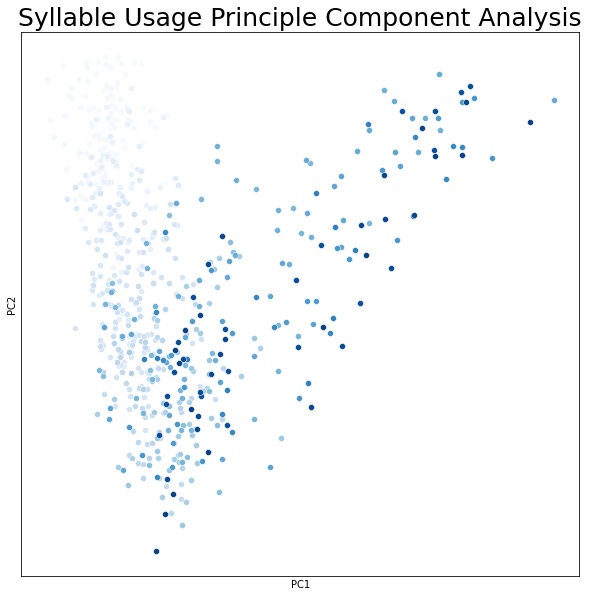

In [97]:
male_j,male_jj,male_jjj=pca_on_np_array(male_linear_sorted_frequencies)

pc1=[]
pc2=[]
pc3=[]
for n in male_j:
    pc1.append(n[0])
    pc2.append(n[1])
    pc3.append(n[2])   
freq_blocks=[]
for n in male_all_label_frequency_counts:
    freq_blocks.append(len(n))
    

fig, ax = plt.subplots()
fig.set_size_inches(10,10)    
    
pos=0
da_xs=[]
da_ys=[]
for i in range(len(freq_blocks)):
    
    #sns.lineplot(x=pc1[pos:pos+freq_blocks[i]-1],y=pc2[pos:pos+freq_blocks[i]-1],color=cm_list[i])
    sns.scatterplot(x=pc1[pos:pos+freq_blocks[i]-1],y=pc2[pos:pos+freq_blocks[i]-1],color=male_cm_list[male_age_labels_int[i]-24])
    pos=pos+freq_blocks[i]
    da_xs.append(pc1[pos:pos+freq_blocks[i]-1])
    da_ys.append(pc2[pos:pos+freq_blocks[i]-1])

plt.title('Syllable Usage Principle Component Analysis',fontsize=25)
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
plt.show()
fig.savefig(strain + ' Male PCA on Syllable Distribution.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male PCA on Syllable Distribution.png', bbox_inches='tight')

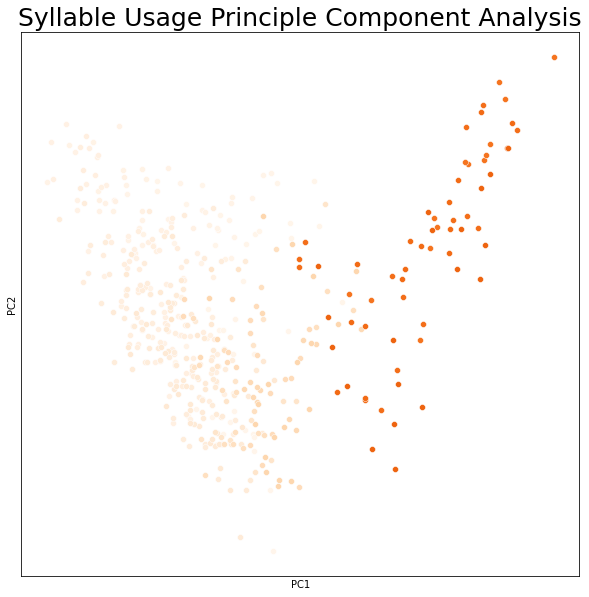

In [98]:
female_j,female_jj,female_jjj=pca_on_np_array(female_linear_sorted_frequencies)

pc1=[]
pc2=[]
pc3=[]
for n in female_j:
    pc1.append(n[0])
    pc2.append(n[1])
    pc3.append(n[2])   
freq_blocks=[]
for n in female_all_label_frequency_counts:
    freq_blocks.append(len(n))
    

fig, ax = plt.subplots()
fig.set_size_inches(10,10)    
    
pos=0
da_xs=[]
da_ys=[]
for i in range(len(freq_blocks)):
    
    #sns.lineplot(x=pc1[pos:pos+freq_blocks[i]-1],y=pc2[pos:pos+freq_blocks[i]-1],color=cm_list[i])
    sns.scatterplot(x=pc1[pos:pos+freq_blocks[i]-1],y=pc2[pos:pos+freq_blocks[i]-1],color=female_cm_list[female_age_labels_int[i]-24])
    pos=pos+freq_blocks[i]
    da_xs.append(pc1[pos:pos+freq_blocks[i]-1])
    da_ys.append(pc2[pos:pos+freq_blocks[i]-1])
plt.title('Syllable Usage Principle Component Analysis',fontsize=25)
plt.xlabel('PC1')
plt.ylabel('PC2')
ax.set_xticks([])
ax.set_yticks([])
fig.patch.set_facecolor('white')
plt.show()
fig.savefig(strain + ' Female PCA on Syllable Distribution.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female PCA on Syllable Distribution.png', bbox_inches='tight')

In [99]:
male_female_j=np.vstack((male_j,female_j))

In [100]:
from sklearn.manifold import TSNE
#j_embedded = TSNE(n_components=2,random_state=28,perplexity=50,early_exaggeration=5).fit_transform(j)
#j_embedded = TSNE(n_components=2,random_state=28,perplexity=20,early_exaggeration=10).fit_transform(j)
#j_embedded = TSNE(n_components=2,random_state=28,perplexity=20,early_exaggeration=10).fit_transform(male_female_j)
j_embedded = TSNE(n_components=2,random_state=28,perplexity=50,early_exaggeration=5).fit_transform(male_female_j)

j_embedded.shape

#len(male_j)
#len(male_j)
male_j_embedded=j_embedded[0:len(male_j)]
female_j_embedded=j_embedded[len(male_j):len(male_female_j)]

In [101]:
#plt.plot(j_embedded)

In [102]:
#plt.plot(j_embedded[:,0],j_embedded[:,1])

In [103]:
#GET THE MALE AND FEMALE SORTED TSNE WEIGHTS!!!!!!!!!!!!!!!!!!!!

male_sorted_tsne_weights=[]
male_associated_time=[]
for ui in unique_individual_longtogeny_males:
    male_ind_trajectory=[]
    male_ind_timepoints=[]
    for lsf in range(len(male_linear_sorted_fields)):
        if ui[0:2]==male_linear_sorted_fields[lsf][0] and ui[3:5]==male_linear_sorted_fields[lsf][1]:
            male_ind_trajectory.append(list(male_j_embedded[lsf]))
            male_ind_timepoints.append(male_linear_sorted_fields[lsf][2])
    male_sorted_tsne_weights.append(male_ind_trajectory)
    male_associated_time.append(male_ind_timepoints)
    
'''for i in range(len(female_dates)):
    color = cm(1.*i/len(female_dates))
    cm_list.append(color)'''
    


female_sorted_tsne_weights=[]
female_associated_time=[]
for ui in unique_individual_longtogeny_females:
    female_ind_trajectory=[]
    female_ind_timepoints=[]
    for lsf in range(len(female_linear_sorted_fields)):
        if ui[0:2]==female_linear_sorted_fields[lsf][0] and ui[3:5]==female_linear_sorted_fields[lsf][1]:
            female_ind_trajectory.append(list(female_j_embedded[lsf]))
            female_ind_timepoints.append(female_linear_sorted_fields[lsf][2])
    female_sorted_tsne_weights.append(female_ind_trajectory)
    female_associated_time.append(female_ind_timepoints)

In [104]:
#make the data the same length for all mice!!!

male_filled=[]
#goal is to have timepoints for every individual filled
master_times=male_age_labels_int[:]
for i in range(len(male_sorted_tsne_weights)):
    indv=male_sorted_tsne_weights[i]
    indv_dates=male_associated_time[i]
    indv_times=[]
    for n in indv_dates:
        try:
            date_id=male_dates.index(n)
            indv_times.append(male_age_labels_int[date_id])
        except:
            print(n + ' missing')
        
    raw_unfilled_data=list(np.zeros(len(master_times)))
    
    g=0
    for n in indv_times:
        raw_unfilled_data[master_times.index(n)]=indv[g]
        g+=1
        
    for j in range(len(raw_unfilled_data)):
        if raw_unfilled_data[j] == 0:
            #print('filling ' + str(master_times[j]) + ' for mouse' + str(i))
            
            raw_unfilled_data[j]=[np.nan,np.nan]
    male_filled.append(raw_unfilled_data)
     
            
            
male_filled_x=[]
male_filled_y=[]
for n in male_filled:
    male_filled_x.append(list(np.array(n)[:,0]))
    male_filled_y.append(list(np.array(n)[:,1]))    
    
    
    
    
female_filled=[]
#goal is to have timepoints for every individual filled
master_times=female_age_labels_int[:]
for i in range(len(female_sorted_tsne_weights)):
    indv=female_sorted_tsne_weights[i]
    indv_dates=female_associated_time[i]
    indv_times=[]
    for n in indv_dates:
        try:
            date_id=female_dates.index(n)
            indv_times.append(female_age_labels_int[date_id])
        except:
            print(n + ' missing')
        
    raw_unfilled_data=list(np.zeros(len(master_times)))
    
    g=0
    for n in indv_times:
        raw_unfilled_data[master_times.index(n)]=indv[g]
        g+=1
        
    for j in range(len(raw_unfilled_data)):
        if raw_unfilled_data[j] == 0:
            #print('filling ' + str(master_times[j]) + ' for mouse' + str(i))
            
            raw_unfilled_data[j]=[np.nan,np.nan]
    female_filled.append(raw_unfilled_data)
     
            
            
female_filled_x=[]
female_filled_y=[]
for n in female_filled:
    female_filled_x.append(list(np.array(n)[:,0]))
    female_filled_y.append(list(np.array(n)[:,1])) 
        

20210617 missing
20210617 missing
20210617 missing
20211119 missing
20210617 missing


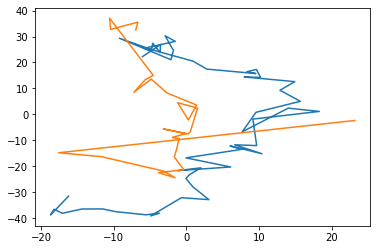

In [105]:
plt.plot(np.nanmean(male_filled_x,axis=0),np.nanmean(male_filled_y,axis=0))
plt.plot(np.nanmean(female_filled_x,axis=0),np.nanmean(female_filled_y,axis=0))

In [106]:
from scipy.ndimage.filters import gaussian_filter

male_filled_x_blurred = gaussian_filter(np.nanmean(male_filled_x,axis=0), sigma=1.5)
male_filled_y_blurred = gaussian_filter(np.nanmean(male_filled_y,axis=0), sigma=1.5)
female_filled_x_blurred = gaussian_filter(np.nanmean(female_filled_x,axis=0), sigma=1.5)
female_filled_y_blurred = gaussian_filter(np.nanmean(female_filled_y,axis=0), sigma=1.5)

male_filled_x_blurred = gaussian_filter(np.nanmedian(male_filled_x,axis=0), sigma=1.5)
male_filled_y_blurred = gaussian_filter(np.nanmedian(male_filled_y,axis=0), sigma=1.5)
female_filled_x_blurred = gaussian_filter(np.nanmedian(female_filled_x,axis=0), sigma=1.5)
female_filled_y_blurred = gaussian_filter(np.nanmedian(female_filled_y,axis=0), sigma=1.5)

In [113]:
#female @ index 25 is ~equal to male at index 46


273

point 23 missing
point 24 missing
point 23 missing
point 24 missing
point 22 missing


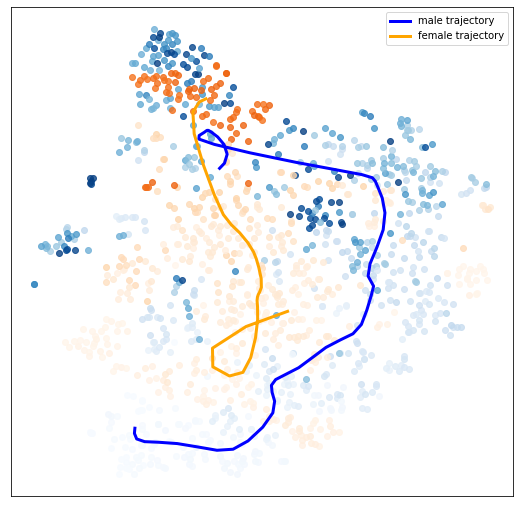

In [107]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')

plt.plot(male_filled_x_blurred,male_filled_y_blurred,color='blue',linewidth=3)
plt.plot(female_filled_x_blurred,female_filled_y_blurred,color='orange',linewidth=3)

plt.legend(['male trajectory','female trajectory'],loc='upper right')

for ind in range(len(male_sorted_tsne_weights)):
    
    #if ind in [14] : #can use this to choose just one trajectory if i want
        #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])


    for point in range(len(male_sorted_tsne_weights[ind])):
        try:
            color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
            plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)
        except:
            print('point ' + str(point) + ' missing')
for ind in range(len(female_sorted_tsne_weights)):
    
    #if ind in [14] : #can use this to choose just one trajectory if i want
        #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])


    for point in range(len(female_sorted_tsne_weights[ind])):
        try:
            color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
            plt.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index],alpha=.8)
        except:
            print('point ' + str(point) + ' missing')
            
ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male and Female Trajectories.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male and Female Trajectories.png', bbox_inches='tight')


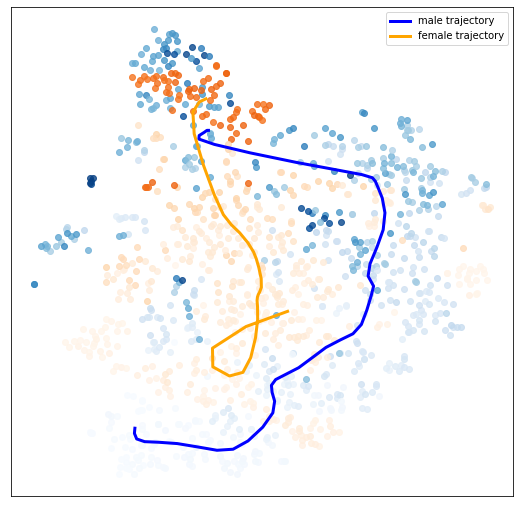

In [146]:
#making it so the male and females stop at roughly the same point

fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')

plt.plot(male_filled_x_blurred[0:46],male_filled_y_blurred[0:46],color='blue',linewidth=3)
plt.plot(female_filled_x_blurred,female_filled_y_blurred,color='orange',linewidth=3)

plt.legend(['male trajectory','female trajectory'],loc='upper right')

for ind in range(len(male_sorted_tsne_weights)):
    
    #if ind in [14] : #can use this to choose just one trajectory if i want
        #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])


    for point in range(46):
        try:
            color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
            plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)
        except:
            pass
            #print('point ' + str(point) + ' missing')
for ind in range(len(female_sorted_tsne_weights)):
    
    #if ind in [14] : #can use this to choose just one trajectory if i want
        #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])


    for point in range(46):
        try:
            color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
            plt.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index],alpha=.8)
        except:
            pass
            #print('point ' + str(point) + ' missing')
            
ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Truncated and Female Trajectories.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Truncated and Female Trajectories.png', bbox_inches='tight')


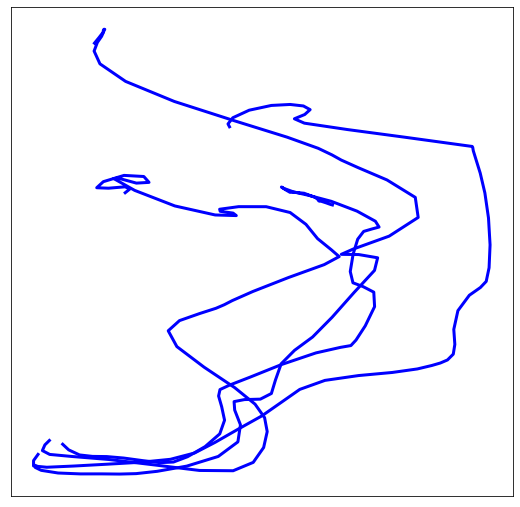

In [119]:
#show the mean trajcetory for all cages

fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')


male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

# add dots
# for ind in range(len(male_sorted_tsne_weights)):
    
#     #if ind in [14] : #can use this to choose just one trajectory if i want
#         #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

#     for point in range(len(male_sorted_tsne_weights[ind])):
#         color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
#         plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)

ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Trajectories By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories By Cage.png', bbox_inches='tight')


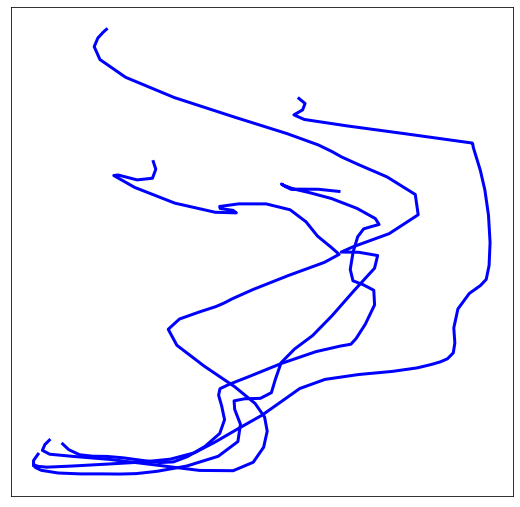

In [121]:
#show the mean trajcetory for all cages truncated

fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')


male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

# add dots
# for ind in range(len(male_sorted_tsne_weights)):
    
#     #if ind in [14] : #can use this to choose just one trajectory if i want
#         #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

#     for point in range(len(male_sorted_tsne_weights[ind])):
#         color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
#         plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)

ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Truncated Trajectories By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Truncated Trajectories By Cage.png', bbox_inches='tight')


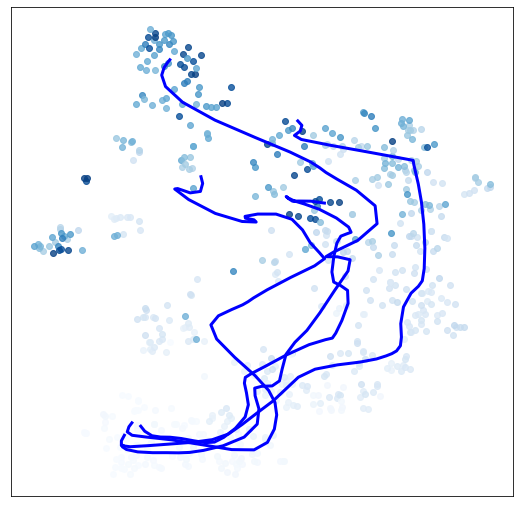

In [142]:
#show the mean trajcetory for all cages truncated

fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')


male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

#add dots
for ind in range(len(male_sorted_tsne_weights)):
    
#     if 1==1: #can use this to choose just one trajectory if i want
#          ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])

    try:
        for point in range(len(male_sorted_tsne_weights[ind])):
            color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
            plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)
    except:
        pass
ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Truncated Trajectories With Dots By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Truncated Trajectories With Dots By Cage.png', bbox_inches='tight')


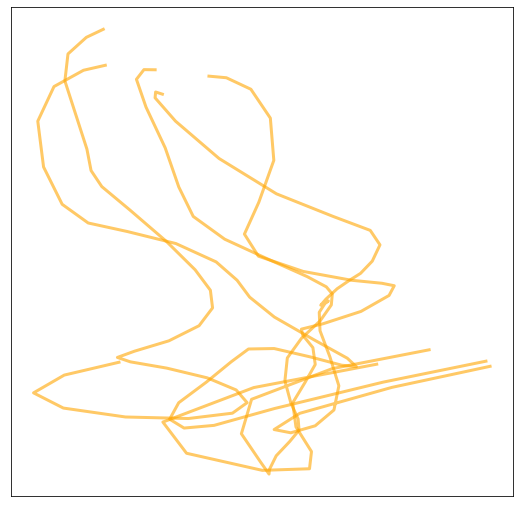

In [144]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')

female_subset_ids=[0,1,2,3]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[4,5,6,7]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[8,9,10,11]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[12,13,14,15]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[16,17,18,19]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)
 
plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Female Trajectories By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories By Cage.png', bbox_inches='tight')


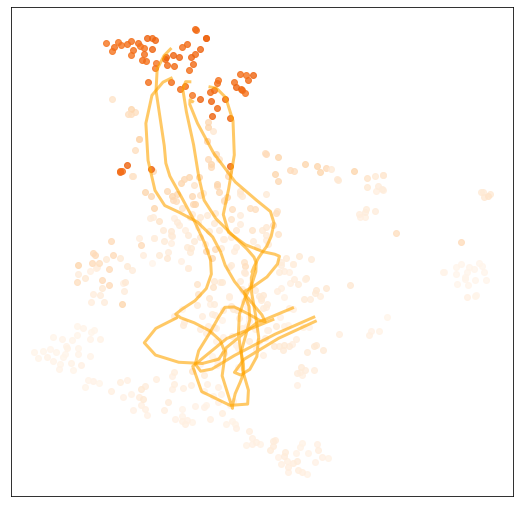

In [143]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')

female_subset_ids=[0,1,2,3]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[4,5,6,7]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[8,9,10,11]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[12,13,14,15]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[16,17,18,19]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)
 
plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

# add dots
for ind in range(len(female_sorted_tsne_weights)):
    
#     if 1==1 : #can use this to choose just one trajectory if i want
#         ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

    try:
        for point in range(len(female_sorted_tsne_weights[ind])):
            color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
            plt.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index],alpha=.8)
    except:
        pass
ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Female Trajectories With Dots By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories With Dots By Cage.png', bbox_inches='tight')


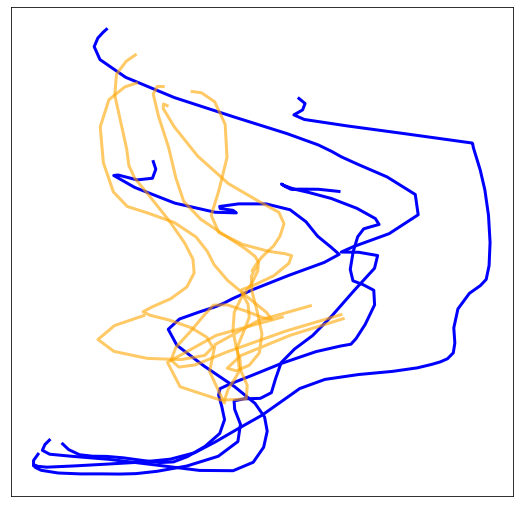

In [123]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')




#show the mean trajcetory for females and males with all cages truncated


male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

# add dots
# for ind in range(len(male_sorted_tsne_weights)):
    
#     #if ind in [14] : #can use this to choose just one trajectory if i want
#         #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

#     for point in range(len(male_sorted_tsne_weights[ind])):
#         color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
#         plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)





#femalse






female_subset_ids=[0,1,2,3]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[4,5,6,7]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[8,9,10,11]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[12,13,14,15]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[16,17,18,19]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)
 
plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

# add dots
# for ind in range(len(female_sorted_tsne_weights)):
    
#     #if ind in [14] : #can use this to choose just one trajectory if i want
#         #ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

#     for point in range(len(female_sorted_tsne_weights[ind])):
#         color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
#         plt.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index],alpha=.8)

ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Truncated and Female Trajectories By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Truncated and Female Trajectories By Cage.png', bbox_inches='tight')


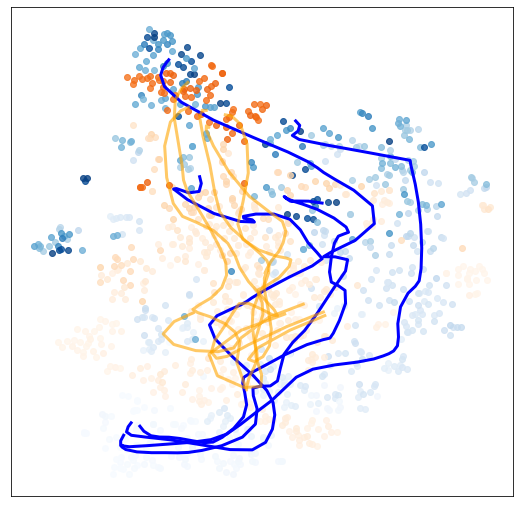

In [145]:
fig, ax = plt.subplots()
fig.set_size_inches(9,9) 
fig.patch.set_facecolor('white')




#show the mean trajcetory for females and males with all cages truncated


male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(46):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)[0:46]
male_subset_y=np.nanmean(male_subset_y,axis=0)[0:46]
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)[0:46]
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)[0:46]

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)

#add dots
for ind in range(len(male_sorted_tsne_weights)):
    
#     if 1==1: #can use this to choose just one trajectory if i want
#          ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])

    try:
        for point in range(len(male_sorted_tsne_weights[ind])):
            color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
            plt.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index],alpha=.8)
    except:
        pass
ax.set_xticks([])
ax.set_yticks([])




#females





female_subset_ids=[0,1,2,3]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[4,5,6,7]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[8,9,10,11]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[12,13,14,15]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

female_subset_ids=[16,17,18,19]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)
 
plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3,alpha=.6)

# add dots
for ind in range(len(female_sorted_tsne_weights)):
    
#     if 1==1 : #can use this to choose just one trajectory if i want
#         ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=cm_list2[ind])

    try:
        for point in range(len(female_sorted_tsne_weights[ind])):
            color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
            plt.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index],alpha=.8)
    except:
        pass
ax.set_xticks([])
ax.set_yticks([])


plt.show()


fig.savefig(strain + ' Male Truncated With Dots and Female Trajectories With Dots By Cage.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Truncated With Dots and Female Trajectories With Dots By Cage.png', bbox_inches='tight')


point 23 missing


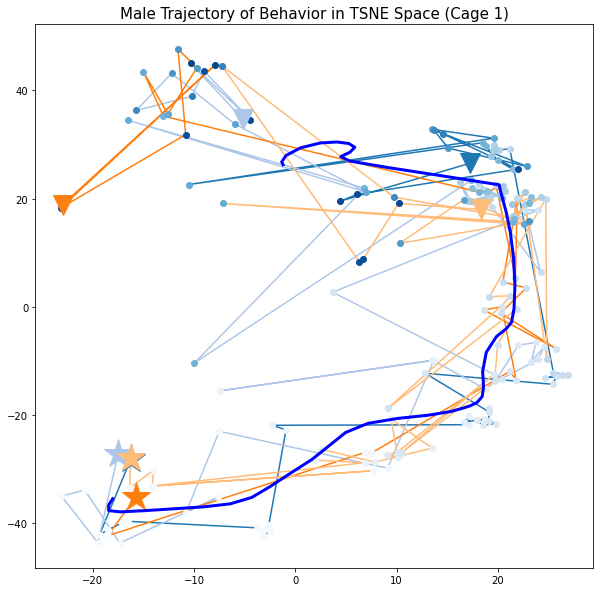

In [220]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Male Trajectory of Behavior in TSNE Space (Cage 1)',fontsize=15)

male_subset_ids=[0,1,2,3]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)



for ind in range(len(male_sorted_tsne_weights)):
    if ind in [0,1,2,3] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])

    for point in range(len(male_sorted_tsne_weights[ind])):
        if ind in [0,1,2,3] :
            try:
                color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
                sp=ax.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [0,1,2,3] :
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][point],np.array(male_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Male Trajectories Cage 1.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories Cage 1.png', bbox_inches='tight')

point 24 missing


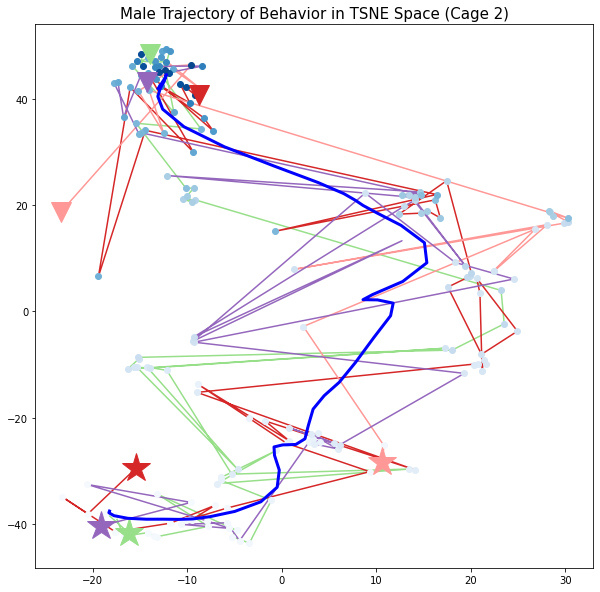

In [221]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Male Trajectory of Behavior in TSNE Space (Cage 2)',fontsize=15)

male_subset_ids=[4,5,6,7]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)



for ind in range(len(male_sorted_tsne_weights)):
    if ind in [4,5,6,7] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])

    for point in range(len(male_sorted_tsne_weights[ind])):
        if ind in [4,5,6,7] :
            try:
                color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
                sp=ax.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [4,5,6,7] :
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][point],np.array(male_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Male Trajectories Cage 2.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories Cage 2.png', bbox_inches='tight')

point 23 missing


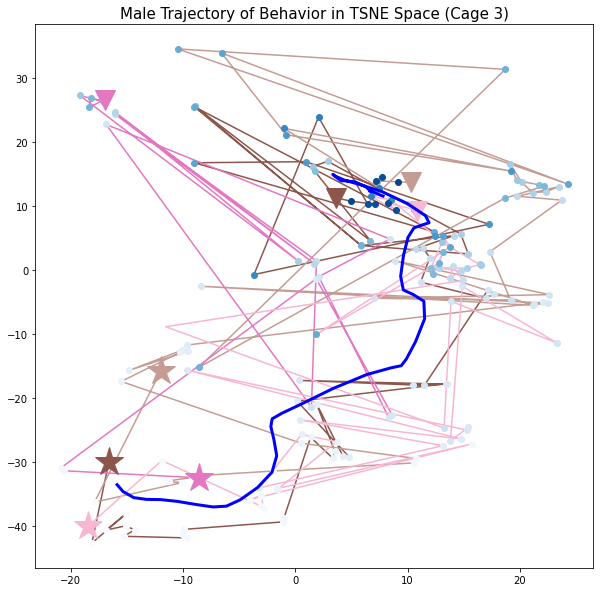

In [222]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Male Trajectory of Behavior in TSNE Space (Cage 3)',fontsize=15)

male_subset_ids=[8,9,10,11]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)



for ind in range(len(male_sorted_tsne_weights)):
    if ind in [8,9,10,11] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])

    for point in range(len(male_sorted_tsne_weights[ind])):
        if ind in [8,9,10,11] :
            try:
                color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
                sp=ax.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [8,9,10,11] :
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][point],np.array(male_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Male Trajectories Cage 3.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories Cage 3.png', bbox_inches='tight')

point 24 missing
point 22 missing


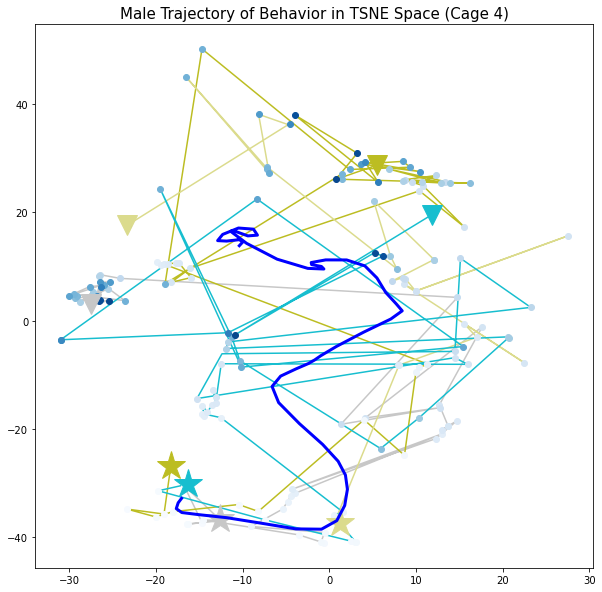

In [223]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Male Trajectory of Behavior in TSNE Space (Cage 4)',fontsize=15)

male_subset_ids=[12,13,14,15]

male_subset_x=[]
male_subset_y=[]
for i in range(len(male_filled_x)):
    if i in male_subset_ids:
        male_subset_x.append(male_filled_x[i])
        male_subset_y.append(male_filled_y[i])

male_subset_x=np.nanmean(male_subset_x,axis=0)
male_subset_y=np.nanmean(male_subset_y,axis=0)
male_subset_x_blurred = gaussian_filter(male_subset_x, sigma=1.5)
male_subset_y_blurred = gaussian_filter(male_subset_y, sigma=1.5)

plt.plot(male_subset_x_blurred,male_subset_y_blurred,color='blue',linewidth=3)



for ind in range(len(male_sorted_tsne_weights)):
    if ind in [12,13,14,15] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])

    for point in range(len(male_sorted_tsne_weights[ind])):
        if ind in [12,13,14,15] :
            try:
                color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
                sp=ax.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [12,13,14,15] :
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][point],np.array(male_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Male Trajectories Cage 4.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories Cage 4.png', bbox_inches='tight')

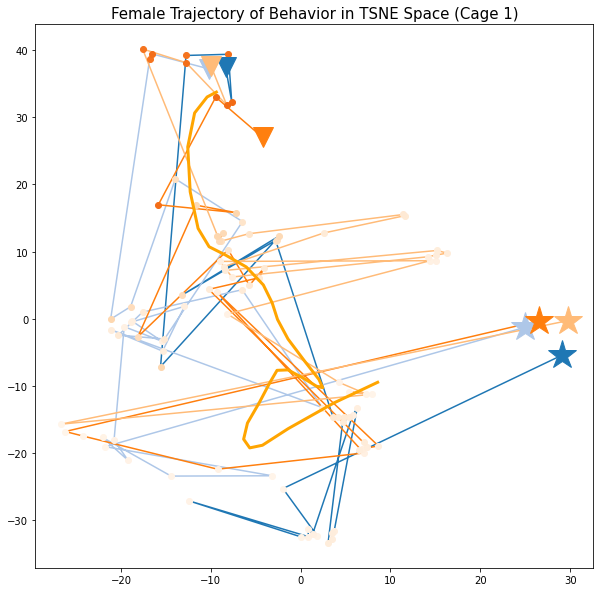

In [224]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (Cage 1)',fontsize=15)

female_subset_ids=[0,1,2,3]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3)



for ind in range(len(female_sorted_tsne_weights)):
    if ind in [0,1,2,3] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        if ind in [0,1,2,3] :
            try:
                color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
                sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [0,1,2,3] :
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Female Trajectories Cage 1.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Cage 1.png', bbox_inches='tight')

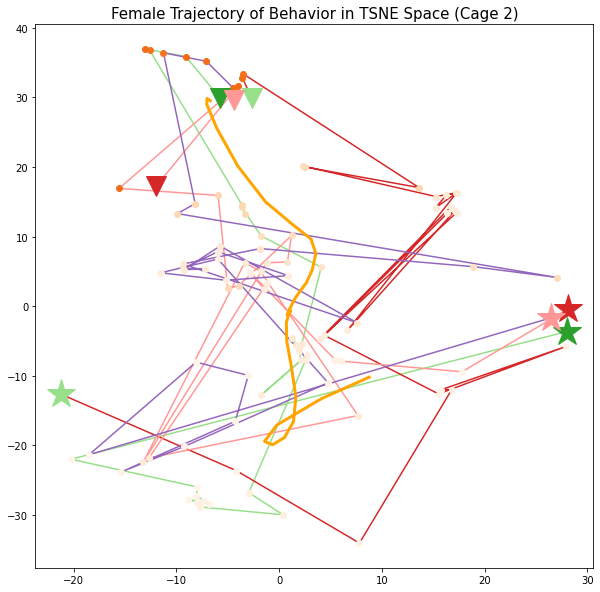

In [225]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (Cage 2)',fontsize=15)

female_subset_ids=[4,5,6,7]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3)



for ind in range(len(female_sorted_tsne_weights)):
    if ind in [4,5,6,7] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        if ind in [4,5,6,7] :
            try:
                color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
                sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [4,5,6,7] :
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Female Trajectories Cage 2.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Cage 2.png', bbox_inches='tight')

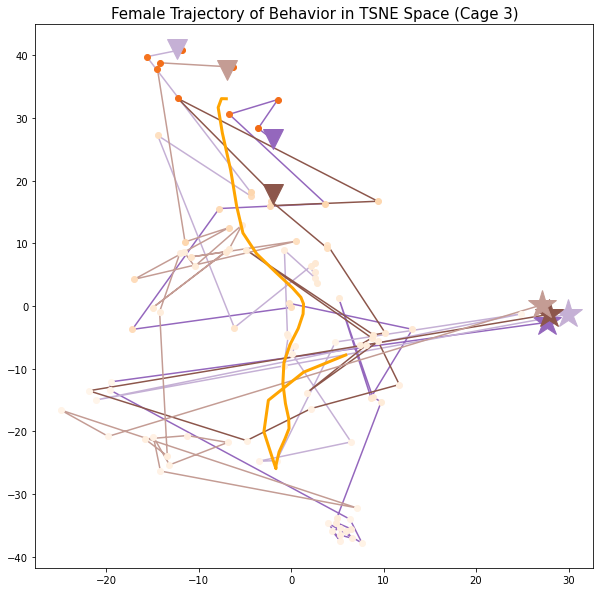

In [226]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (Cage 3)',fontsize=15)

female_subset_ids=[8,9,10,11]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3)



for ind in range(len(female_sorted_tsne_weights)):
    if ind in [8,9,10,11] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=female_cm_list2[ind])
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        if ind in [8,9,10,11] :
            try:
                color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
                sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [8,9,10,11] :
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Female Trajectories Cage 3.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Cage 3.png', bbox_inches='tight')

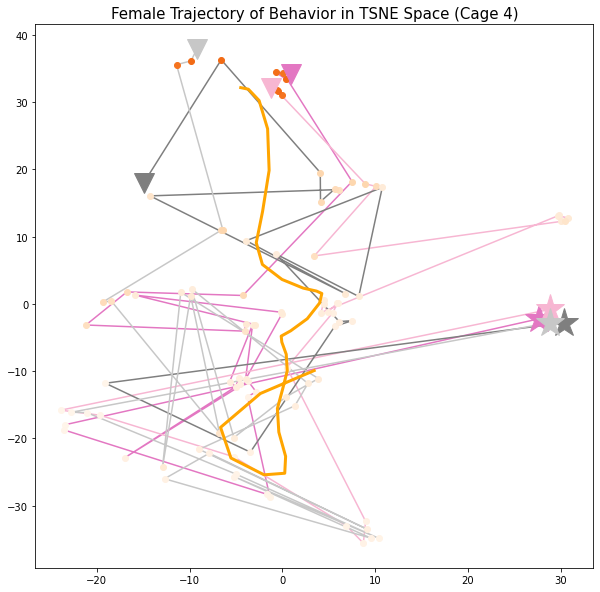

In [227]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (Cage 4)',fontsize=15)

female_subset_ids=[12,13,14,15]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3)



for ind in range(len(female_sorted_tsne_weights)):
    if ind in [12,13,14,15] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=female_cm_list2[ind])
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        if ind in [12,13,14,15] :
            try:
                color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
                sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [12,13,14,15] :
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Female Trajectories Cage 4.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Cage 4.png', bbox_inches='tight')

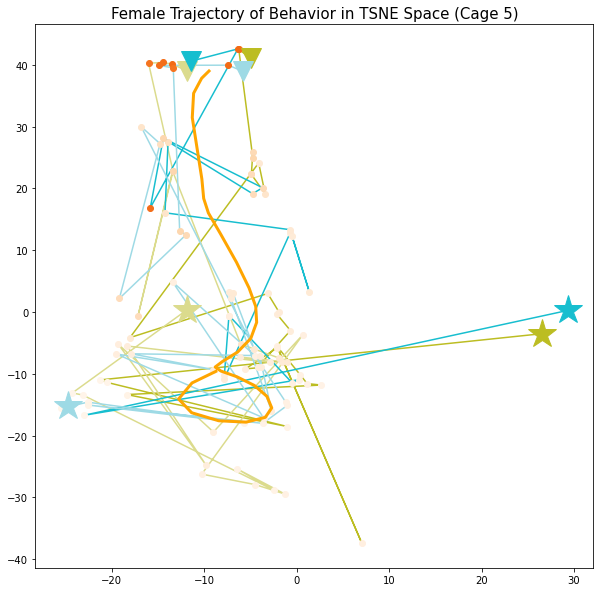

In [228]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (Cage 5)',fontsize=15)

female_subset_ids=[16,17,18,19]

female_subset_x=[]
female_subset_y=[]
for i in range(len(female_filled_x)):
    if i in female_subset_ids:
        female_subset_x.append(female_filled_x[i])
        female_subset_y.append(female_filled_y[i])

female_subset_x=np.nanmean(female_subset_x,axis=0)
female_subset_y=np.nanmean(female_subset_y,axis=0)
female_subset_x_blurred = gaussian_filter(female_subset_x, sigma=1.5)
female_subset_y_blurred = gaussian_filter(female_subset_y, sigma=1.5)

plt.plot(female_subset_x_blurred,female_subset_y_blurred,color='orange',linewidth=3)



for ind in range(len(female_sorted_tsne_weights)):
    if ind in [16,17,18,19] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=female_cm_list2[ind])
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        if ind in [16,17,18,19] :
            try:
                color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
                sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
            except:

                print('point ' + str(point) + ' missing')
    if ind in [16,17,18,19] :
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])        
plt.show()
fig.savefig(strain + ' Female Trajectories Cage 5.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Cage 5.png', bbox_inches='tight')

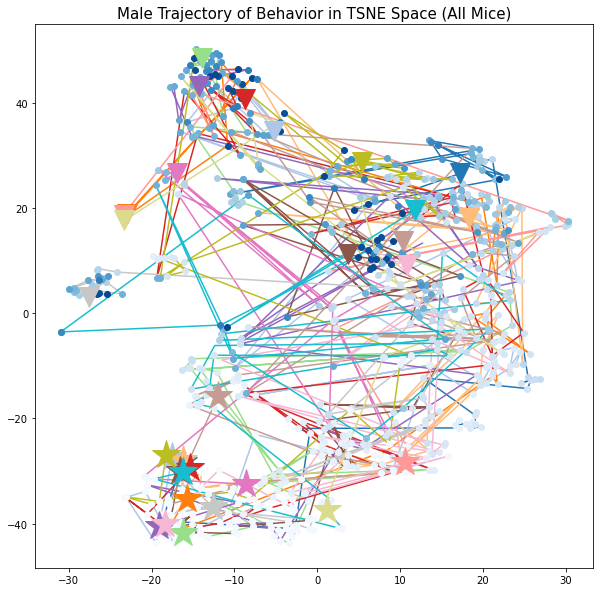

In [148]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Male Trajectory of Behavior in TSNE Space (All Mice)',fontsize=15)

for ind in range(len(male_sorted_tsne_weights)):
    if ind in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0],np.array(male_sorted_tsne_weights[ind])[:,1],zorder=-1,color=male_cm_list2[ind])
    ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])

    for point in range(len(male_sorted_tsne_weights[ind])):
        try: 
            color_index=male_age_labels_int[male_dates.index(male_associated_time[ind][point])]-24
            sp=ax.scatter(x=male_sorted_tsne_weights[ind][point][0],y=male_sorted_tsne_weights[ind][point][1],color=male_cm_list[color_index])
        except:
            pass
    ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][point],np.array(male_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])
plt.show()
fig.savefig(strain + ' Male Trajectories All Mice.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories All Mice.png', bbox_inches='tight')

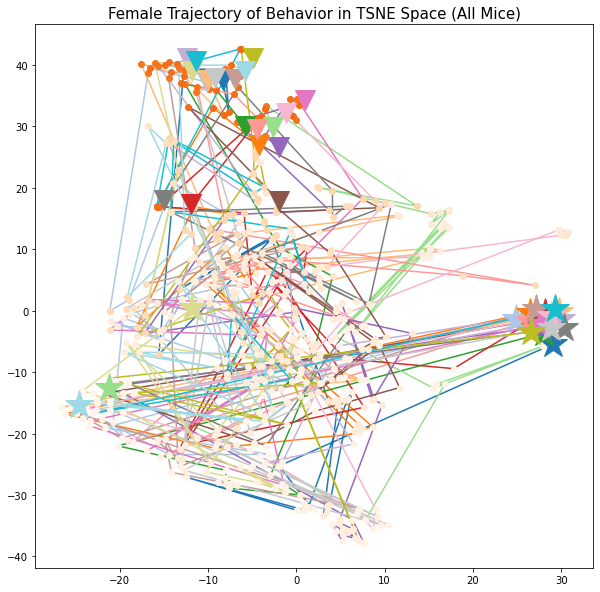

In [151]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title('Female Trajectory of Behavior in TSNE Space (All Mice)',fontsize=15)

for ind in range(len(female_sorted_tsne_weights)):
    if ind in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0],np.array(female_sorted_tsne_weights[ind])[:,1],zorder=-1,color=female_cm_list2[ind])
    ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])

    for point in range(len(female_sorted_tsne_weights[ind])):
        color_index=female_age_labels_int[female_dates.index(female_associated_time[ind][point])]-24
        sp=ax.scatter(x=female_sorted_tsne_weights[ind][point][0],y=female_sorted_tsne_weights[ind][point][1],color=female_cm_list[color_index])
    ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][point],np.array(female_sorted_tsne_weights[ind])[:,1][point],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])
plt.show()
fig.savefig(strain + ' Female Trajectories All Mice.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories All Mice.png', bbox_inches='tight')

/Users/rockwell/miniconda/envs/mo3/lib/python3.7/site-packages/seaborn/matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


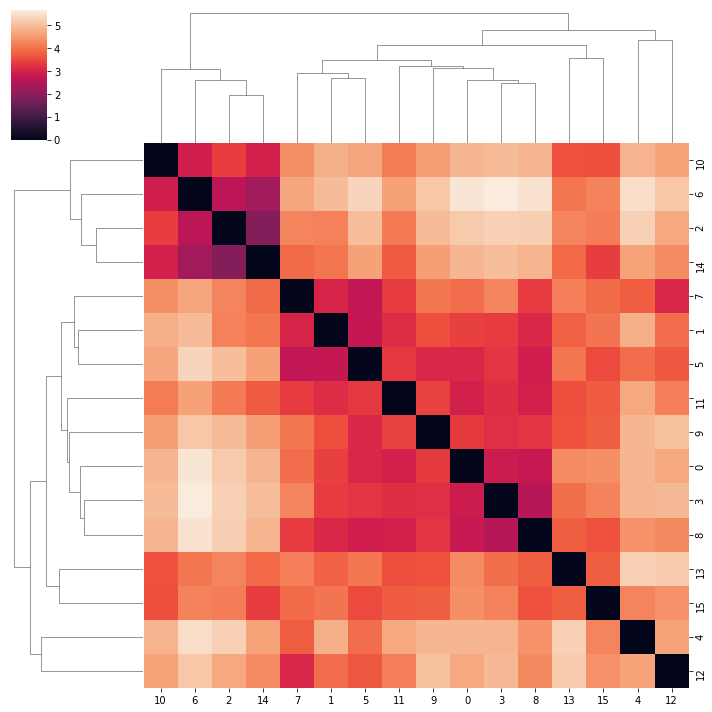

In [147]:
#Clustering the trajectories
male_entropy_of_trajectory_x=np.zeros((len(male_sorted_tsne_weights),len(male_sorted_tsne_weights)))
male_entropy_of_trajectory_y=np.zeros((len(male_sorted_tsne_weights),len(male_sorted_tsne_weights)))

for i in range(len(male_sorted_tsne_weights)):
    for j in range(len(male_sorted_tsne_weights)):
        norm_x_1=normalize(np.array(male_sorted_tsne_weights[i])[:,0])-min(normalize(np.array(male_sorted_tsne_weights[i])[:,0]))        
        norm_x_2=normalize(np.array(male_sorted_tsne_weights[j])[:,0])-min(normalize(np.array(male_sorted_tsne_weights[j])[:,0]))        
        norm_y_1=normalize(np.array(male_sorted_tsne_weights[i])[:,1])-min(normalize(np.array(male_sorted_tsne_weights[i])[:,1]))        
        norm_y_2=normalize(np.array(male_sorted_tsne_weights[j])[:,1])-min(normalize(np.array(male_sorted_tsne_weights[j])[:,1]))        
        
        length=max(len(norm_x_1),len(norm_x_2))
        x = list(range(0,length))
        if len(norm_x_1) >= len(norm_x_2): 
            y = norm_x_1
        if len(norm_x_1) < len(norm_x_2): 
            y = norm_x_2
        f1 = interp1d(x, y, kind='linear')

        interpolated_norm_x1=normalize(f1(norm_x_1))-min(normalize(f1(norm_x_1)))
        interpolated_norm_x2=normalize(f1(norm_x_2))-min(normalize(f1(norm_x_2)))
        
        length=min(len(norm_x_1),len(norm_x_2))
        difference_in_xs=scipy.stats.entropy(pk=interpolated_norm_x1[0:length],qk=interpolated_norm_x2[0:length],axis=0)
        difference_in_xs=scipy.spatial.distance.euclidean(interpolated_norm_x1[0:length],interpolated_norm_x2[0:length])
        male_entropy_of_trajectory_x[i,j]=difference_in_xs
        
        
        
        
        length=max(len(norm_y_1),len(norm_y_2))
        x = list(range(0,length))
        if len(norm_y_1) >= len(norm_y_2): 
            y = norm_y_1
        if len(norm_y_1) < len(norm_y_2): 
            y = norm_y_2
        f1 = interp1d(x, y, kind='linear')

        interpolated_norm_y1=normalize(f1(norm_y_1))-min(normalize(f1(norm_y_1)))
        interpolated_norm_y2=normalize(f1(norm_y_2))-min(normalize(f1(norm_y_2)))
                
        length=min(len(norm_y_1),len(norm_y_2))
        difference_in_ys=scipy.stats.entropy(pk=interpolated_norm_y1[0:length],qk=interpolated_norm_y2[0:length],axis=0)
        difference_in_ys=scipy.spatial.distance.euclidean(interpolated_norm_y1[0:length],interpolated_norm_y2[0:length])
        male_entropy_of_trajectory_y[i,j]=difference_in_ys

sns.clustermap(male_entropy_of_trajectory_y+male_entropy_of_trajectory_x,col_cluster=True,row_cluster=True)
plt.show()

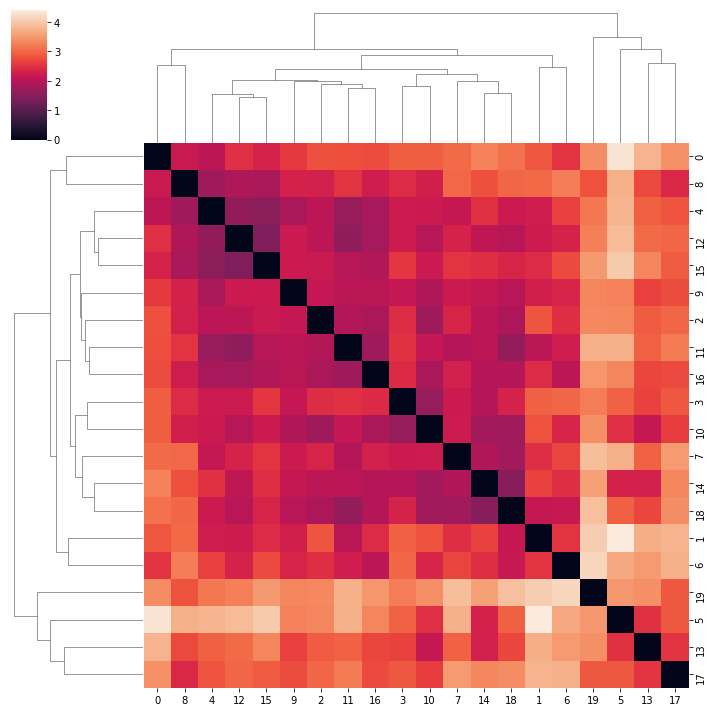

In [149]:
#Clustering the trajectories
female_entropy_of_trajectory_x=np.zeros((len(female_sorted_tsne_weights),len(female_sorted_tsne_weights)))
female_entropy_of_trajectory_y=np.zeros((len(female_sorted_tsne_weights),len(female_sorted_tsne_weights)))

for i in range(len(female_sorted_tsne_weights)):
    for j in range(len(female_sorted_tsne_weights)):
        norm_x_1=normalize(np.array(female_sorted_tsne_weights[i])[:,0])-min(normalize(np.array(female_sorted_tsne_weights[i])[:,0]))        
        norm_x_2=normalize(np.array(female_sorted_tsne_weights[j])[:,0])-min(normalize(np.array(female_sorted_tsne_weights[j])[:,0]))        
        norm_y_1=normalize(np.array(female_sorted_tsne_weights[i])[:,1])-min(normalize(np.array(female_sorted_tsne_weights[i])[:,1]))        
        norm_y_2=normalize(np.array(female_sorted_tsne_weights[j])[:,1])-min(normalize(np.array(female_sorted_tsne_weights[j])[:,1]))        
        
        length=max(len(norm_x_1),len(norm_x_2))
        x = list(range(0,length))
        if len(norm_x_1) >= len(norm_x_2): 
            y = norm_x_1
        if len(norm_x_1) < len(norm_x_2): 
            y = norm_x_2
        f1 = interp1d(x, y, kind='linear')

        interpolated_norm_x1=normalize(f1(norm_x_1))-min(normalize(f1(norm_x_1)))
        interpolated_norm_x2=normalize(f1(norm_x_2))-min(normalize(f1(norm_x_2)))
        
        length=min(len(norm_x_1),len(norm_x_2))
        difference_in_xs=scipy.stats.entropy(pk=interpolated_norm_x1[0:length],qk=interpolated_norm_x2[0:length],axis=0)
        difference_in_xs=scipy.spatial.distance.euclidean(interpolated_norm_x1[0:length],interpolated_norm_x2[0:length])
        female_entropy_of_trajectory_x[i,j]=difference_in_xs
        
        
        
        
        length=max(len(norm_y_1),len(norm_y_2))
        x = list(range(0,length))
        if len(norm_y_1) >= len(norm_y_2): 
            y = norm_y_1
        if len(norm_y_1) < len(norm_y_2): 
            y = norm_y_2
        f1 = interp1d(x, y, kind='linear')

        interpolated_norm_y1=normalize(f1(norm_y_1))-min(normalize(f1(norm_y_1)))
        interpolated_norm_y2=normalize(f1(norm_y_2))-min(normalize(f1(norm_y_2)))
                
        length=min(len(norm_y_1),len(norm_y_2))
        difference_in_ys=scipy.stats.entropy(pk=interpolated_norm_y1[0:length],qk=interpolated_norm_y2[0:length],axis=0)
        difference_in_ys=scipy.spatial.distance.euclidean(interpolated_norm_y1[0:length],interpolated_norm_y2[0:length])
        female_entropy_of_trajectory_y[i,j]=difference_in_ys
        

clustamap=sns.clustermap(female_entropy_of_trajectory_y+female_entropy_of_trajectory_x,col_cluster=True,row_cluster=True)
clustamap.fig.set_size_inches(10,10)
ax = clustamap.ax_heatmap
plt.show()
clustamap.fig.savefig(strain + 'Clustering Female Trajectories clustermap'+'.pdf', bbox_inches='tight')
clustamap.fig.savefig(strain + 'Clustering Female Trajectories clustermap'+'.png', bbox_inches='tight')

In [157]:
female_cluster1=[14,6,10,2,18]
female_cluster1_sorted_tsne_weights=[]
for n in female_cluster1:
    if len(female_sorted_tsne_weights[n])>=13:
        female_cluster1_sorted_tsne_weights.append(female_sorted_tsne_weights[n][0:13])
    
female_cluster2=[0,1,3,4,5,7,8,9,11,12,13,15,16,17,19]
female_cluster2_sorted_tsne_weights=[]
for n in female_cluster2:
    if len(female_sorted_tsne_weights[n])>=25:
        female_cluster2_sorted_tsne_weights.append(female_sorted_tsne_weights[n][0:25])
        
female_cluster21=[0,16,19,3,9,17,1,13]
female_cluster21_sorted_tsne_weights=[]
for n in female_cluster21:
    if len(female_sorted_tsne_weights[n])>=25:
        female_cluster21_sorted_tsne_weights.append(female_sorted_tsne_weights[n][0:25])
        
female_cluster22=[8,7,11,15,12,4,5]
female_cluster22_sorted_tsne_weights=[]
for n in female_cluster22:
    if len(female_sorted_tsne_weights[n])>=25:
        female_cluster22_sorted_tsne_weights.append(female_sorted_tsne_weights[n][0:25])
    

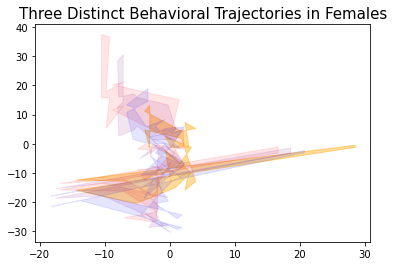

In [158]:
# fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')

female_cluster1_mean=np.nanmean(female_cluster1_sorted_tsne_weights,axis=0)
female_cluster1_bound_1=np.percentile(female_cluster1_sorted_tsne_weights,68,axis=0)
female_cluster1_bound_2=np.percentile(female_cluster1_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster1_mean)[:,0],np.array(female_cluster1_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster1_mean[:,0],female_cluster1_bound_1[:,1],female_cluster1_bound_2[:,1],alpha=.4,color='orange')

female_cluster2_mean=np.nanmean(female_cluster2_sorted_tsne_weights,axis=0)
female_cluster2_bound_1=np.nanpercentile(female_cluster2_sorted_tsne_weights,68,axis=0)
female_cluster2_bound_2=np.nanpercentile(female_cluster2_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster2_mean[:,0],female_cluster2_bound_1[:,1],female_cluster2_bound_2[:,1],alpha=.1,color='purple')


female_cluster21_mean=np.nanmean(female_cluster21_sorted_tsne_weights,axis=0)
female_cluster21_bound_1=np.nanpercentile(female_cluster21_sorted_tsne_weights,68,axis=0)
female_cluster21_bound_2=np.nanpercentile(female_cluster21_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster21_mean[:,0],female_cluster21_bound_1[:,1],female_cluster21_bound_2[:,1],alpha=.1,color='red')

female_cluster22_mean=np.nanmean(female_cluster22_sorted_tsne_weights,axis=0)
female_cluster22_bound_1=np.nanpercentile(female_cluster22_sorted_tsne_weights,68,axis=0)
female_cluster22_bound_2=np.nanpercentile(female_cluster22_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster22_mean[:,0],female_cluster22_bound_1[:,1],female_cluster22_bound_2[:,1],alpha=.1,color='blue')
plt.title(label='Three Distinct Behavioral Trajectories in Females',fontsize=15)

plt.show()
fig.savefig(strain + ' Female Trajectories Clusters.pdf', bbox_inches='tight')
fig.savefig(strain + ' Female Trajectories Clusters.png', bbox_inches='tight')

In [159]:
male_cluster1=[10,6,2,14]
male_cluster1_sorted_tsne_weights=[]
for n in male_cluster1:
    if len(male_sorted_tsne_weights[n])>=25:
        male_cluster1_sorted_tsne_weights.append(male_sorted_tsne_weights[n][0:30])
    
male_cluster21=[13,0,4,5,1]
male_cluster21_sorted_tsne_weights=[]
for n in male_cluster21:
    if len(male_sorted_tsne_weights[n])>=45:
        male_cluster21_sorted_tsne_weights.append(male_sorted_tsne_weights[n][0:45])
        
male_cluster22=[12,15,8,9,3,11]
male_cluster22_sorted_tsne_weights=[]
for n in female_cluster22:
    if len(male_sorted_tsne_weights[n])>=45:
        male_cluster22_sorted_tsne_weights.append(male_sorted_tsne_weights[n][0:45])

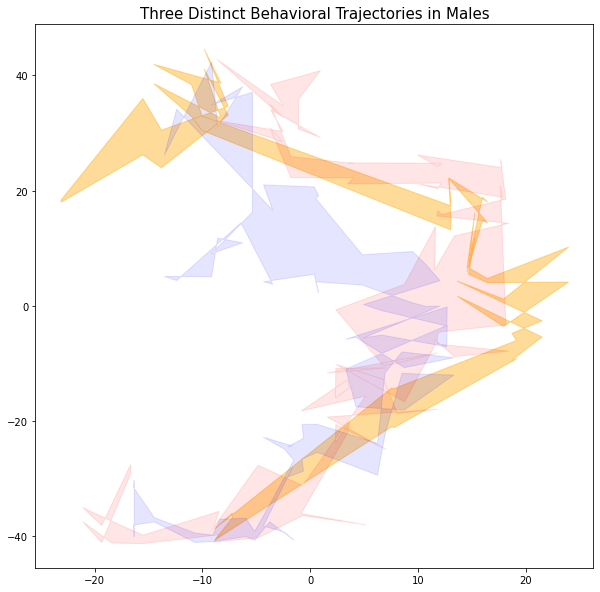

In [160]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')

plt.title('Three Distinct Behavioral Trajectories in Males',fontsize=15)


male_cluster1_mean=np.mean(male_cluster1_sorted_tsne_weights,axis=0)
male_cluster1_bound_1=np.percentile(male_cluster1_sorted_tsne_weights,68,axis=0)
male_cluster1_bound_2=np.percentile(male_cluster1_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster1_mean)[:,0],np.array(female_cluster1_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster1_mean[:,0],male_cluster1_bound_1[:,1],male_cluster1_bound_2[:,1],alpha=.4,color='orange')


male_cluster21_mean=np.mean(male_cluster21_sorted_tsne_weights,axis=0)
male_cluster21_bound_1=np.percentile(male_cluster21_sorted_tsne_weights,68,axis=0)
male_cluster21_bound_2=np.percentile(male_cluster21_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster21_mean[:,0],male_cluster21_bound_1[:,1],male_cluster21_bound_2[:,1],alpha=.1,color='red')

male_cluster22_mean=np.mean(male_cluster22_sorted_tsne_weights,axis=0)
male_cluster22_bound_1=np.percentile(male_cluster22_sorted_tsne_weights,68,axis=0)
male_cluster22_bound_2=np.percentile(male_cluster22_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster22_mean[:,0],male_cluster22_bound_1[:,1],male_cluster22_bound_2[:,1],alpha=.1,color='blue')

plt.show()

fig.savefig(strain + ' Male Trajectories Clusters.pdf', bbox_inches='tight')
fig.savefig(strain + ' Male Trajectories Clusters.png', bbox_inches='tight')

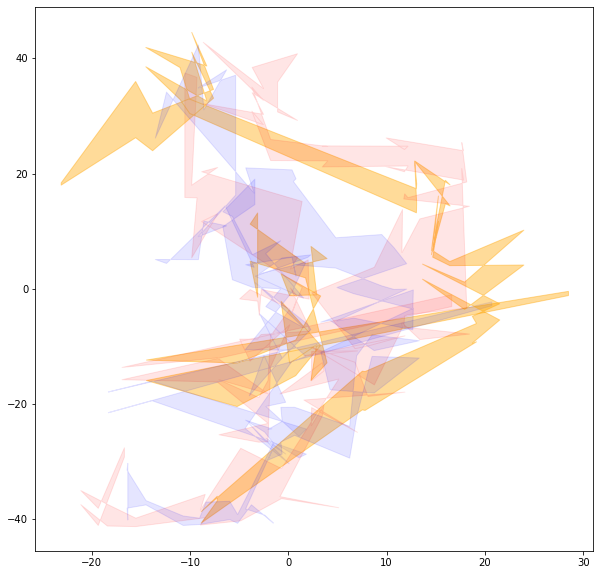

In [161]:
fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')

#female trajectories

female_cluster1_mean=np.mean(female_cluster1_sorted_tsne_weights,axis=0)
female_cluster1_bound_1=np.percentile(female_cluster1_sorted_tsne_weights,68,axis=0)
female_cluster1_bound_2=np.percentile(female_cluster1_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster1_mean)[:,0],np.array(female_cluster1_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster1_mean[:,0],female_cluster1_bound_1[:,1],female_cluster1_bound_2[:,1],alpha=.4,color='orange')


female_cluster21_mean=np.mean(female_cluster21_sorted_tsne_weights,axis=0)
female_cluster21_bound_1=np.percentile(female_cluster21_sorted_tsne_weights,68,axis=0)
female_cluster21_bound_2=np.percentile(female_cluster21_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster21_mean[:,0],female_cluster21_bound_1[:,1],female_cluster21_bound_2[:,1],alpha=.1,color='red')

female_cluster22_mean=np.mean(female_cluster22_sorted_tsne_weights,axis=0)
female_cluster22_bound_1=np.percentile(female_cluster22_sorted_tsne_weights,68,axis=0)
female_cluster22_bound_2=np.percentile(female_cluster22_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(female_cluster22_mean[:,0],female_cluster22_bound_1[:,1],female_cluster22_bound_2[:,1],alpha=.1,color='blue')


#male trajectoires


male_cluster1_mean=np.mean(male_cluster1_sorted_tsne_weights,axis=0)
male_cluster1_bound_1=np.percentile(male_cluster1_sorted_tsne_weights,68,axis=0)
male_cluster1_bound_2=np.percentile(male_cluster1_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster1_mean)[:,0],np.array(female_cluster1_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster1_mean[:,0],male_cluster1_bound_1[:,1],male_cluster1_bound_2[:,1],alpha=.4,color='orange')


male_cluster21_mean=np.mean(male_cluster21_sorted_tsne_weights,axis=0)
male_cluster21_bound_1=np.percentile(male_cluster21_sorted_tsne_weights,68,axis=0)
male_cluster21_bound_2=np.percentile(male_cluster21_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster21_mean[:,0],male_cluster21_bound_1[:,1],male_cluster21_bound_2[:,1],alpha=.1,color='red')

male_cluster22_mean=np.mean(male_cluster22_sorted_tsne_weights,axis=0)
male_cluster22_bound_1=np.percentile(male_cluster22_sorted_tsne_weights,68,axis=0)
male_cluster22_bound_2=np.percentile(male_cluster22_sorted_tsne_weights,32,axis=0)
#plt.plot(np.array(female_cluster2_mean)[:,0],np.array(female_cluster2_mean)[:,1],zorder=-1,color=cm_list2[ind])
plt.fill_between(male_cluster22_mean[:,0],male_cluster22_bound_1[:,1],male_cluster22_bound_2[:,1],alpha=.1,color='blue')

plt.show()



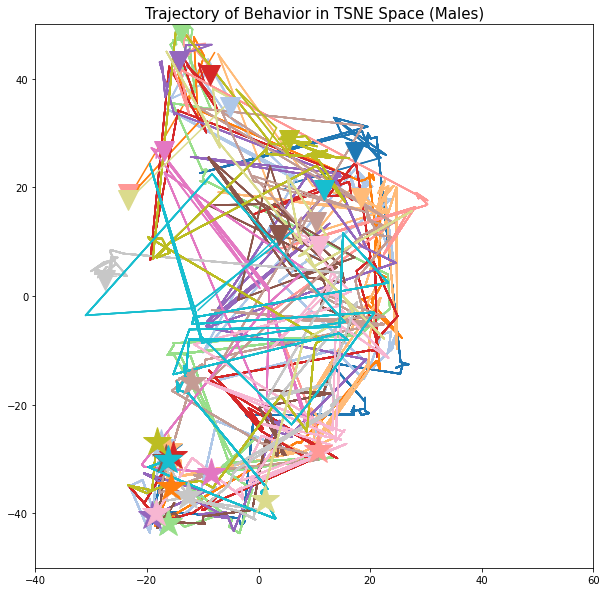

In [185]:
#make movie pngs
movie_title='Trajectory of Behavior in TSNE Space (Males)'
try:
    os.mkdir(movie_title)
except:
    print('directoy is probably already made')
os.chdir(movie_title)

fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title(movie_title,fontsize=15)
plt.ylim(-50,50)
plt.xlim(-40,60)

frame=0

for ind in range(len(male_sorted_tsne_weights)):

    if ind in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0],np.array(male_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=male_cm_list2[ind])
        fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
        frame+=1
        for l in range(len(male_sorted_tsne_weights[ind])):
            ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][0:l],np.array(male_sorted_tsne_weights[ind])[:,1][0:l],zorder=-1,color=male_cm_list2[ind])
            fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
            frame+=1
        ax.plot(np.array(male_sorted_tsne_weights[ind])[:,0][l],np.array(male_sorted_tsne_weights[ind])[:,1][l],marker='v',markersize=20,zorder=+1,color=male_cm_list2[ind])
        fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
        frame+=1

plt.show()

In [186]:
!ffmpeg -r 10 -i img_%04d.png -vb 20M -pix_fmt yuv420p male_allcage.mp4
abra='/Users/rockwell/Code/peroseq/'
os.chdir(abra)
os.chdir(data_loc)

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/rockwell/miniconda/envs/mo3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'img_%04d.png':
  Duration: 00:00:29.00, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(p

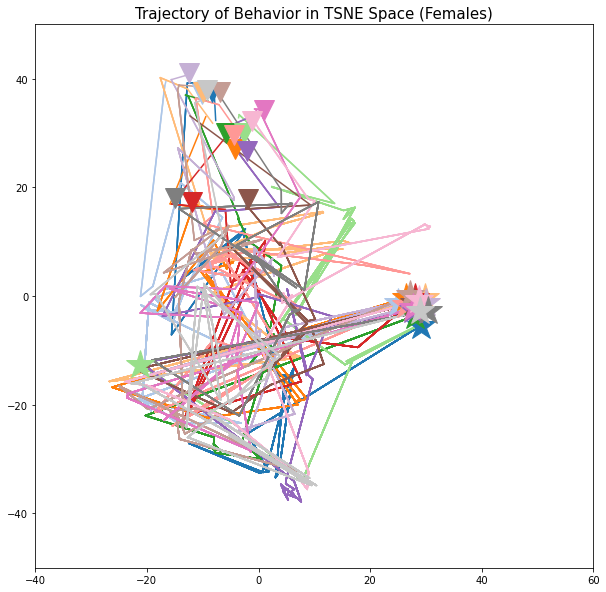

In [187]:
#make movie pngs
movie_title='Trajectory of Behavior in TSNE Space (Females)'
try:
    os.mkdir(movie_title)
except:
    print('directoy is probably already made')
os.chdir(movie_title)

fig, ax = plt.subplots()
fig.set_size_inches(10,10) 
fig.patch.set_facecolor('white')
plt.title(movie_title,fontsize=15)
plt.ylim(-50,50)
plt.xlim(-40,60)

frame=0

for ind in range(len(female_sorted_tsne_weights)):

    if ind in [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] : #can use this to choose just one trajectory if i want
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0],np.array(female_sorted_tsne_weights[ind])[:,1][0],marker='*',markersize=30,zorder=+1,color=female_cm_list2[ind])
        fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
        frame+=1
        for l in range(len(female_sorted_tsne_weights[ind])):
            ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][0:l],np.array(female_sorted_tsne_weights[ind])[:,1][0:l],zorder=-1,color=female_cm_list2[ind])
            fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
            frame+=1
        ax.plot(np.array(female_sorted_tsne_weights[ind])[:,0][l],np.array(female_sorted_tsne_weights[ind])[:,1][l],marker='v',markersize=20,zorder=+1,color=female_cm_list2[ind])
        fig.savefig('img_{:04d}.png'.format(frame), bbox_inches='tight')
        frame+=1

plt.show()

In [188]:
!ffmpeg -r 10 -i img_%04d.png -vb 20M -pix_fmt yuv420p female_allcage.mp4
abra='/Users/rockwell/Code/peroseq/'
os.chdir(abra)
os.chdir(data_loc)

ffmpeg version 4.2 Copyright (c) 2000-2019 the FFmpeg developers
  built with clang version 4.0.1 (tags/RELEASE_401/final)
  configuration: --prefix=/Users/rockwell/miniconda/envs/mo3 --cc=x86_64-apple-darwin13.4.0-clang --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-gpl --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-libx264 --enable-pic --enable-pthreads --enable-shared --enable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 31.100 / 56. 31.100
  libavcodec     58. 54.100 / 58. 54.100
  libavformat    58. 29.100 / 58. 29.100
  libavdevice    58.  8.100 / 58.  8.100
  libavfilter     7. 57.100 /  7. 57.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  5.100 /  5.  5.100
  libswresample   3.  5.100 /  3.  5.100
  libpostproc    55.  5.100 / 55.  5.100
Input #0, image2, from 'img_%04d.png':
  Duration: 00:00:17.92, start: 0.000000, bitrate: N/A
    Stream #0:0: Video: png, rgba(p

# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# Decodability of Males and Females
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

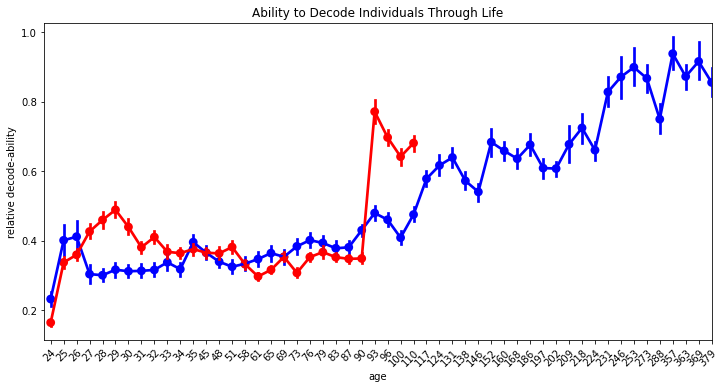

In [315]:
male_opuo=[]
for i in range(len(male_age_labels)):
    male_liol=[]
    for j in range(len(male_all_label_frequency_counts[0])):
        for k in range(len(male_all_label_frequency_counts[i])):
            male_liol.append(sum(np.square(np.subtract(male_all_label_frequency_counts[0][j][0:max_syllable],male_all_label_frequency_counts[i][k][0:max_syllable])))*len(unique_individual_longtogeny_males))
    
    male_opuo.append(male_liol)
    
female_opuo=[]
for i in range(len(female_age_labels)):
    female_liol=[]
    for j in range(len(female_all_label_frequency_counts[0])):
        for k in range(len(female_all_label_frequency_counts[i])):
            female_liol.append(sum(np.square(np.subtract(female_all_label_frequency_counts[0][j][0:max_syllable],female_all_label_frequency_counts[i][k][0:max_syllable])))*len(unique_individual_longtogeny_females))
    
    female_opuo.append(female_liol)
    
fig,ax=plt.subplots()
fig.set_size_inches(10,5)
fig.patch.set_facecolor('white')
fig.tight_layout()

sns.pointplot(data=male_opuo,ax=ax,color='blue')
sns.pointplot(data=female_opuo,ax=ax,color='red')
ax.set_title('Ability to Decode Individuals Through Life')
# We want to show all ticks...
ax.set_xticks(np.arange(len(male_age_labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(male_age_labels)
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

ax.set_ylabel('relative decode-ability')
ax.set_xlabel('age')
#ax.set_xlim([0,28.1])

plt.show()

fig.savefig(strain + ' Males Ability to Decode Individuals Through Life.pdf', bbox_inches='tight')
fig.savefig(strain + ' Males Ability to Decode Individuals Through Life.png', bbox_inches='tight')

In [316]:
male_decodeability=[]
male_decodeability_error_1=[]
male_decodeability_error_2=[]
male_decodeability_sem=[]
for n in male_opuo:
    male_decodeability.append(np.mean(n))
    male_decodeability_error_1.append(np.percentile(n,68))
    male_decodeability_error_2.append(np.percentile(n,32))
    male_decodeability_sem.append(scipy.stats.sem(n))
    #print(len(n))
male_decodeability=np.array(male_decodeability)


female_decodeability=[]
female_decodeability_error_1=[]
female_decodeability_error_2=[]
female_decodeability_sem=[]
for n in female_opuo:
    female_decodeability.append(np.mean(n))
    female_decodeability_error_1.append(np.percentile(n,68))
    female_decodeability_error_2.append(np.percentile(n,32))
    female_decodeability_sem.append(scipy.stats.sem(n))
    #print(len(n))
female_decodeability=np.array(female_decodeability)

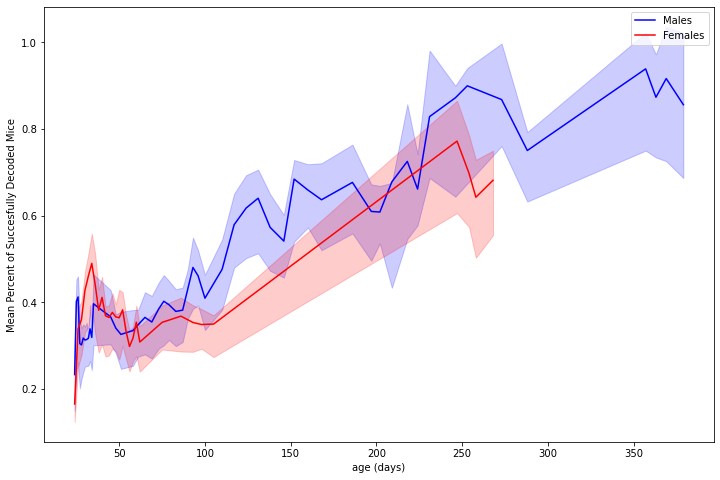

In [317]:
fig,ax=plt.subplots()
fig.set_size_inches(12,8)

plt.plot(male_age_labels_int,male_decodeability,color='blue',label="Males")
plt.fill_between(male_age_labels_int,list(male_decodeability_error_1),list(male_decodeability_error_2),alpha=.2,color='blue')

plt.plot(female_age_labels_int,female_decodeability,color='red',label="Females")
plt.fill_between(female_age_labels_int,list(female_decodeability_error_1),list(female_decodeability_error_2),alpha=.2,color='red')

plt.xlabel('age (days)')
#plt.ylabel('behavioral stability \n mean pairwise KLD of syllable usages from t to t + ' + str(window))
plt.ylabel('Mean Percent of Succesfully Decoded Mice')

plt.legend(loc="upper right")

plt.show()



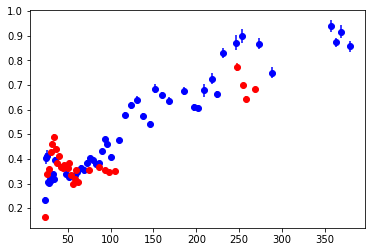

In [318]:
plt.errorbar(male_age_labels_int,male_decodeability,yerr=male_decodeability_sem,color='blue',marker='o',linestyle='')
plt.errorbar(female_age_labels_int,female_decodeability,yerr=female_decodeability_sem,color='red',marker='o',linestyle='')


plt.show()

In [ ]:
male_opuo=[]
for i in range(len(male_age_labels_intr)):
    male_liol=[]
    for j in range(len(male_frequencies_intr[0])):
        for k in range(len(male_frequencies_intr[i])):
            male_liol.append(sum(np.square(np.subtract(male_frequencies_intr[0][j][0:max_syllable],male_frequencies_intr[i][k][0:max_syllable])))*len(unique_individual_longtogeny_males))
    
    male_opuo.append(male_liol)
    
female_opuo=[]
for i in range(len(female_age_labels_intr)):
    female_liol=[]
    for j in range(len(female_frequencies_intr[0])):
        for k in range(len(female_frequencies_intr[i])):
            female_liol.append(sum(np.square(np.subtract(female_frequencies_intr[0][j][0:max_syllable],female_frequencies_intr[i][k][0:max_syllable])))*len(unique_individual_longtogeny_females))
    
    female_opuo.append(female_liol)
    
male_decodeability=[]
male_decodeability_error_1=[]
male_decodeability_error_2=[]
for n in male_opuo:
    male_decodeability.append(np.mean(n))
    male_decodeability_error_1.append(np.percentile(n,68))
    
    male_decodeability_error_2.append(np.percentile(n,32))
    #print(len(n))
male_decodeability=np.array(male_decodeability)


female_decodeability=[]
female_decodeability_error_1=[]
female_decodeability_error_2=[]
for n in female_opuo:
    female_decodeability.append(np.mean(n))
    female_decodeability_error_1.append(np.percentile(n,68))
    
    female_decodeability_error_2.append(np.percentile(n,32))
    #print(len(n))
female_decodeability=np.array(female_decodeability)

fig,ax=plt.subplots()
fig.set_size_inches(12,8)

plt.plot(male_age_labels_int_intr,male_decodeability,color='blue',label="Males")
plt.fill_between(male_age_labels_int_intr,list(male_decodeability_error_1),list(male_decodeability_error_2),alpha=.2,color='blue')

plt.plot(female_age_labels_int_intr,female_decodeability,color='red',label="Females")
plt.fill_between(female_age_labels_int_intr,list(female_decodeability_error_1),list(female_decodeability_error_2),alpha=.2,color='red')

plt.title('Decodeability of Males and Females')
plt.xlabel('age (days)')
#plt.ylabel('behavioral stability \n mean pairwise KLD of syllable usages from t to t + ' + str(window))
plt.ylabel('Mean Percent of Succesfully Decoded Mice')

plt.legend(loc="upper right")

plt.show()

In [ ]:
plt.plot(np.gradient(female_decodeability,axis=0))

In [ ]:
plt.plot(np.gradient(male_decodeability))

# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# SCALAR ANALYSIS
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
def get_scalar_for_all_timepoints(a_scalar,a_linear_sorted_field,a_scalar_fields,a_scalar_data,a_working_h5_list,sortindex=2,sortindex2=3):
    #seperate scalars into male_long, female_long, and _ont
    
    si=scalar_fields.index(a_scalar)

    h5_sess_ids=[]
    for full_extraction_address in a_working_h5_list:
        id_of_where_str_session_begins=full_extraction_address.index('session_')
        sess_id=full_extraction_address[id_of_where_str_session_begins:id_of_where_str_session_begins+22]
        h5_sess_ids.append(sess_id)

    current_t_point=a_linear_sorted_field[0][sortindex]
    scalar_for_all_t_points=[]
    scalars_for_this_t_point=[]
    for n in a_linear_sorted_field:

        try:
            sess_id=n[sortindex2]
            where_results_info_matches_linear_sorted_field=h5_sess_ids.index(sess_id)
            scalars_for_this_t_point.append(np.array(a_scalar_data)[:,si][where_results_info_matches_linear_sorted_field])
        except:
            print(n)

        if n[sortindex]!=current_t_point:
            scalar_for_all_t_points.append(scalars_for_this_t_point)
            current_t_point=n[sortindex]
            scalars_for_this_t_point=[]
            
    scalar_for_all_t_points.append(scalars_for_this_t_point)
            
            
    return scalar_for_all_t_points

    
'''angle',
'area_mm',
'area_px',
'centroid_x_mm',
'centroid_x_px',
'centroid_y_mm',
'centroid_y_px',
'height_ave_mm',
'length_mm',
'length_px',
'velocity_2d_mm',
'velocity_2d_px',
'velocity_3d_mm',
'velocity_3d_px',
'velocity_theta',
'width_mm',
'width_px'''


In [ ]:
scalars_address="/Users/rockwell/Code/220323_LONG_AND_ONT/220323_long_and_ont_scalars.pkl"
with open(scalars_address, 'rb') as f:  
    [scalar_fields,scalar_data,working_h5_list,result_info] = pickle.load(f)
f.close()

In [ ]:
male_velocity2d=get_scalar_for_all_timepoints(a_scalar='velocity_2d_mm',
                                              a_linear_sorted_field=male_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

male_area_mm=get_scalar_for_all_timepoints(a_scalar='area_mm',
                                              a_linear_sorted_field=male_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

male_centroid_x_mm=get_scalar_for_all_timepoints(a_scalar='centroid_x_mm',
                                              a_linear_sorted_field=male_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

male_centroid_y_mm=get_scalar_for_all_timepoints(a_scalar='centroid_y_mm',
                                              a_linear_sorted_field=male_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

female_velocity2d=get_scalar_for_all_timepoints(a_scalar='velocity_2d_mm',
                                              a_linear_sorted_field=female_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

female_area_mm=get_scalar_for_all_timepoints(a_scalar='area_mm',
                                              a_linear_sorted_field=female_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

female_centroid_x_mm=get_scalar_for_all_timepoints(a_scalar='centroid_x_mm',
                                              a_linear_sorted_field=female_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

female_centroid_y_mm=get_scalar_for_all_timepoints(a_scalar='centroid_y_mm',
                                              a_linear_sorted_field=female_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=2)

ontogeny_velocity2d=get_scalar_for_all_timepoints(a_scalar='velocity_2d_mm',
                                              a_linear_sorted_field=ontogeny_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=0,sortindex2=1)

ontogeny_area_mm=get_scalar_for_all_timepoints(a_scalar='area_mm',
                                              a_linear_sorted_field=ontogeny_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=0,sortindex2=1)

ontogeny_centroid_x_mm=get_scalar_for_all_timepoints(a_scalar='centroid_x_mm',
                                              a_linear_sorted_field=ontogeny_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=0,sortindex2=1)

ontogeny_centroid_y_mm=get_scalar_for_all_timepoints(a_scalar='centroid_y_mm',
                                              a_linear_sorted_field=ontogeny_linear_sorted_fields,
                                              a_scalar_fields=scalar_fields,
                                              a_scalar_data=scalar_data,
                                              a_working_h5_list=working_h5_list,
                                              sortindex=0,sortindex2=1)

In [ ]:
def scalar_summary_stats(exp_scalar):
    tpoint_means=[]
    tpoint_medians=[]
    tpoint_variances=[]
    for tpoint in exp_scalar:
        indv_means=[]   
        indv_medians=[]
        indv_variances=[]
        for indv in tpoint:
            indv_mean=np.nanmean(indv)
            indv_means.append(indv_mean)

            indv_median=np.nanmedian(indv)
            indv_medians.append(indv_median)

            indv_variance=np.nanvar(indv)
            indv_variances.append(indv_variance)


        tpoint_means.append(np.nanmean(indv_means))
        tpoint_medians.append(np.nanmedian(indv_medians))
        tpoint_variances.append(np.nanvar(indv_variances))

    return tpoint_means,tpoint_medians,tpoint_variances

In [ ]:

appended_area_mm=[]

for tpoints in ontogeny_area_mm:
    tpoint_data_x=[]
    for indvs in tpoints:
        tpoint_data_x.append(indvs[0:n_frames_to_use])
    appended_area_mm.append(np.concatenate(tpoint_data_x))
    
#error
area_mm_ontogeny=[]
sem_of_area_mm_ontogeny=[]
for n in appended_area_mm:
    nmice=len(n)/20000
    area_mm_ontogeny.append(np.nanmean(n))
    sem_of_area_mm_ontogeny.append((np.nanstd(n)))


fig,ax=plt.subplots()
fig.set_size_inches(12,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Average Mouse Size')
plt.ylabel('Square Millimeters (Overhead View)')
plt.xlabel('Age Cohorts')
for i in range(8):
    plt.bar(i,area_mm_ontogeny[i],yerr=sem_of_area_mm_ontogeny[i],color=ontogeny_color_mat2_hex[i],alpha=.5)
plt.xticks(list(range(8)), ['3wk','5wk','7wk','9wk','3mon','6mon','12mon','18mon'])
plt.show()

fig.savefig(strain + ' Open Field Mouse Area.pdf', bbox_inches='tight')
fig.savefig(strain + ' Open Field Mouse Area.png', bbox_inches='tight')

In [ ]:
from scipy.ndimage.filters import gaussian_filter


appended_centroid_x_mm=[]

for tpoints in ontogeny_centroid_x_mm:
    tpoint_data_x=[]
    for indvs in tpoints:
        tpoint_data_x.append(indvs[0:n_frames_to_use])
    appended_centroid_x_mm.append(np.concatenate(tpoint_data_x))
    
appended_centroid_y_mm=[]

for tpoints in ontogeny_centroid_y_mm:
    tpoint_data_y=[]
    for indvs in tpoints:
        tpoint_data_y.append(indvs[0:n_frames_to_use])
    appended_centroid_y_mm.append(np.concatenate(tpoint_data_y))


centroid_heatmaps=[]

for i in range(8):
    

    xs=appended_centroid_x_mm[i][~np.isnan(appended_centroid_x_mm[i])]
    ys=appended_centroid_y_mm[i][~np.isnan(appended_centroid_y_mm[i])]
    heatmap, xedges, yedges = np.histogram2d(xs, ys, bins=412)
    heatmap = gaussian_filter(heatmap, sigma=15)

    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    centroid_heatmaps.append(heatmap)

In [ ]:
fig,ax=plt.subplots(4,8)
fig.set_size_inches(24,12)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(8):

    ax[0,i].plot(ontogeny_centroid_x_mm[i][0][0:n_frames_to_use],ontogeny_centroid_y_mm[i][0][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[1,i].plot(ontogeny_centroid_x_mm[i][7][0:n_frames_to_use],ontogeny_centroid_y_mm[i][7][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[2,i].plot(ontogeny_centroid_x_mm[i][16][0:n_frames_to_use],ontogeny_centroid_y_mm[i][16][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[3,i].plot(centroid_heatmaps[i])

In [ ]:
fig,ax=plt.subplots(4,8)
fig.set_size_inches(24,12)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(8):

    ax[0,i].plot(ontogeny_centroid_x_mm[i][0][0:n_frames_to_use],ontogeny_centroid_y_mm[i][0][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[1,i].plot(ontogeny_centroid_x_mm[i][7][0:n_frames_to_use],ontogeny_centroid_y_mm[i][7][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[2,i].plot(ontogeny_centroid_x_mm[i][16][0:n_frames_to_use],ontogeny_centroid_y_mm[i][16][0:n_frames_to_use],color=ontogeny_color_mat2_hex[i],alpha=.5)
    ax[3,i].imshow(normalize(centroid_heatmaps[i])+np.min(normalize(centroid_heatmaps[i])),cmap='jet')
for i in range(4):
    for j in range(8):
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
fig.savefig(strain + ' Open Field Heat Map Ontogeny.pdf', bbox_inches='tight')
fig.savefig(strain + ' Open Field Heat Map Ontogeny.png', bbox_inches='tight')

In [ ]:
appended_velocity_2d=[]

for tpoints in ontogeny_velocity2d:
    tpoint_data_x=[]
    for indvs in tpoints:
        tpoint_data_x.append(indvs[0:n_frames_to_use])
    appended_velocity_2d.append(np.concatenate(tpoint_data_x))

In [ ]:
#distance traveled
distance_travelled_in_meters_ontogeny=[]
sem_of_distance_travelled_in_meters_ontogeny=[]
for n in appended_velocity_2d:
    nmice=len(n)/20000
    distance_travelled_in_meters_ontogeny.append(np.nanmean(n)*30*20000/1000 / nmice)
    sem_of_distance_travelled_in_meters_ontogeny.append((np.nanvar(n)*30*20000/1000 /nmice)**.5)


fig,ax=plt.subplots()
fig.set_size_inches(12,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Distance Travelled')
plt.ylabel('meters')
plt.xlabel('Age Cohorts')
for i in range(8):
    plt.bar(i,distance_travelled_in_meters_ontogeny[i],yerr=sem_of_distance_travelled_in_meters_ontogeny[i],color=ontogeny_color_mat2_hex[i],alpha=.5)
plt.xticks(list(range(8)), ['3wk','5wk','7wk','9wk','3mon','6mon','12mon','18mon'])
plt.show()

fig.savefig(strain + ' Open Field distance travelled.pdf', bbox_inches='tight')
fig.savefig(strain + ' Open Field distance travelled.png', bbox_inches='tight')

In [ ]:
fig,ax=plt.subplots(1)
fig.set_size_inches(12,6)

fig.patch.set_facecolor('white')
fig.tight_layout()



vel_dist=sns.violinplot(data=appended_velocity_2d,palette=sns_palette_ontogeny)

plt.title=('Velocity (mm/s)')
plt.xticks(plt.xticks()[0], ontogeny_groups)

plt.show()

fig.savefig(strain + ' Violin Velocity.pdf', bbox_inches='tight')
fig.savefig(strain + ' Violin Velocity.png', bbox_inches='tight')

In [ ]:
natural_velocity_2d=[]
for n in appended_velocity_2d:
    natural_velocity_2d.append(np.log(n[n>0]))
    

fig,ax=plt.subplots(1)
fig.set_size_inches(12,6)

fig.patch.set_facecolor('white')
fig.tight_layout()



vel_violin=sns.violinplot(data=natural_velocity_2d,palette=sns_palette_ontogeny)

plt.title=('(Natural Log of Velocity (mm/s)')
plt.xticks(plt.xticks()[0], ontogeny_groups)

plt.show()

fig.savefig(strain + ' Violin Natural Log of Velocity.pdf', bbox_inches='tight')
fig.savefig(strain + ' Violin Natural Log of Velocity.png', bbox_inches='tight')

In [ ]:
rising_distance_travelled_in_meters_ontogeny=[]
for n in appended_velocity_2d:
    rising_distance_travelled_in_meters_ontogeny.append(np.nancumsum(n)/1000)

In [ ]:
rising_velocity_2d=[]
sem_rising_distance_2d=[]
for tpoints in ontogeny_velocity2d:
    tpoint_data_x=[]
    for indvs in tpoints:
        yung_cumul_sum= ((np.nancumsum(indvs)))[0:n_frames_to_use] /1000
        tpoint_data_x.append(  yung_cumul_sum    )
        
    tgood=[]
    for t in tpoint_data_x:
        tgood.append(list(t))
    rising_velocity_2d.append(np.mean(tpoint_data_x,axis=0))
    sem_rising_distance_2d.append(scipy.stats.sem(np.array(tgood),axis=0))
    
#mice are going about 2 meters per minute in the bucket and travel between 30-50 meters in 20 minutes

In [ ]:
for i in range(8):
    plt.plot(rising_velocity_2d[i],color=ontogeny_color_mat2_hex[i])


In [ ]:
fig,ax=plt.subplots(1,8,sharey=True,sharex=True)
fig.set_size_inches(24,3)

fig.patch.set_facecolor('white')
fig.tight_layout()

seconds_on_the_x=np.divide(list(range(n_frames_to_use)),30)

for i in range(8):

    ax[i].plot(seconds_on_the_x,rising_velocity_2d[i],color=ontogeny_color_mat2_hex[i],zorder=-1,linewidth=2)
    
    yhigh=np.sum((rising_velocity_2d[i],sem_rising_distance_2d[i]),axis=0)
    ylow=np.subtract(rising_velocity_2d[i],sem_rising_distance_2d[i])  
    
    ax[i].fill_between(seconds_on_the_x,ylow,yhigh,alpha=.2,color=ontogeny_color_mat2_hex[i])

    ax[i].axhline(y=20, color='black', linewidth=3,linestyle='--',alpha=.2)
    ax[i].axhline(y=30, color='black', linewidth=3,linestyle='--',alpha=.2)
    ax[i].axhline(y=40, color='black', linewidth=3,linestyle='--',alpha=.2)
    ax[i].axvline(x=200, color='black', linewidth=3,linestyle='--',alpha=.2)
    ax[i].axvline(x=400, color='black', linewidth=3,linestyle='--',alpha=.2)
    ax[i].axvline(x=600, color='black', linewidth=3,linestyle='--',alpha=.2)

plt.show()
fig.savefig(strain + ' Cumulative Distance Travelled in OFA.pdf', bbox_inches='tight')
fig.savefig(strain + ' Cumulative Distance Travelled in OFA.png', bbox_inches='tight')


In [ ]:
fig,ax=plt.subplots(1)
fig.set_size_inches(5,5)

fig.patch.set_facecolor('white')
fig.tight_layout()

seconds_on_the_x=np.divide(list(range(n_frames_to_use)),30)

for i in range(8):
   
    ax.plot(seconds_on_the_x,rising_velocity_2d[i],color=ontogeny_color_mat2_hex[i],zorder=1,linewidth=2)
    
    yhigh=np.sum((rising_velocity_2d[i],sem_rising_distance_2d[i]),axis=0)
    ylow=np.subtract(rising_velocity_2d[i],sem_rising_distance_2d[i])  
    ax.fill_between(seconds_on_the_x,ylow,yhigh,alpha=.2,color=ontogeny_color_mat2_hex[i])


plt.xlabel('Seconds')    
plt.ylabel('Cumulative Distance Travelled (meters)') 

plt.legend(['3wk','5wk','7wk','9wk','3mon','6mon','12mon','18mon'],loc='upper left')

ax.axhline(y=20, color='black', linewidth=3,linestyle='--',alpha=.05)
ax.axhline(y=30, color='black', linewidth=3,linestyle='--',alpha=.05)
ax.axhline(y=40, color='black', linewidth=3,linestyle='--',alpha=.05)
ax.axvline(x=200, color='black', linewidth=3,linestyle='--',alpha=.05)
ax.axvline(x=400, color='black', linewidth=3,linestyle='--',alpha=.05)
ax.axvline(x=600, color='black', linewidth=3,linestyle='--',alpha=.05)

plt.show()
fig.savefig(strain + ' Cumulative Distance Travelled in OFA combined.pdf', bbox_inches='tight')
fig.savefig(strain + ' Cumulative Distance Travelled in OFA combined.png', bbox_inches='tight')

In [ ]:
'''ax[0].hist(np.log(appended_velocity_2d[0][appended_velocity_2d[0]>0]),bins=50,alpha=.2)
ax[1].hist(np.log(appended_velocity_2d[1][appended_velocity_2d[1]>0]),bins=50,alpha=.2)
ax[2].hist(np.log(appended_velocity_2d[2][appended_velocity_2d[2]>0]),bins=50,alpha=.2)
ax[3].hist(np.log(appended_velocity_2d[3][appended_velocity_2d[3]>0]),bins=50,alpha=.2)
ax[4].hist(np.log(appended_velocity_2d[4][appended_velocity_2d[4]>0]),bins=50,alpha=.2)
ax[5].hist(np.log(appended_velocity_2d[5][appended_velocity_2d[5]>0]),bins=50,alpha=.2)
ax[6].hist(np.log(appended_velocity_2d[6][appended_velocity_2d[6]>0]),bins=50,alpha=.2)
ax[7].hist(np.log(appended_velocity_2d[7][appended_velocity_2d[7]>0]),bins=50,alpha=.2)'''

In [ ]:
fig,ax=plt.subplots(1,8,sharex=True)
fig.set_size_inches(24,3)

fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(8):

    ax[i].hist(np.log(appended_velocity_2d[i][appended_velocity_2d[i]>0]),bins=50,range=[-6,6],alpha=.5,orientation='horizontal',color=ontogeny_color_mat2_hex[i],zorder=-1)
    ax[i].axhline(y=0, color='black', linewidth=3,linestyle='--')
    ax[i].axhline(y=3.5, color='brown', linewidth=3,linestyle='--',alpha=.2)
for i in range(8):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()
fig.savefig(strain + ' Open Field Log Trasnformed Speed Of Movement Bout.pdf', bbox_inches='tight')
fig.savefig(strain + ' Open Field Log Trasnformed Speed Of Movement Bout.png', bbox_inches='tight')

#black line is around the speed of a slow step in a mouse (~30mm/sec)
#brow line is the speed of a brisk human walk (~3.5 miles per hour) (natural log of ~45mm/frame or ~1300mm/sec)

In [ ]:
fig,ax=plt.subplots(1)
fig.set_size_inches(5,5)

fig.patch.set_facecolor('white')
fig.tight_layout()


current_cohort=0
plt.hist(np.log(appended_velocity_2d[current_cohort][appended_velocity_2d[current_cohort]>0]),bins=50,range=[-6,6],alpha=.3,orientation='vertical',color=ontogeny_color_mat2_hex[current_cohort],zorder=2.5)


current_cohort=4
plt.hist(np.log(appended_velocity_2d[current_cohort][appended_velocity_2d[current_cohort]>0]),bins=50,range=[-6,6],alpha=.3,orientation='vertical',color=ontogeny_color_mat2_hex[current_cohort],zorder=2.5)


current_cohort=7
plt.hist(np.log(appended_velocity_2d[current_cohort][appended_velocity_2d[current_cohort]>0]),bins=50,range=[-6,6],alpha=.3,orientation='vertical',color=ontogeny_color_mat2_hex[current_cohort],zorder=2.5)



plt.legend([ontogeny_groups[0], ontogeny_groups[4], ontogeny_groups[7]],loc='upper left')

plt.axvline(x=0, color='black', linewidth=3,linestyle='--',alpha=.2)
plt.axvline(x=3.5, color='brown', linewidth=3,linestyle='--',alpha=.2)
plt.title('Distribution of Movement Velocity')
plt.xlabel('Natural Log of Velocity (mm/s)')


plt.show()
fig.savefig(strain + ' Open Field Log Trasnformed Speed Of Movement Bout stacked.pdf', bbox_inches='tight')
fig.savefig(strain + ' Open Field Log Trasnformed Speed Of Movement Bout stacked.png', bbox_inches='tight')


In [ ]:
natural_movement_bins=[-2,-1,0,1,2,4.9,5,6,7,8,9,1000]

still_movements=[]
slow_movements=[]
fast_movements=[]

for i in range(8):
    n,bins,patches=plt.hist(appended_velocity_2d[i],bins=natural_movement_bins)
    no_m_sum=sum(n[0:3])/sum(n)
    still_movements.append(no_m_sum)
    
    slow_m_sum=sum(n[3:6])/sum(n)
    slow_movements.append(slow_m_sum)
    
    fast_m_sum=sum(n[6:11])/sum(n)
    fast_movements.append(fast_m_sum)
    

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(12,6)

fig.patch.set_facecolor('white')
fig.tight_layout()

x = np.arange(8)

width = 0.2
  
# plot data in grouped manner of bar type
plt.bar(x-0.2, still_movements, width, color='firebrick')
plt.bar(x, slow_movements, width, color='goldenrod')
plt.bar(x+0.2, fast_movements, width, color='darkgreen')
plt.xticks(x, ['3wk','5wk','7wk','9wk','3mon','6mon','12mon','18mon'])
plt.xlabel("Age Cohorts")
plt.ylabel("Phase Percent")
plt.legend(["In-place Movements", "Slow Movements", "Fast Movements"],loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
fig.savefig(strain + ' no slow fast movements distribution ontogeny.pdf', bbox_inches='tight')
fig.savefig(strain + ' no slow fast movements distribution ontogeny.png', bbox_inches='tight')

#perhaps this is explained by more overall transitions? (or higher transition entropy)
#can you train a three state markov model based on scalars alone (yes, will do in the future)
#are there lot's of little slow movements or longer slower bouts?
#human walking is about 1300mm/s or 43mm/frame

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(12,6)

fig.patch.set_facecolor('white')
fig.tight_layout()

x = np.arange(8)

width = .5
  
# plot data in grouped manner of bar type
plt.bar(x, np.sum((slow_movements,still_movements,fast_movements),axis=0), width, color='firebrick')
plt.bar(x, np.sum((fast_movements,slow_movements),axis=0), width, color='goldenrod')
plt.bar(x, fast_movements, width, color='darkgreen')


plt.xticks(x, ['3wk','5wk','7wk','9wk','3mon','6mon','12mon','18mon'])
plt.xlabel("Age Cohorts")
plt.ylabel("Phase Percent")
plt.legend(["In-place Movements", "Slow Movements", "Fast Movements"],loc='upper left', bbox_to_anchor=(1, 1))
plt.show()
fig.savefig(strain + ' no slow fast movements distribution ontogeny stackedbar.pdf', bbox_inches='tight')
fig.savefig(strain + ' no slow fast movements distribution ontogeny stackedbar.png', bbox_inches='tight')


In [ ]:
'''#seperate scalars into male_long, female_long, and _ont
scalar='velocity_2d_mm'
si=scalar_fields.index(scalar)

h5_sess_ids=[]
for full_extraction_address in working_h5_list:
    id_of_where_str_session_begins=full_extraction_address.index('session_')
    sess_id=full_extraction_address[id_of_where_str_session_begins:id_of_where_str_session_begins+22]
    h5_sess_ids.append(sess_id)

current_t_point=male_linear_sorted_fields[0][2]
scalar_for_all_t_points=[]
scalars_for_this_t_point=[]
for n in male_linear_sorted_fields:



    try:
        sess_id=n[3]
        where_results_info_matches_linear_sorted_field=h5_sess_ids.index(sess_id)
        scalars_for_this_t_point.append(np.array(scalar_data)[:,si][where_results_info_matches_linear_sorted_field])
    except:
        print(n)

    if n[2]!=current_t_point:
        scalar_for_all_t_points.append(scalars_for_this_t_point)
        current_t_point=n[2]
        scalars_for_this_t_point=[]'''

# -----------------------------------------------------------------------
# ----------------------------------------------------------------------- 
# SYLLABLE ANNOTATION
# -----------------------------------------------------------------------
# -----------------------------------------------------------------------

In [ ]:
#run this and copy and paste below to quickly make variable labels
for i in range(100):
    print('syb'+str(i)+ ' = "behavior"')
for i in range(100):
    print('syb'+str(i)+ ',')

In [ ]:
syb0 = "bring head back and down"
syb1 = "behavior"
syb2 = "behavior"
syb3 = "behavior"
syb4 = "behavior"
syb5 = "behavior"
syb6 = "behavior"
syb7 = "behavior"
syb8 = "behavior"
syb9 = "behavior"
syb10 = "behavior"
syb11 = "behavior"
syb12 = "behavior"
syb13 = "behavior"
syb14 = "behavior"
syb15 = "behavior"
syb16 = "behavior"
syb17 = "behavior"
syb18 = "behavior"
syb19 = "behavior"
syb20 = "behavior"
syb21 = "behavior"
syb22 = "behavior"
syb23 = "behavior"
syb24 = "behavior"
syb25 = "behavior"
syb26 = "behavior"
syb27 = "behavior"
syb28 = "behavior"
syb29 = "behavior"
syb30 = "behavior"
syb31 = "behavior"
syb32 = "behavior"
syb33 = "behavior"
syb34 = "behavior"
syb35 = "behavior"
syb36 = "behavior"
syb37 = "behavior"
syb38 = "behavior"
syb39 = "behavior"
syb40 = "behavior"
syb41 = "behavior"
syb42 = "behavior"
syb43 = "behavior"
syb44 = "behavior"
syb45 = "behavior"
syb46 = "behavior"
syb47 = "behavior"
syb48 = "behavior"
syb49 = "behavior"
syb50 = "behavior"
syb51 = "behavior"
syb52 = "behavior"
syb53 = "behavior"
syb54 = "behavior"
syb55 = "behavior"
syb56 = "behavior"
syb57 = "behavior"
syb58 = "behavior"
syb59 = "behavior"
syb60 = "behavior"
syb61 = "behavior"
syb62 = "behavior"
syb63 = "behavior"
syb64 = "behavior"
syb65 = "behavior"
syb66 = "behavior"
syb67 = "behavior"
syb68 = "behavior"
syb69 = "behavior"
syb70 = "behavior"
syb71 = "behavior"
syb72 = "behavior"
syb73 = "behavior"
syb74 = "behavior"
syb75 = "behavior"
syb76 = "behavior"
syb77 = "behavior"
syb78 = "behavior"
syb79 = "behavior"
syb80 = "behavior"
syb81 = "behavior"
syb82 = "behavior"
syb83 = "behavior"
syb84 = "behavior"
syb85 = "behavior"
syb86 = "behavior"
syb87 = "behavior"
syb88 = "behavior"
syb89 = "behavior"
syb90 = "behavior"
syb91 = "behavior"
syb92 = "behavior"
syb93 = "behavior"
syb94 = "behavior"
syb95 = "behavior"
syb96 = "behavior"
syb97 = "behavior"
syb98 = "behavior"
syb99 = "behavior"

syllable_labels=[syb0,
syb1,
syb2,
syb3,
syb4,
syb5,
syb6,
syb7,
syb8,
syb9,
syb10,
syb11,
syb12,
syb13,
syb14,
syb15,
syb16,
syb17,
syb18,
syb19,
syb20,
syb21,
syb22,
syb23,
syb24,
syb25,
syb26,
syb27,
syb28,
syb29,
syb30,
syb31,
syb32,
syb33,
syb34,
syb35,
syb36,
syb37,
syb38,
syb39,
syb40,
syb41,
syb42,
syb43,
syb44,
syb45,
syb46,
syb47,
syb48,
syb49,
syb50,
syb51,
syb52,
syb53,
syb54,
syb55,
syb56,
syb57,
syb58,
syb59,
syb60,
syb61,
syb62,
syb63,
syb64,
syb65,
syb66,
syb67,
syb68,
syb69,
syb70,
syb71,
syb72,
syb73,
syb74,
syb75,
syb76,
syb77,
syb78,
syb79,
syb80,
syb81,
syb82,
syb83,
syb84,
syb85,
syb86,
syb87,
syb88,
syb89,
syb90,
syb91,
syb92,
syb93,
syb94,
syb95,
syb96,
syb97,
syb98,
syb99]


In [390]:
#ACTUAL DECODEDRRRRR


min_syllable=0
max_syllable=80

n_training_mice= .93#percent of mice to be used for training

int_n_training_mice=23 #* number of mice
rotations=24 #number of mice
logmodels=[]
ldamodels=[]
for r in range(rotations):
    X=[]
    for n in ontogeny_frequencies:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        X.append(np.array(rotated_slice)[:,min_syllable:max_syllable])
    X=np.vstack(X)
    y=[]
    i=0
    for n in ontogeny_frequencies:
        rotated_slice=wrapping_slice(n,r,r+int_n_training_mice)
        for j in range(len(np.array(rotated_slice))):
            y.append(i)
        i=i+1
    y=np.array(y)
    
    logmodel = LogisticRegression(class_weight='balanced',solver='lbfgs',multi_class='ovr',max_iter=1000)
    logmodel.fit(X, y)
    logmodels.append(logmodel)
    
    ldamodel = LinearDiscriminantAnalysis(solver='svd')
    ldamodel.fit(X, y)
    ldamodels.append(ldamodel)
    
    
    
    
lda_regress_predictions=[]
log_regress_predictions=[]
for i in range(24): #number of mice
    lda_regress_predictions.append([0])
    log_regress_predictions.append([0])

for r in range(rotations):
    
    Xnew=[]
    for n in ontogeny_frequencies:
        rotated_slice=np.array(wrapping_slice(n,r+int_n_training_mice,r+int_n_training_mice+1))[0][min_syllable:max_syllable]
        Xnew.append(rotated_slice)
        # make a prediction
        
    ynew = ldamodels[r].predict(Xnew)
    lda_regress_predictions[r].append(ynew)
   
    ynew = logmodels[r].predict(Xnew)
    log_regress_predictions[r].append(ynew)
    
for i in range(24):
    lda_regress_predictions[i].remove(0)
    log_regress_predictions[i].remove(0)
    
lda_regress_predictions=np.concatenate(lda_regress_predictions).T
log_regress_predictions=np.concatenate(log_regress_predictions).T

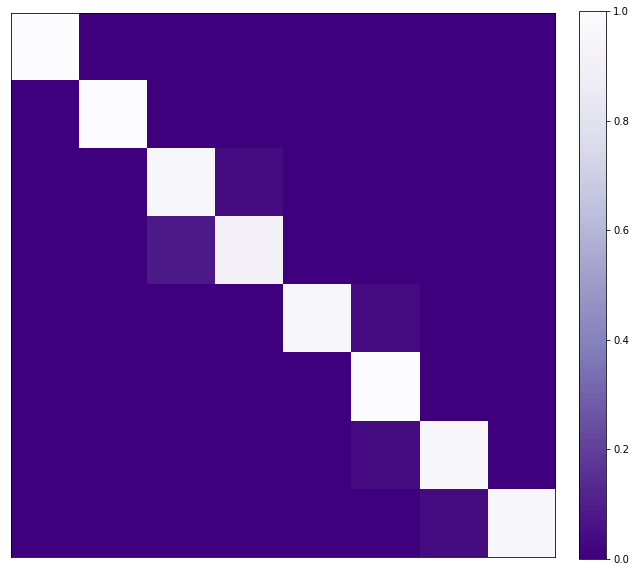

In [391]:
fig,ax=plt.subplots()
fig.set_size_inches(9,9)
fig.patch.set_facecolor('white')
fig.tight_layout()


#ax.set_title('Cohort: Linear Discriminant Analysis Confusion Matrix (Predicting Age)')

# We want to show all ticks...
'''ax.set_xticks(np.arange(len(ontogeny_groups)))
ax.set_yticks(np.arange(len(ontogeny_groups)))'''
# ... and label them with the respective list entries
'''ax.set_xticklabels(ontogeny_groups)
ax.set_yticklabels(ontogeny_groups)'''
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#ax.set_ylabel('input age (days)')
#ax.set_xlabel('output age (days)')
ax.set_xticks([])
ax.set_yticks([])

wefww=ax.imshow(return_confusion(lda_regress_predictions),cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)


plt.show()

fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix.pdf', bbox_inches='tight')
fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix.png', bbox_inches='tight')

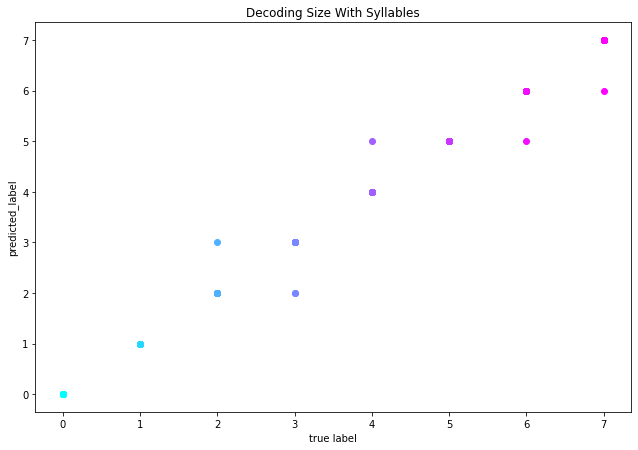

In [392]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(len(lda_regress_predictions)):
    x=np.ones(len(lda_regress_predictions[i]))*i
    plt.scatter(x,lda_regress_predictions[i],color=ontogeny_color_mat2[i])
plt.xlabel('true label')
plt.ylabel('predicted_label')
plt.title('Decoding Age With Syllables')
plt.show()

fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix ontogeny.pdf', bbox_inches='tight')
fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix ontogeny.png', bbox_inches='tight')

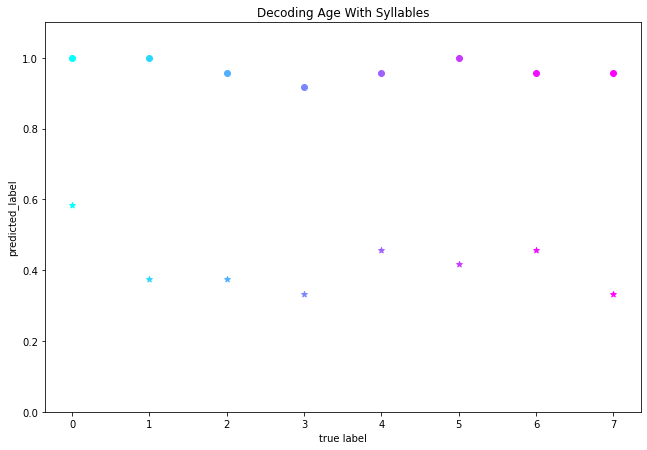

In [396]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

for i in range(len(lda_regress_predictions)):
    x=np.ones(len(lda_regress_predictions[i]))*i
    plt.scatter(1*i,sum(lda_regress_predictions[i]==i)/len(lda_regress_predictions[i]),color=ontogeny_color_mat2[i])
    
    
for i in range(len(ssoooooooooo)):
    x=np.ones(len(ssoooooooooo[i]))*i
    plt.scatter(1*i,sum(ssoooooooooo[i]==i)/len(ssoooooooooo[i]),marker='*',color=ontogeny_color_mat2[i])
    
    
plt.xlabel('true label')
plt.ylabel('predicted_label')
plt.title('Decoding Age With Syllables')
plt.ylim([0,1.1])
plt.show()

fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix ontogeny scalars and syllables.pdf', bbox_inches='tight')
fig.savefig(strain + ' Linear Discriminant Analysis Confusion Matrix ontogeny scalars and syllables.png', bbox_inches='tight')

In [394]:
ssoooooooooo

array([[0, 3, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 1, 1, 0, 0, 3, 4, 0, 0, 1, 1,
        0, 3],
       [0, 0, 0, 1, 0, 1, 3, 4, 2, 3, 0, 3, 1, 2, 1, 2, 1, 1, 1, 3, 2, 1,
        1, 0],
       [3, 3, 2, 4, 2, 4, 1, 4, 3, 2, 3, 1, 4, 4, 2, 2, 3, 3, 2, 2, 2, 2,
        3, 3],
       [2, 3, 4, 2, 1, 3, 1, 3, 3, 2, 3, 4, 1, 4, 3, 1, 1, 3, 1, 2, 2, 4,
        4, 3],
       [3, 4, 2, 4, 4, 5, 3, 4, 2, 4, 4, 5, 5, 4, 5, 4, 4, 3, 5, 3, 4, 2,
        4, 3],
       [5, 7, 4, 6, 7, 7, 4, 5, 7, 5, 6, 5, 6, 5, 7, 7, 5, 5, 5, 5, 5, 7,
        4, 6],
       [6, 7, 7, 5, 6, 5, 7, 5, 7, 7, 6, 6, 6, 6, 7, 6, 6, 6, 5, 6, 7, 7,
        5, 6],
       [5, 6, 6, 7, 7, 6, 7, 7, 4, 5, 6, 5, 6, 5, 5, 6, 2, 7, 7, 5, 6, 6,
        7, 7]])

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(9,9)
fig.patch.set_facecolor('white')
fig.tight_layout()


#ax.set_title('Cohort: Logistic Regression Confusion Matrix (Predicting Age)')

# We want to show all ticks...
'''ax.set_xticks(np.arange(len(cohort_labels)))
ax.set_yticks(np.arange(len(cohort_labels)))'''
# ... and label them with the respective list entries
'''ax.set_xticklabels(cohort_labels)
ax.set_yticklabels(cohort_labels)'''
# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

#ax.set_ylabel('input age (days)')
#ax.set_xlabel('output age (days)')

wefww=ax.imshow(return_confusion(log_regress_predictions),cmap=seqmatcolor)

plt.colorbar(wefww, ax=ax, fraction=.046,pad=.04)
ax.set_xticks([])
ax.set_yticks([])

plt.show()

fig.savefig(strain + ' Logistic Regression Confusion Matrix ontogeny scalars.pdf', bbox_inches='tight')
fig.savefig(strain + ' Logistic Regression Confusion Matrix ontogeny scalars.png', bbox_inches='tight')

In [ ]:
ontogeny_color_mat2=['gold','orange','sandybrown','red','mediumvioletred','mediumorchid','indigo','black']

In [ ]:
#https://stackoverflow.com/questions/52910187/how-to-make-a-polygon-radar-spider-chart-in-python

In [ ]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarAxes(PolarAxes):

        name = 'radar'

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


data = [ontogeny_groups,
        ('Basecase', return_confusion(log_regress_predictions))]

N = len(data[0])
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)
title, case_data = data[0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.99, bottom=0.01)


#ax.set_title(title,  position=(0.5, 1.3), ha='center')

for i in range(len(case_data)):
    line = ax.plot(theta, case_data[i],ontogeny_color_mat2_hex[i],alpha=0.1,zorder=2.5)
    ax.fill(theta, case_data[i], ontogeny_color_mat2_hex[i], alpha=0.8,zorder=2.5)
ax.set_varlabels(spoke_labels)
ax.set_varlabels([])
ax.set_ylim(0,1)
ax.grid(color='white',zorder=.1)
ax.set_facecolor('dimgrey')
ax.set_rgrids([0.2, 0.4, 0.6, 0.8],fontsize=0,color='white')
plt.show()

fig.savefig(strain + ' Logistic Regression Ontogeny Radar Chart Matplotlib scalars.pdf', bbox_inches='tight')
fig.savefig(strain + ' Logistic Regression Ontogeny Radar Chart Matplotlib scalars.png', bbox_inches='tight')


In [ ]:
data = [ontogeny_groups,
        ('Basecase', return_confusion(lda_regress_predictions))]

N = len(data[0])
theta = radar_factory(N, frame='polygon')

spoke_labels = data.pop(0)
title, case_data = data[0]

fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(top=0.99, bottom=0.01)


#ax.set_title(title,  position=(0.5, 1.3), ha='center')

for i in range(len(case_data)):
    line = ax.plot(theta, case_data[i],ontogeny_color_mat2_hex[i],alpha=0.1,zorder=2.5)
    ax.fill(theta, case_data[i], ontogeny_color_mat2_hex[i], alpha=0.8,zorder=2.5)
ax.set_varlabels(spoke_labels)
ax.set_varlabels([])
ax.set_ylim(0,1)
ax.grid(color='white',zorder=.1)
ax.set_facecolor('dimgrey')
ax.set_rgrids([0.2, 0.4, 0.6, 0.8],fontsize=0,color='white')
plt.show()

fig.savefig(strain + ' Linear Discriminant Analysis Ontogeny Radar Chart Matplotlib scalars.pdf', bbox_inches='tight')
fig.savefig(strain + ' Linear Discriminant Analysis Ontogeny Radar Chart Matplotlib scalars.png', bbox_inches='tight')

## CLUSTERING MOUSE TRAJECTORIES

/Users/rockwell/miniconda/envs/mo3/lib/python3.7/site-packages/seaborn/matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


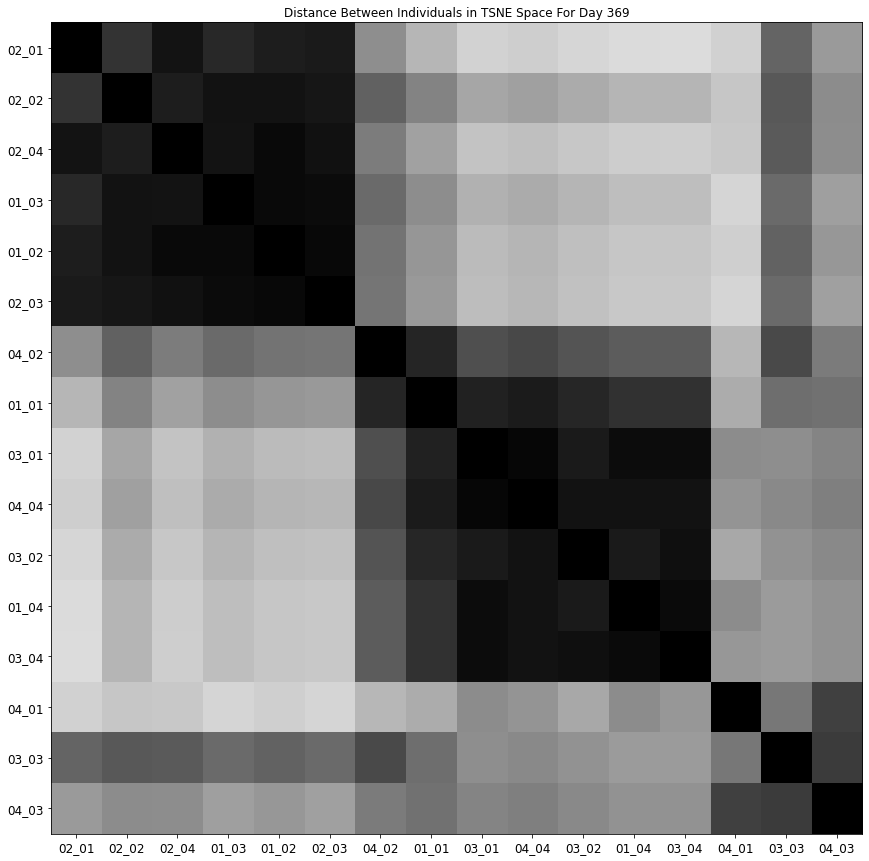

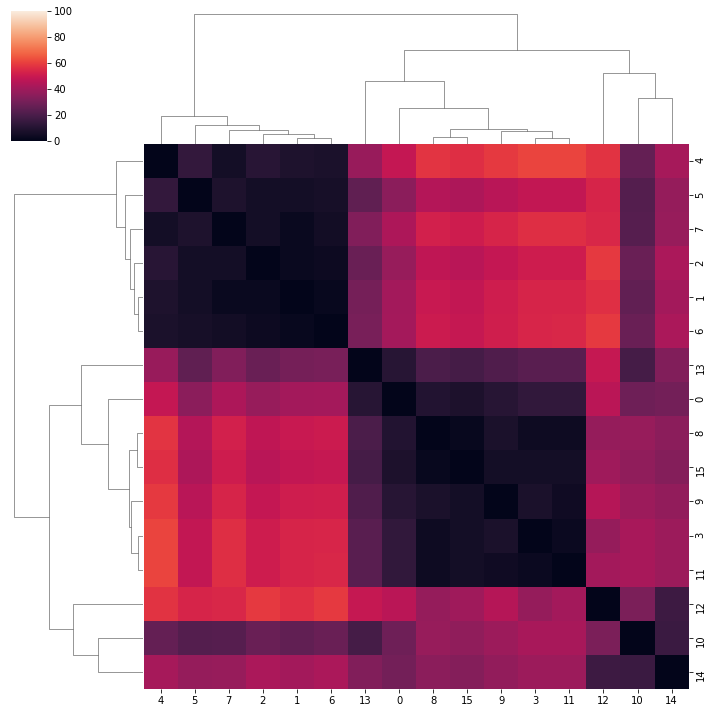

In [218]:
day=50

#at day=50 order of the grouped cages by cluster map = o (empriaclly calculated)
o=np.array([4,5,7,2,1,6,13,0,8,15,9,3,11,12,10,14])

sort_by_day_x=True

fig,ax=plt.subplots()
fig.set_size_inches(12,12)
fig.patch.set_facecolor('white')
fig.tight_layout()


tsne_dist=np.zeros((len(male_filled_x),len(male_filled_x)))
plt.title('Distance Between Individuals in TSNE Space For Day ' + str(male_age_labels_int[day]))
for i in range(len(male_filled_x)):
    for j in range(len(male_filled_x)):

        x1=male_filled_x[i][day]
        if math.isnan(x1):

            for k in range(30):
                try:
                    x1=male_filled_x[i][day+k]
                    if not math.isnan(x1):
                        break
                except:
                    pass
        if math.isnan(x1):

            for k in range(20):
                try:
                    x1=male_filled_x[i][day-k]
                    if not math.isnan(x1):
                        break
                except:
                    pass



        x2=male_filled_x[j][day]
        if math.isnan(x2):

            for k in range(30):
                try:
                    x2=male_filled_x[j][day+k]
                    if not math.isnan(x2):
                        break
                except:
                    pass
        if math.isnan(x2):

            for k in range(30):
                try:
                    x2=male_filled_x[j][day-k]
                    if not math.isnan(x2):
                        break
                except:
                    pass



        y1=male_filled_y[i][day]

        if math.isnan(y1):

            for k in range(30):
                try:
                    y1=male_filled_y[i][day+k]
                    if not math.isnan(y1):
                        break
                except:
                    pass
        if math.isnan(y1):

            for k in range(30):
                try:
                    y1=male_filled_y[i][day-k]
                    if not math.isnan(y1):
                        break
                except:
                    pass



        y2=male_filled_y[j][day]
        if math.isnan(y2):

            for k in range(30):
                try:
                    y2=male_filled_y[j][day+k]
                    if not math.isnan(y2):
                        break
                except:
                    pass
        if math.isnan(y2):

            for k in range(30):
                try:
                    y2=male_filled_y[j][day-k]
                    if not math.isnan(y2):
                        break
                except:
                    pass



        try:
            xdiff=x2-x1
            ydiff=y2-y1
            diff=(xdiff**2)**.5 + (ydiff**2)**.5
            tsne_dist[i,j]=diff
        except:
            print('huh')

    ax.set_xticks(np.arange(len(unique_individual_longtogeny_males)))
    ax.set_yticks(np.arange(len(unique_individual_longtogeny_males)))

    if not sort_by_day_x:
        ax.set_xticklabels(list(np.array(unique_individual_longtogeny_males)),fontsize=12)
        ax.set_yticklabels(list(np.array(unique_individual_longtogeny_males)),fontsize=12)

    if sort_by_day_x:
        ax.set_xticklabels(list(np.array(unique_individual_longtogeny_males)[o]),fontsize=12)
        ax.set_yticklabels(list(np.array(unique_individual_longtogeny_males)[o]),fontsize=12)


    if not sort_by_day_x:
        p2plot=plt.imshow(tsne_dist,cmap='Greys_r',vmax=80)

    if sort_by_day_x:
        p2plot=plt.imshow(tsne_dist[o][:,o],cmap='Greys_r',vmax=80)


personality_plot=sns.clustermap(tsne_dist,vmax=100,vmin=0)

if not sort_by_day_x:
    fig.savefig(strain + 'male_tsne_dist_sort_cage_' + str(day) + '.pdf', bbox_inches='tight')
    fig.savefig(strain + 'male_tsne_dist_sort_cage_' + str(day) + '.png', bbox_inches='tight')

if sort_by_day_x:

    fig.savefig(strain + 'male_tsne_dist_sort_last_day_' + str(day) + '.pdf', bbox_inches='tight')
    fig.savefig(strain + 'male_tsne_dist_sort_last_day_' + str(day) + '.png', bbox_inches='tight')


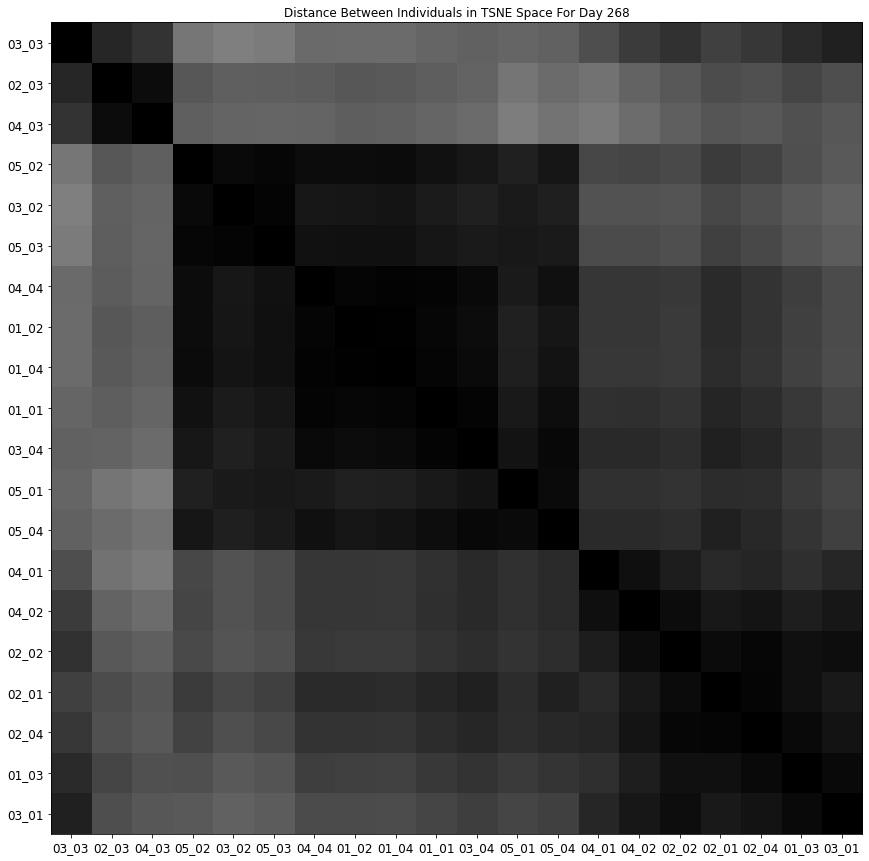

/Users/rockwell/miniconda/envs/mo3/lib/python3.7/site-packages/seaborn/matrix.py:630: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


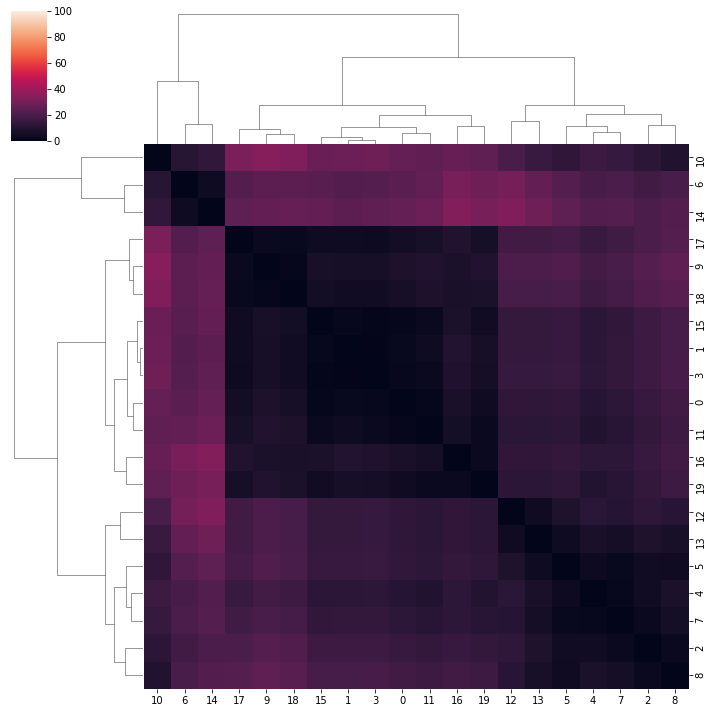

In [219]:
day=28
sort_by_day_x=True

#at day=25 order of the grouped cages by cluster map = o (empriaclly calculated)
o=[6,2,18,10,4,7,15,11,0,19,3,1,19,17,16,12,13,14,5,8]

#at day=28 order of the grouped cages by cluster map = o (empriaclly calculated)
o=[10,6,14,17,9,18,15,1,3,0,11,16,19,12,13,5,4,7,2,8]


fig,ax=plt.subplots()
fig.set_size_inches(12,12)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Distance Between Individuals in TSNE Space For Day ' + str(female_age_labels_int[day]))

tsne_dist=np.zeros((len(female_filled_x),len(female_filled_x)))
for i in range(len(female_filled_x)):
    for j in range(len(female_filled_x)):

        x1=female_filled_x[i][day]
        if math.isnan(x1):

            for k in range(30):
                try:
                    x1=female_filled_x[i][day+k]
                    if not math.isnan(x1):
                        break
                except:
                    pass
        if math.isnan(x1):

            for k in range(20):
                try:
                    x1=female_filled_x[i][day-k]
                    if not math.isnan(x1):
                        break
                except:
                    pass



        x2=female_filled_x[j][day]
        if math.isnan(x2):

            for k in range(30):
                try:
                    x2=female_filled_x[j][day+k]
                    if not math.isnan(x2):
                        break
                except:
                    pass
        if math.isnan(x2):

            for k in range(30):
                try:
                    x2=female_filled_x[j][day-k]
                    if not math.isnan(x2):
                        break
                except:
                    pass



        y1=female_filled_y[i][day]

        if math.isnan(y1):

            for k in range(30):
                try:
                    y1=female_filled_y[i][day+k]
                    if not math.isnan(y1):
                        break
                except:
                    pass
        if math.isnan(y1):

            for k in range(30):
                try:
                    y1=female_filled_y[i][day-k]
                    if not math.isnan(y1):
                        break
                except:
                    pass



        y2=female_filled_y[j][day]
        if math.isnan(y2):

            for k in range(30):
                try:
                    y2=female_filled_y[j][day+k]
                    if not math.isnan(y2):
                        break
                except:
                    pass
        if math.isnan(y2):

            for k in range(30):
                try:
                    y2=female_filled_y[j][day-k]
                    if not math.isnan(y2):
                        break
                except:
                    pass



        try:
            xdiff=x2-x1
            ydiff=y2-y1
            diff=(xdiff**2)**.5 + (ydiff**2)**.5
            tsne_dist[i,j]=diff
        except:
            print('huh')

ax.set_xticks(np.arange(len(unique_individual_longtogeny_females)))
ax.set_yticks(np.arange(len(unique_individual_longtogeny_females)))

if not sort_by_day_x:
    ax.set_xticklabels(list(np.array(unique_individual_longtogeny_females)),fontsize=12)
    ax.set_yticklabels(list(np.array(unique_individual_longtogeny_females)),fontsize=12)

if sort_by_day_x:
    ax.set_xticklabels(list(np.array(unique_individual_longtogeny_females)[o]),fontsize=12)
    ax.set_yticklabels(list(np.array(unique_individual_longtogeny_females)[o]),fontsize=12)


if not sort_by_day_x:
    plt.imshow(tsne_dist,cmap='Greys_r',vmax=80)

if sort_by_day_x:
    plt.imshow(tsne_dist[o][:,o],cmap='Greys_r',vmax=80)
plt.show()



personality_plot=sns.clustermap(tsne_dist,vmax=100,vmin=0)

if not sort_by_day_x:

    fig.savefig(strain + 'female_tsne_dist_sort_cage_' + str(day) + '.pdf', bbox_inches='tight')
    fig.savefig(strain + 'female_tsne_dist_sort_cage_' + str(day) + '.png', bbox_inches='tight')

if sort_by_day_x:

    fig.savefig(strain + 'female_tsne_dist_sort_last_day_' + str(day) + '.pdf', bbox_inches='tight')
    fig.savefig(strain + 'female_tsne_dist_sort_last_day_' + str(day) + '.png', bbox_inches='tight')
    fig.savefig("female_dbiits_day/{:04d}.png".format(day),bbox_inches='tight')




/Users/rockwell/miniconda/envs/mo3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  after removing the cwd from sys.path.


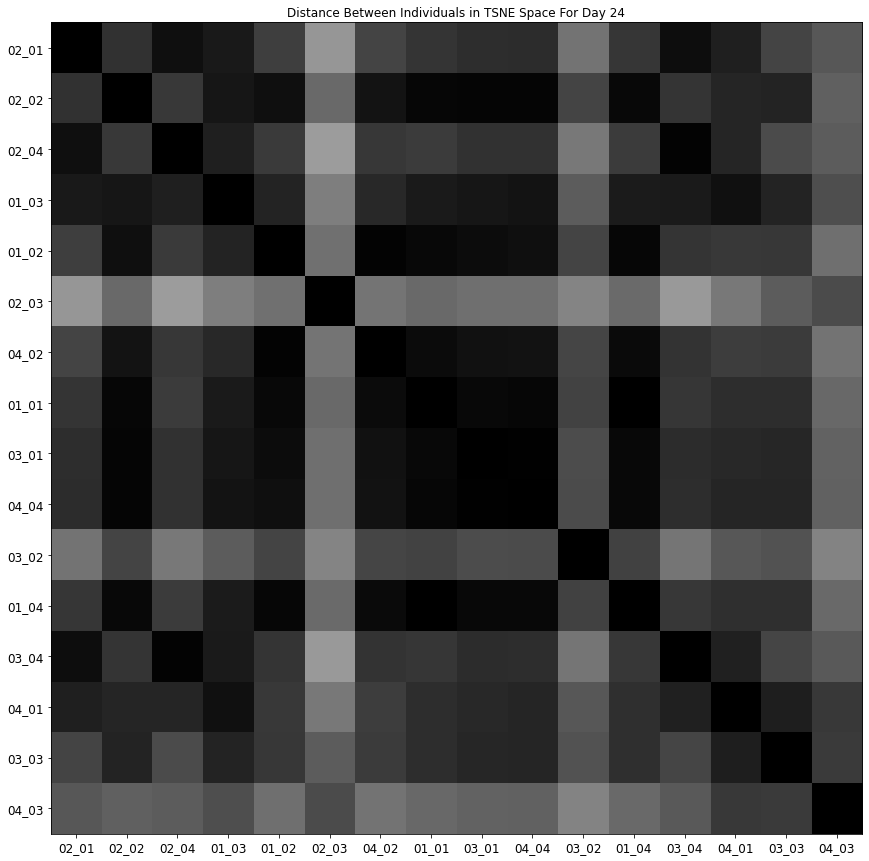

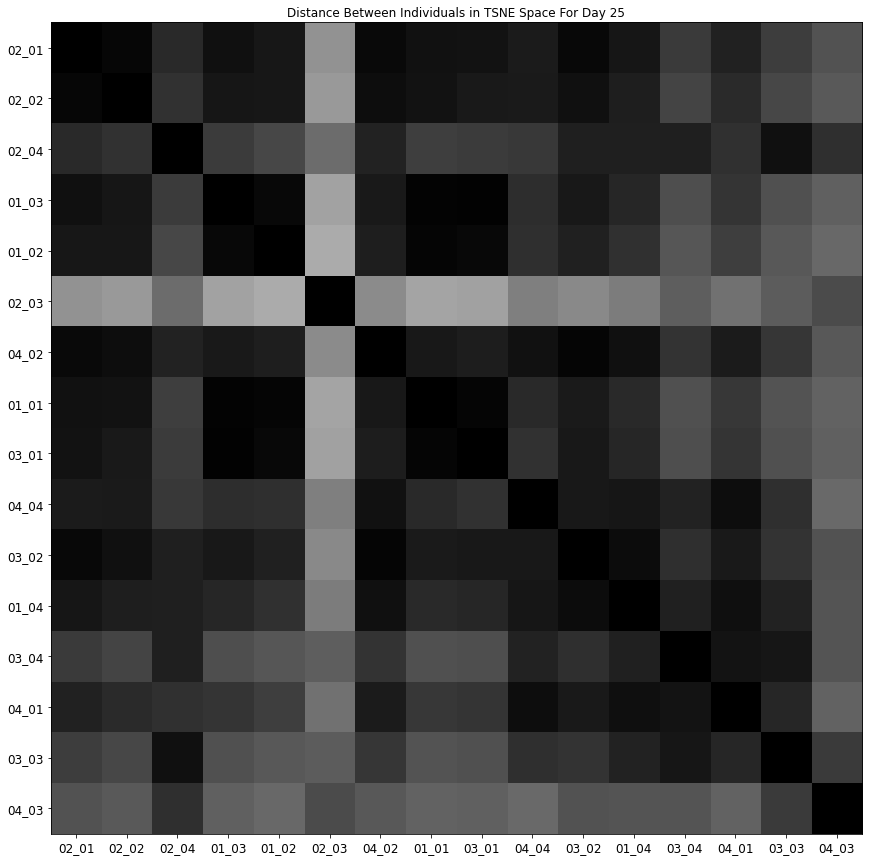

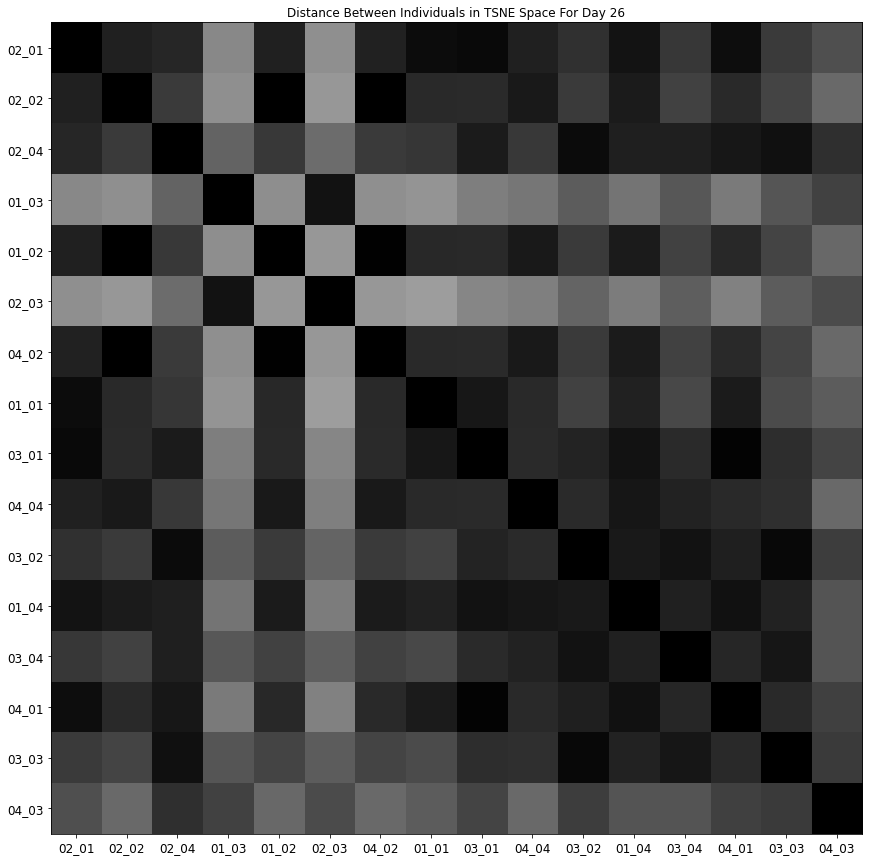

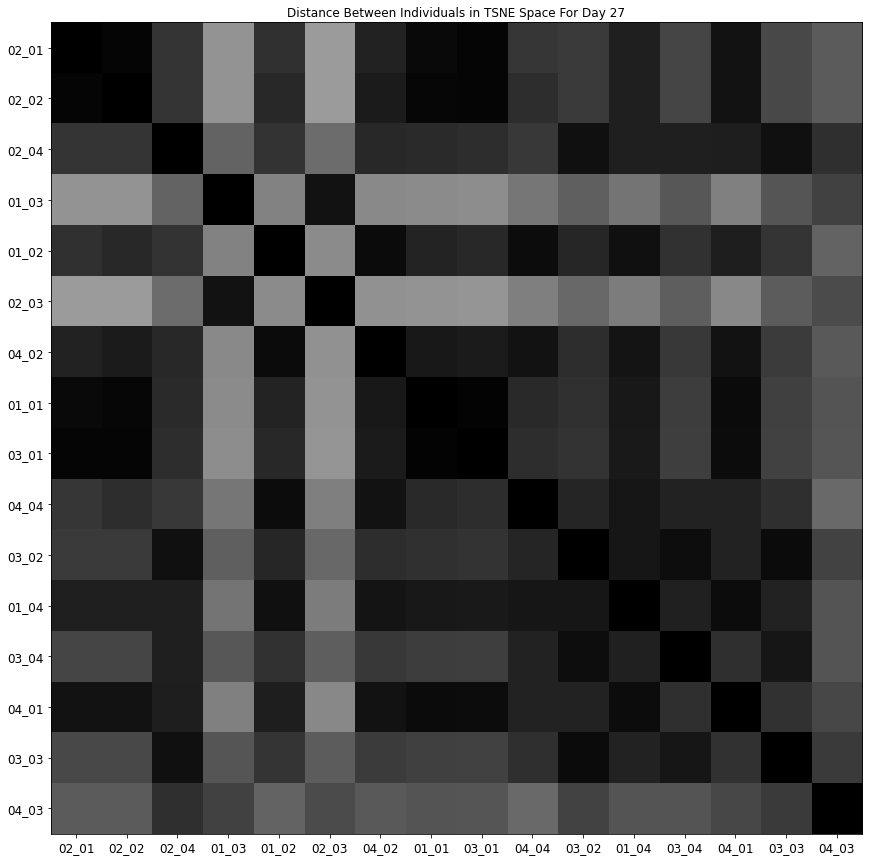

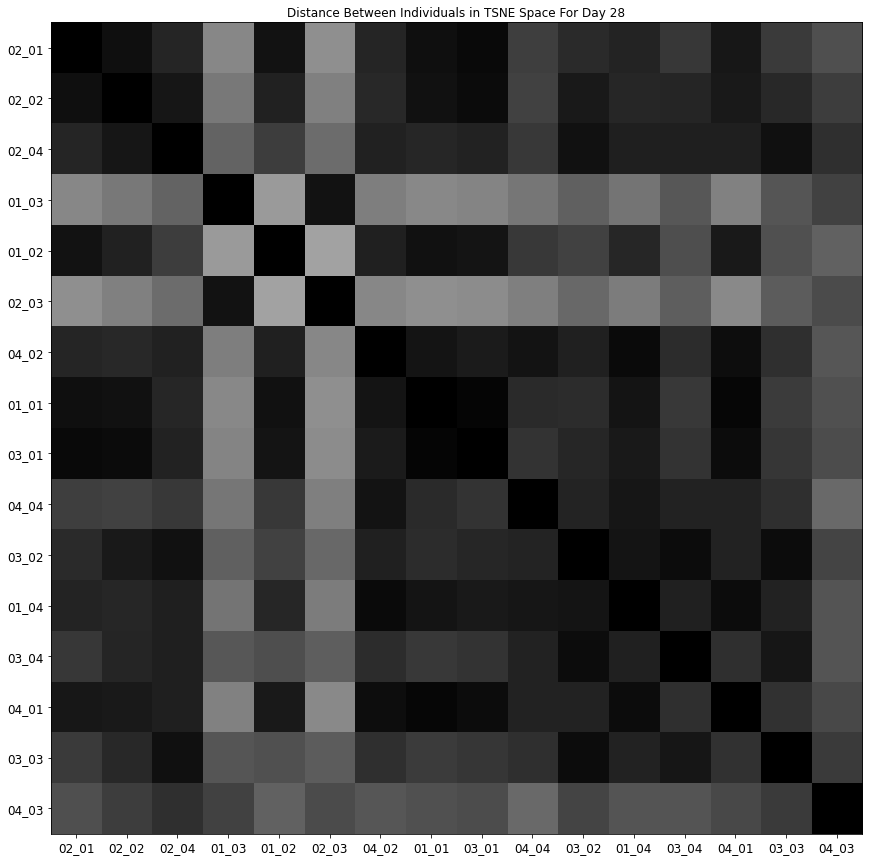

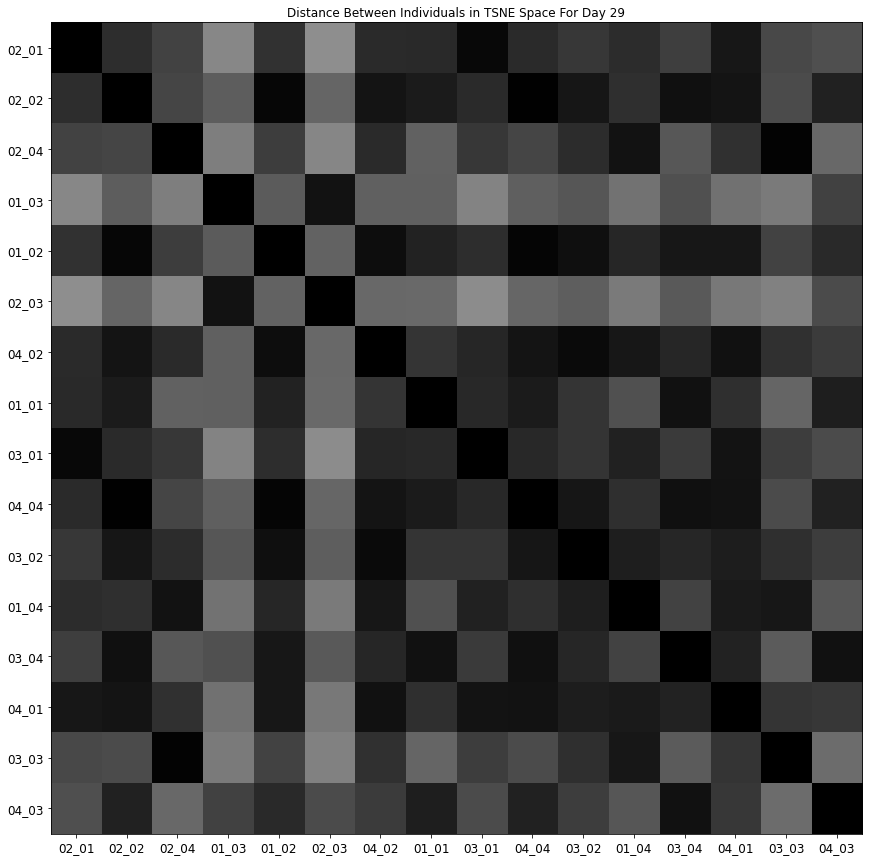

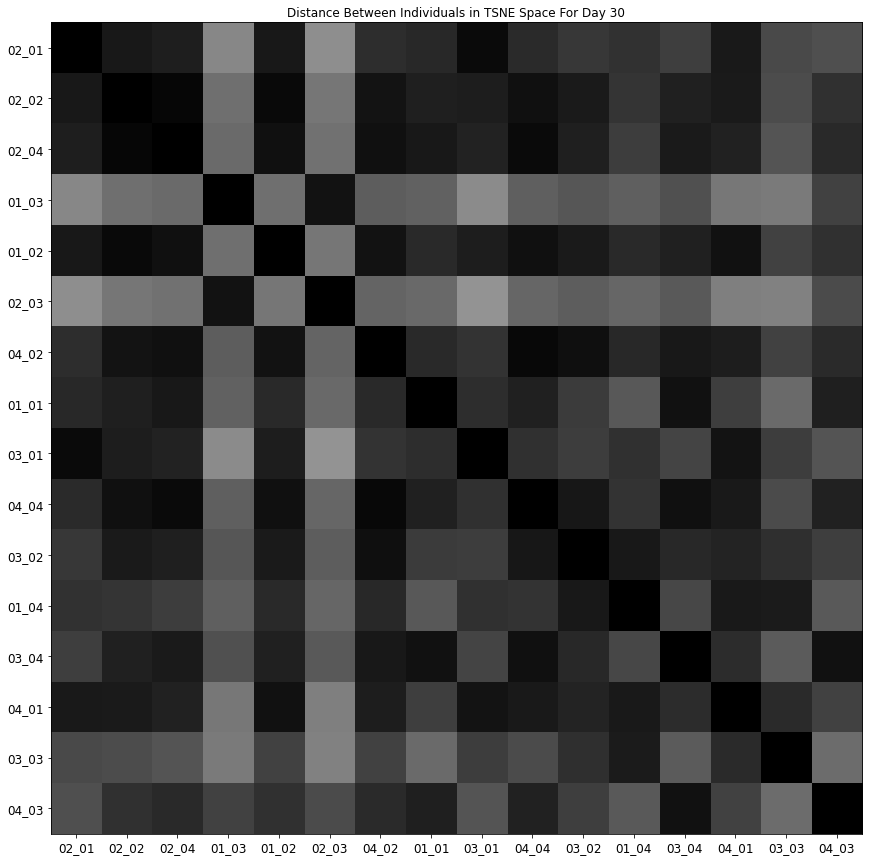

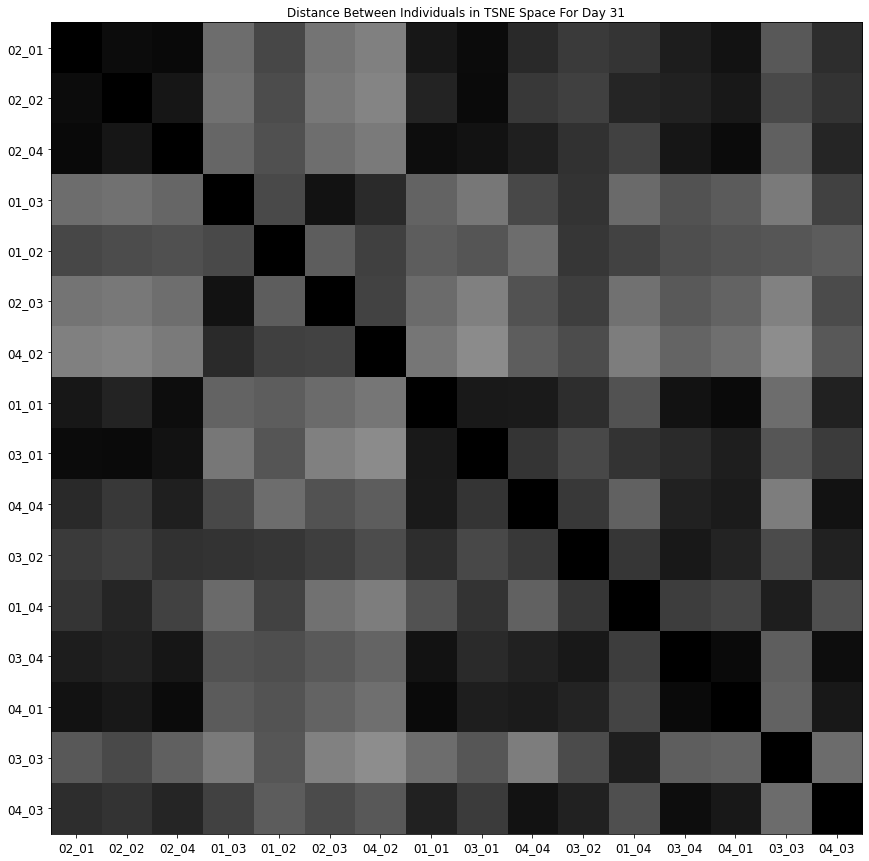

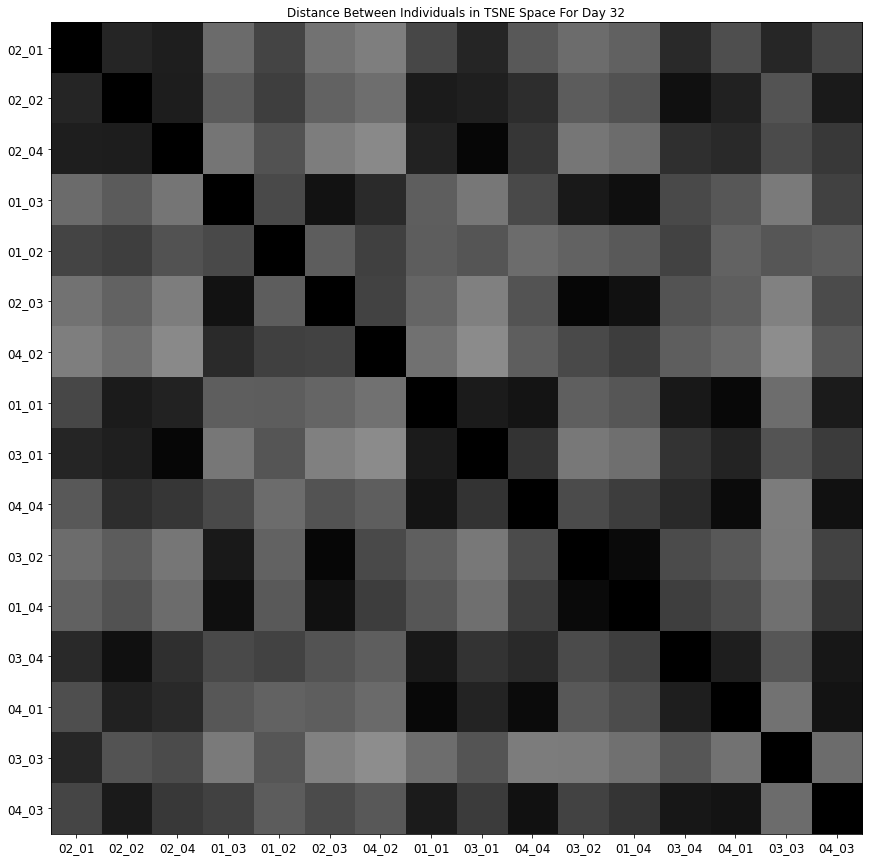

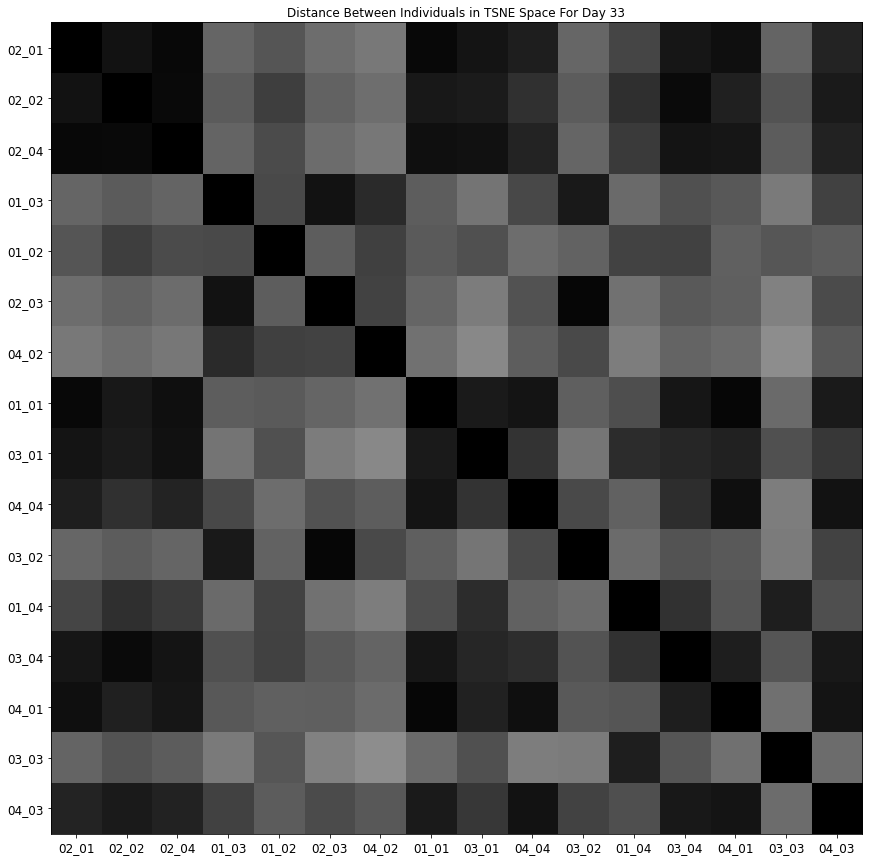

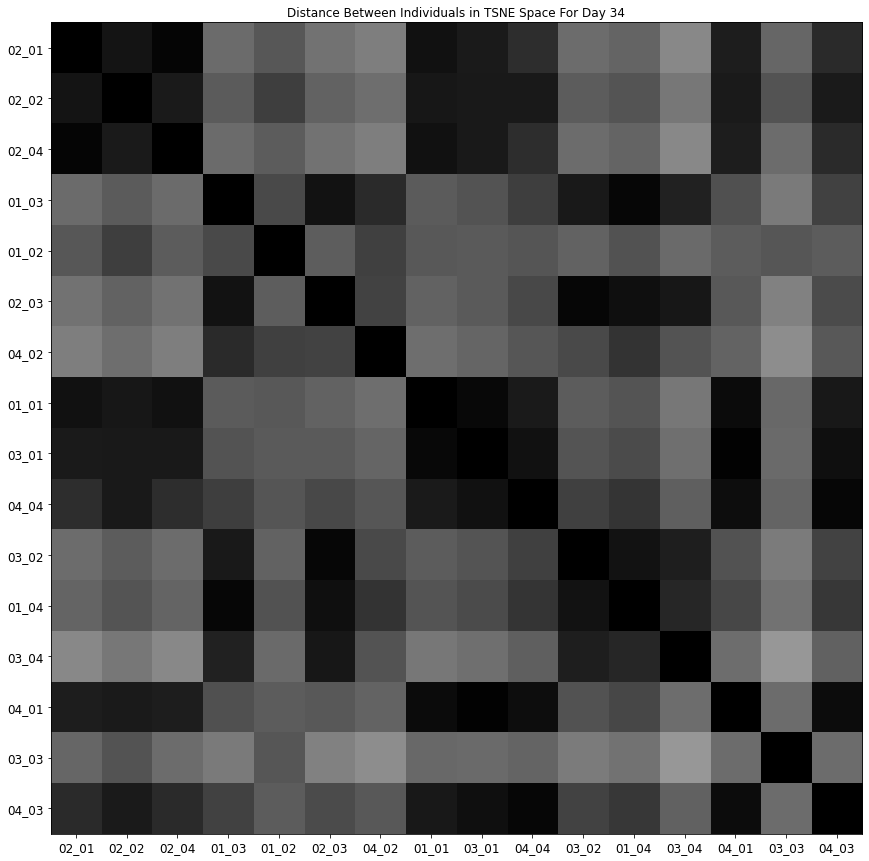

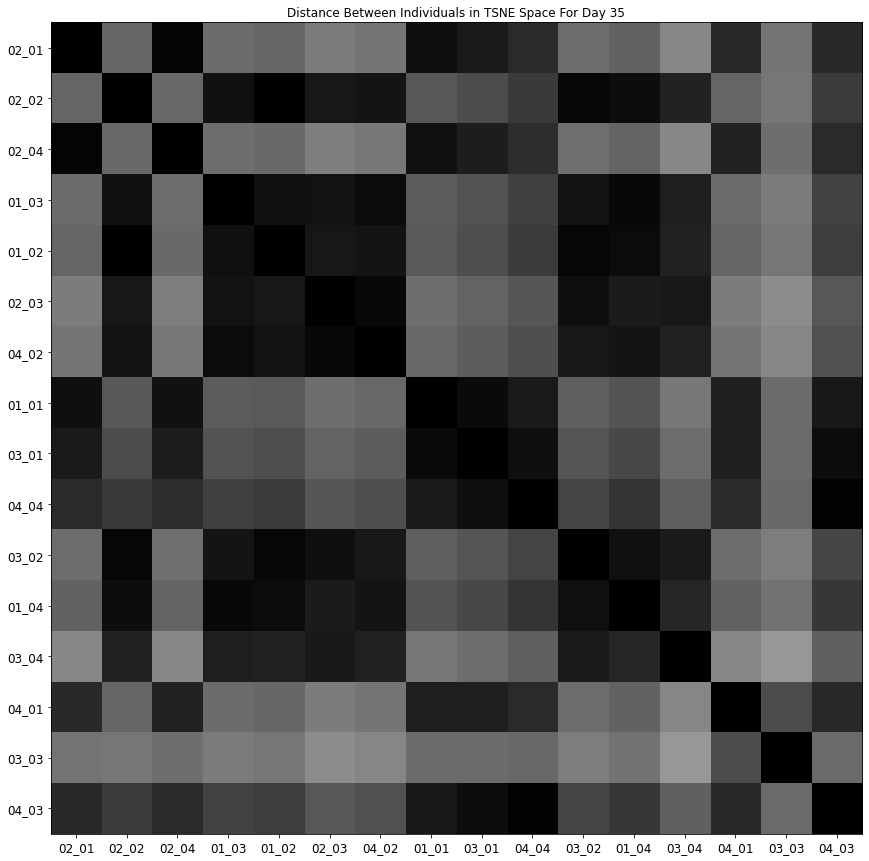

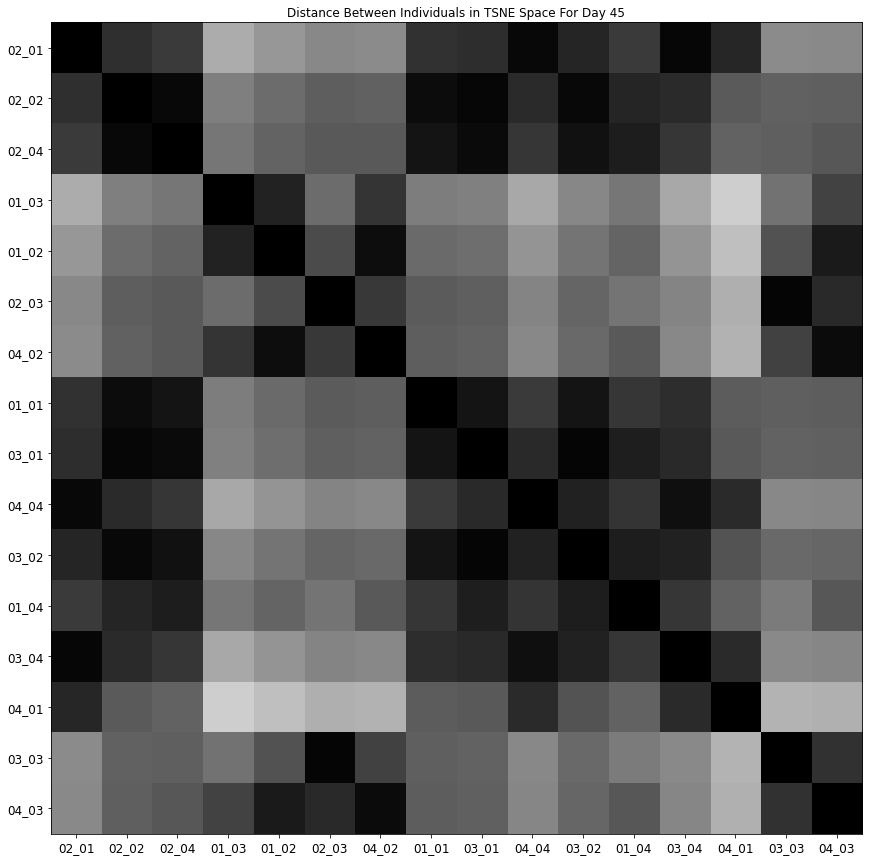

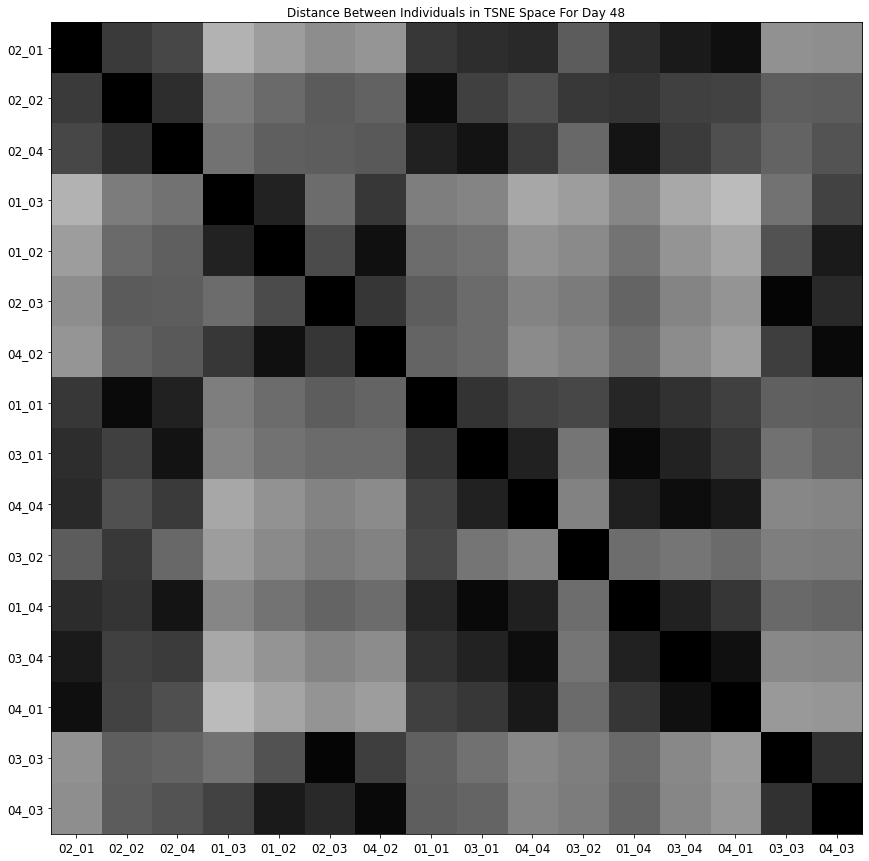

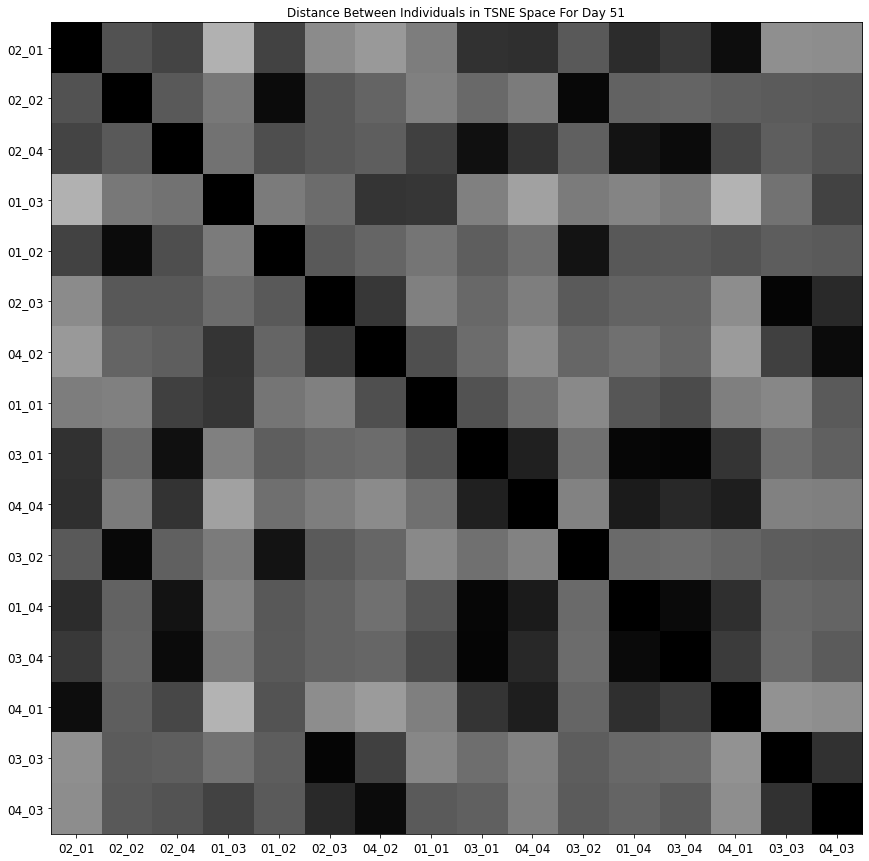

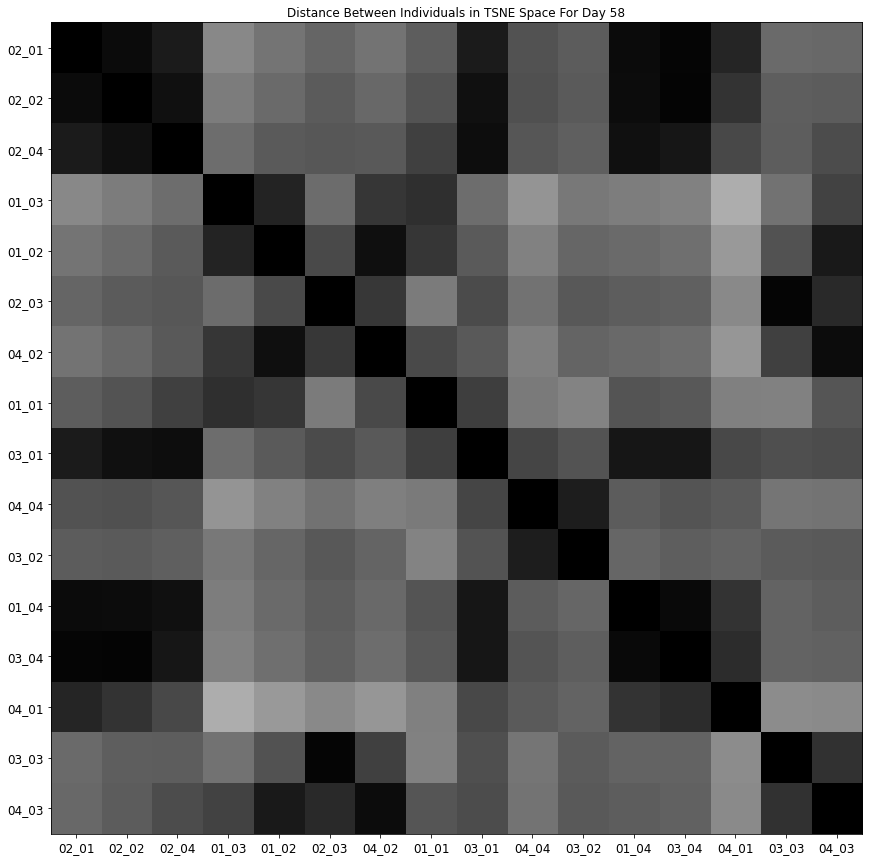

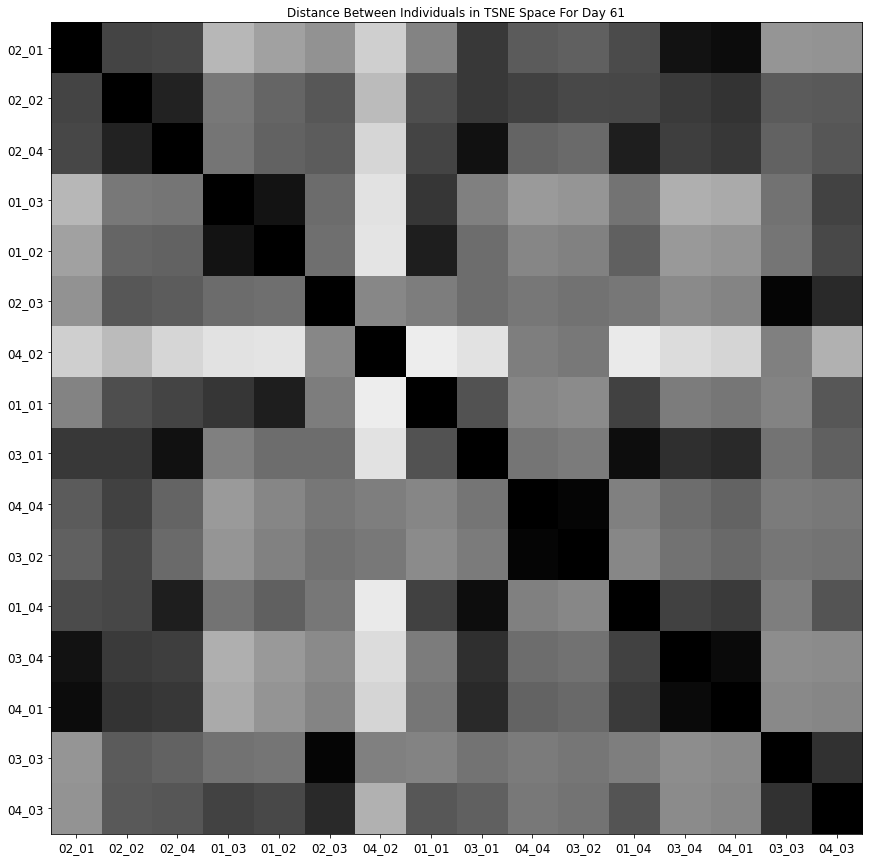

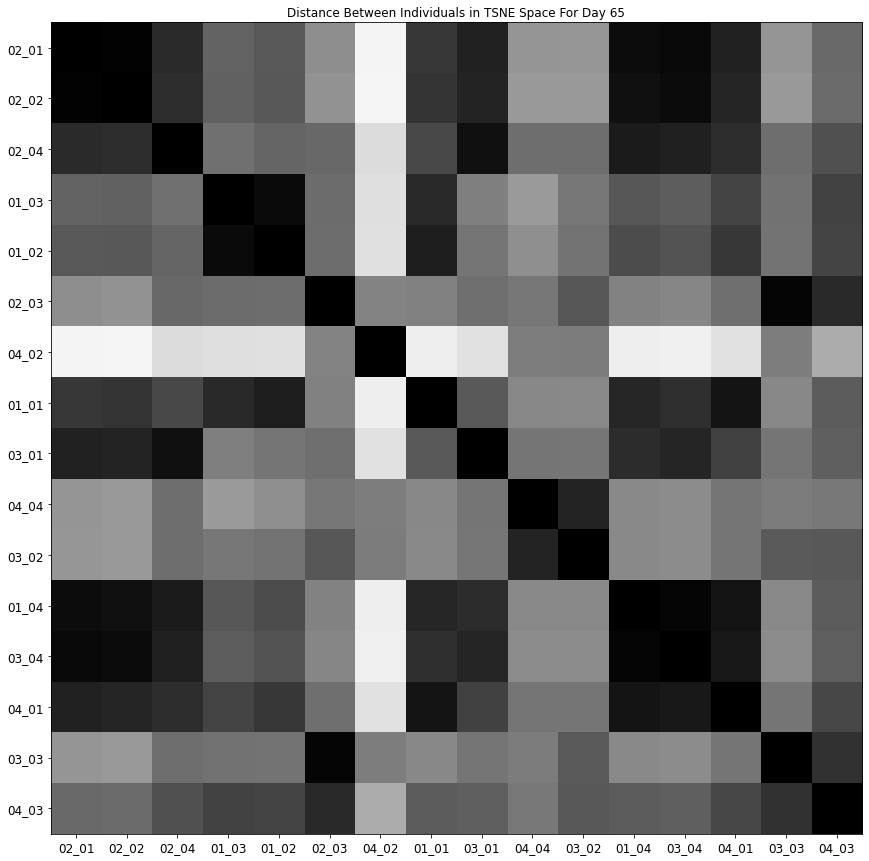

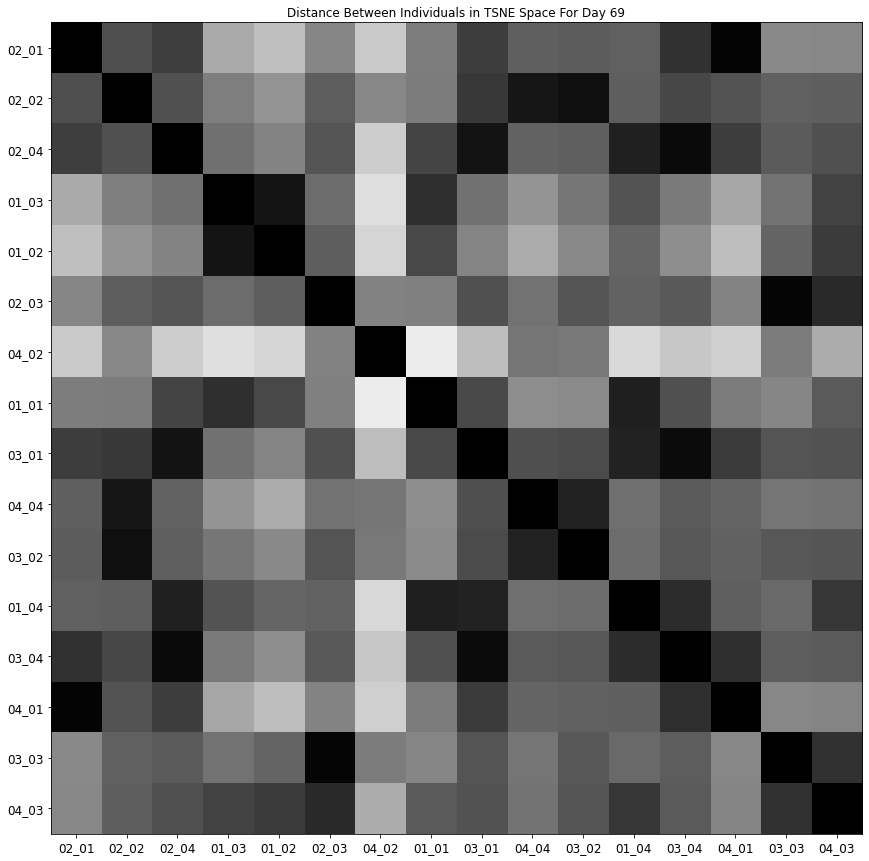

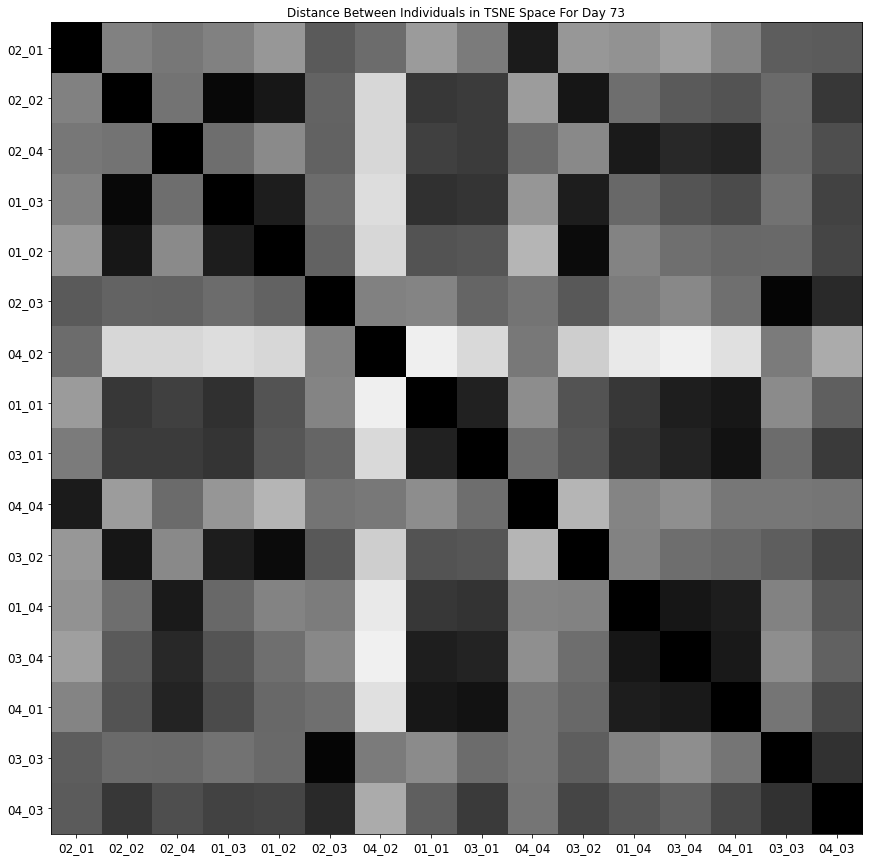

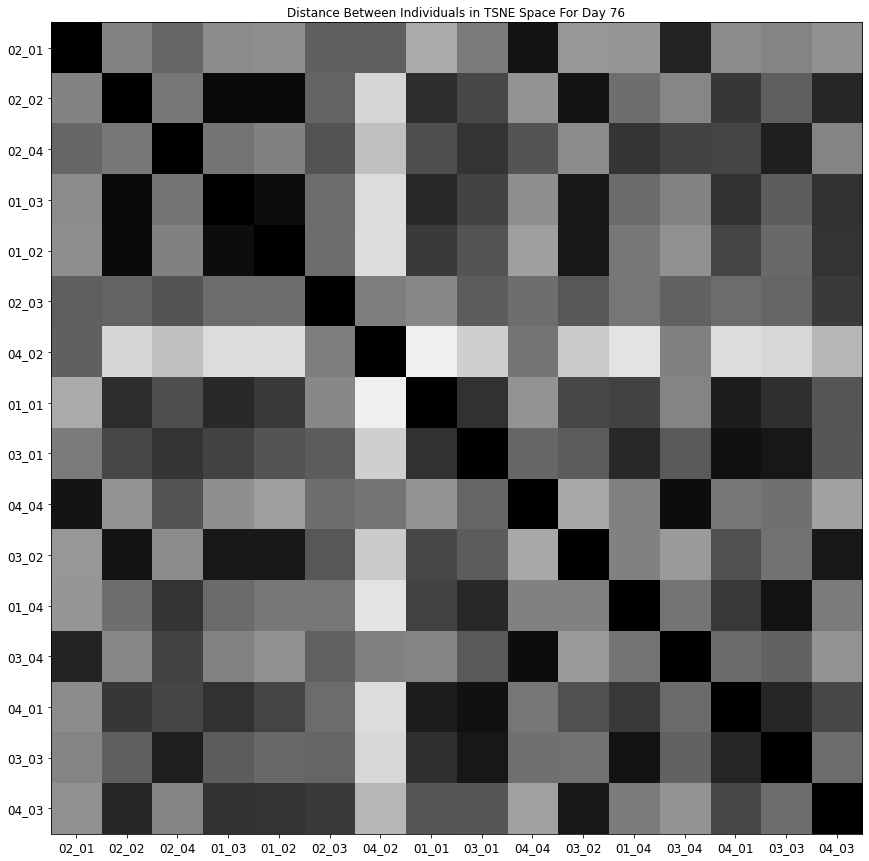

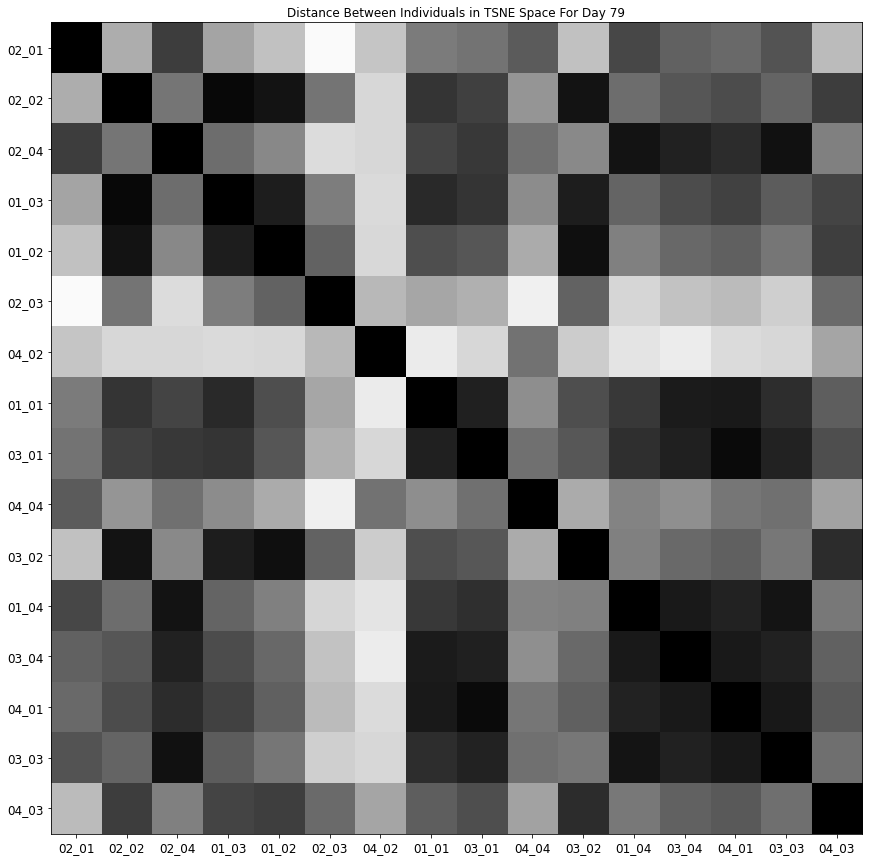

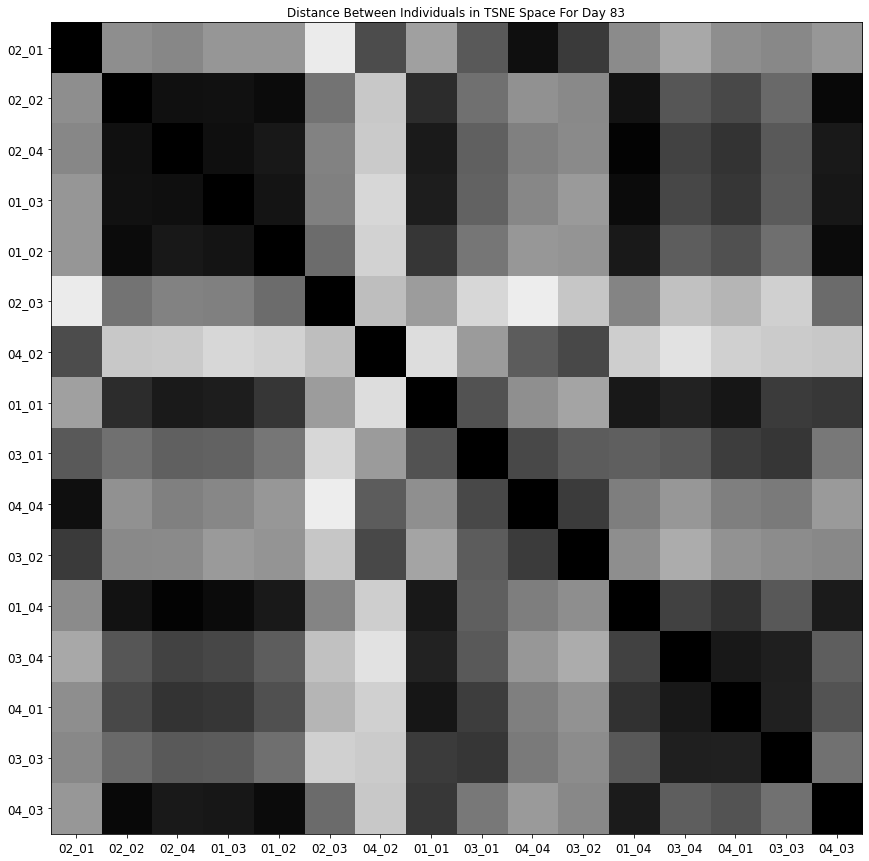

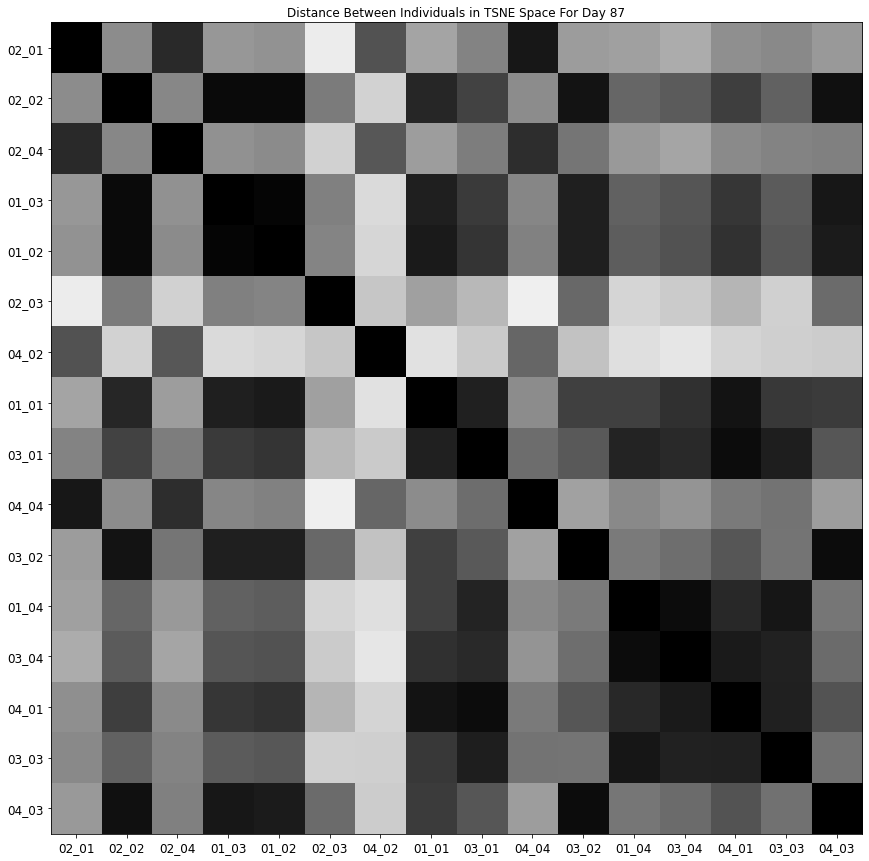

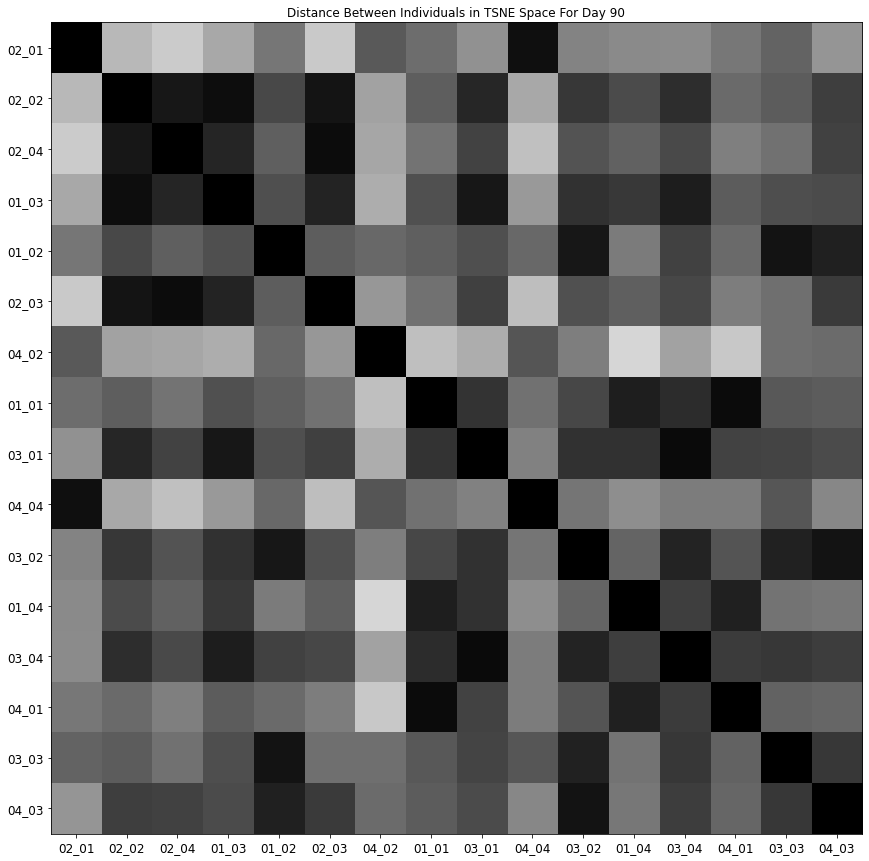

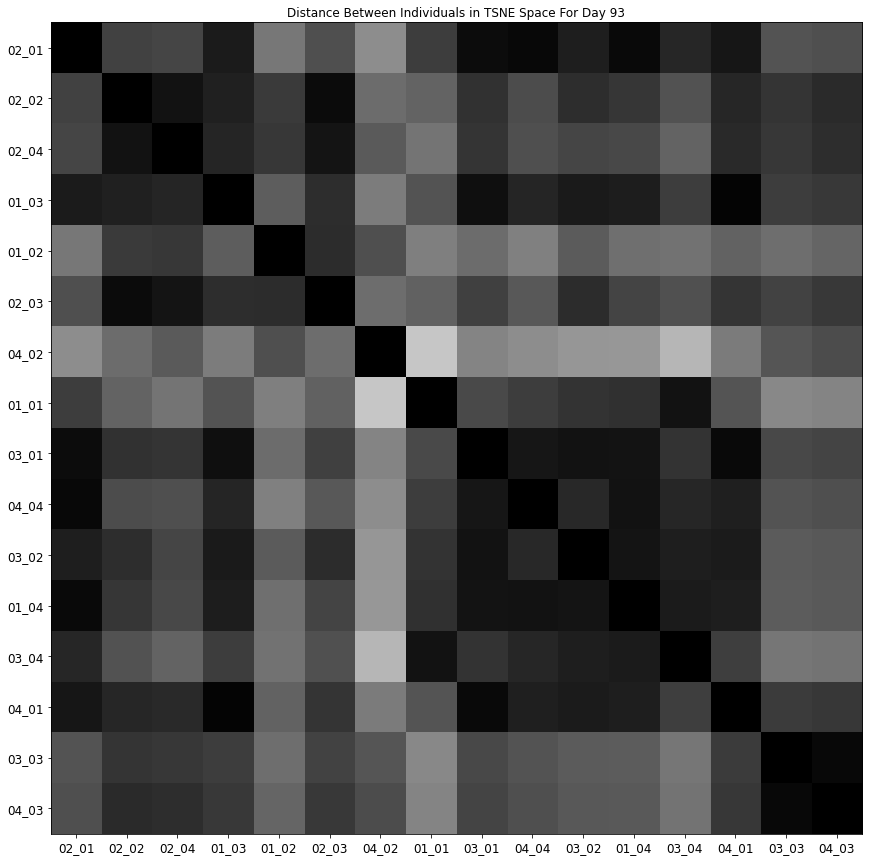

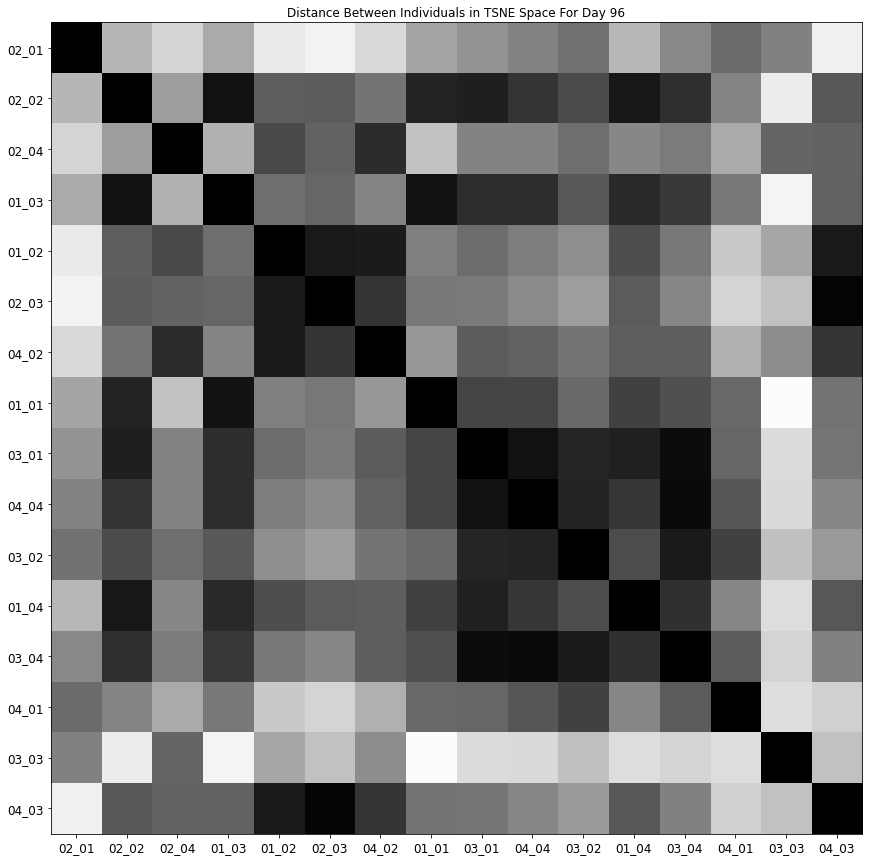

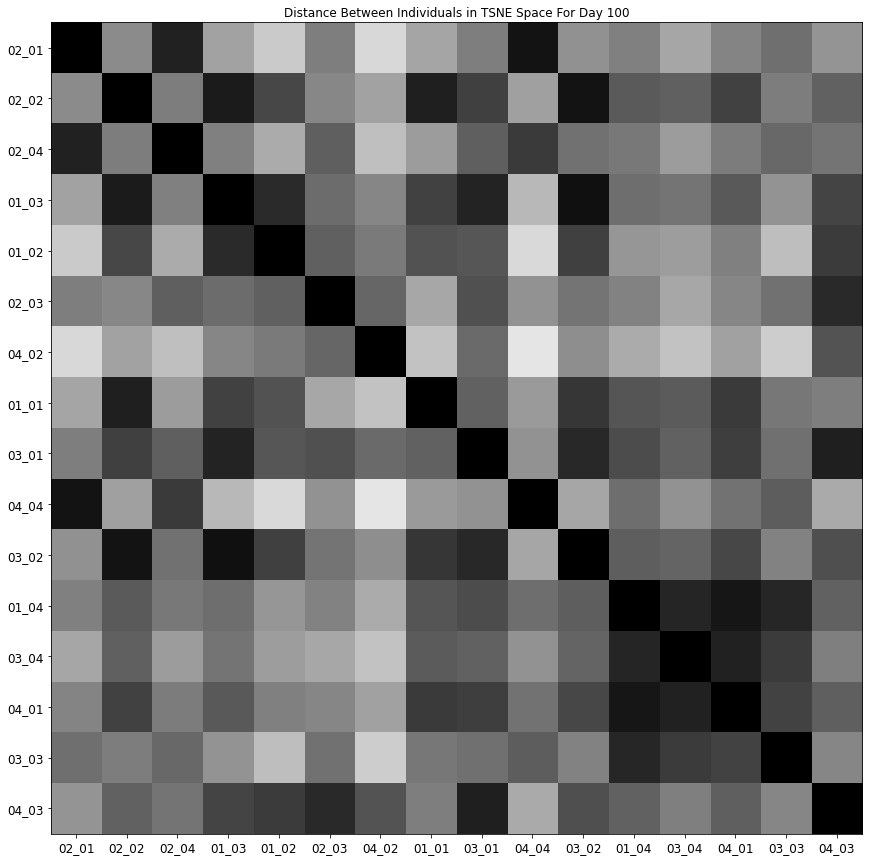

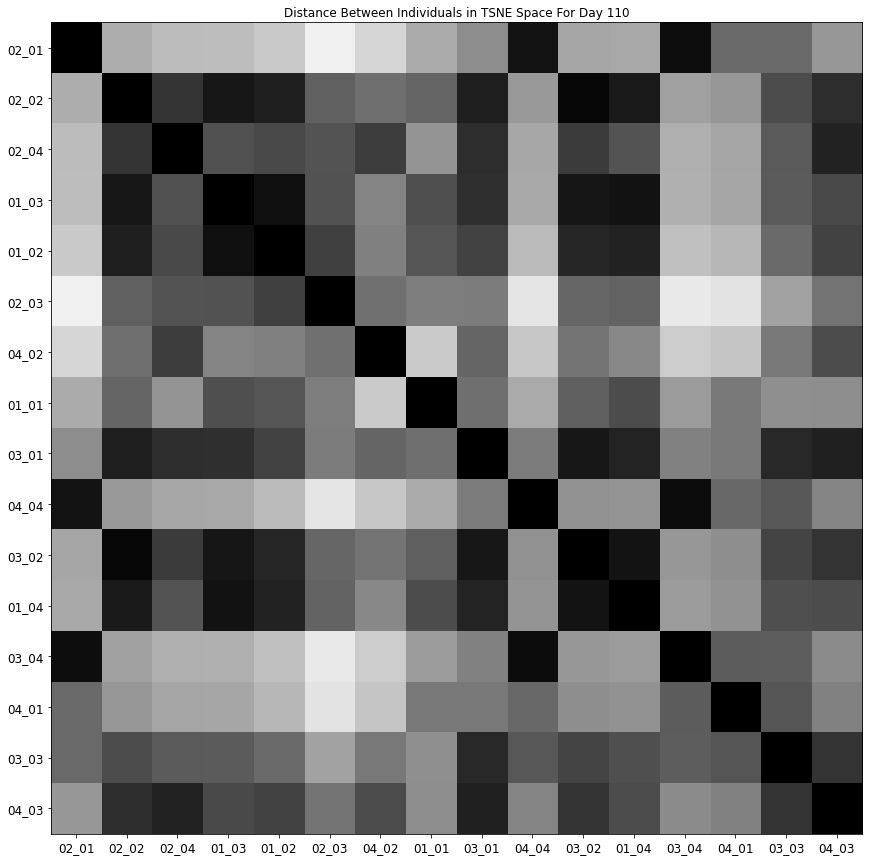

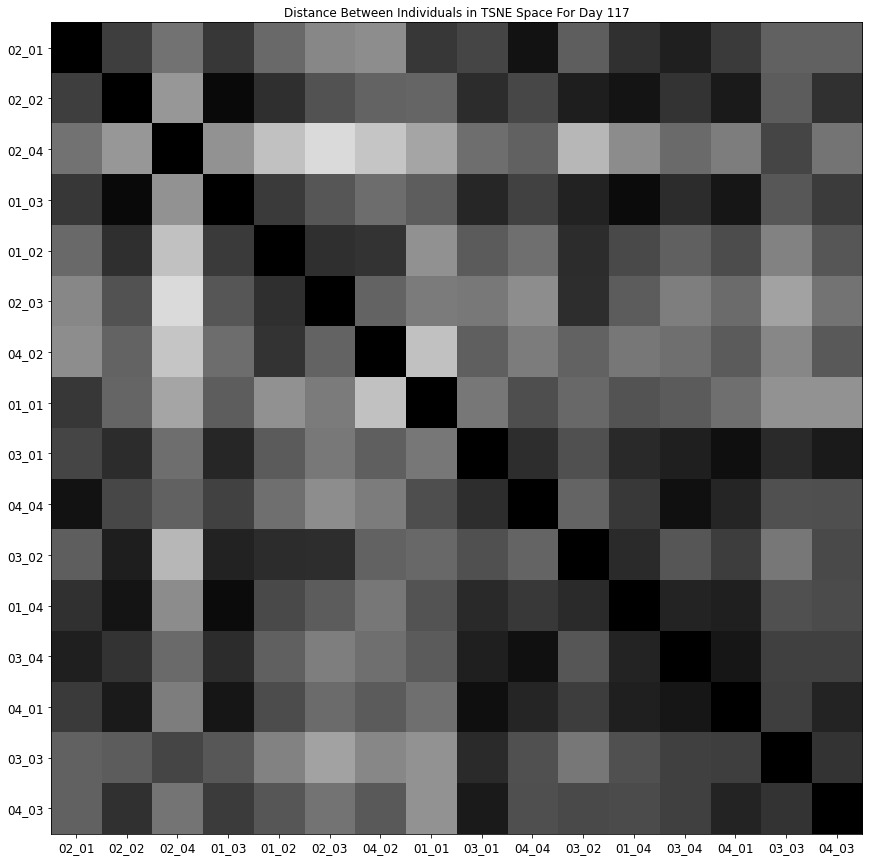

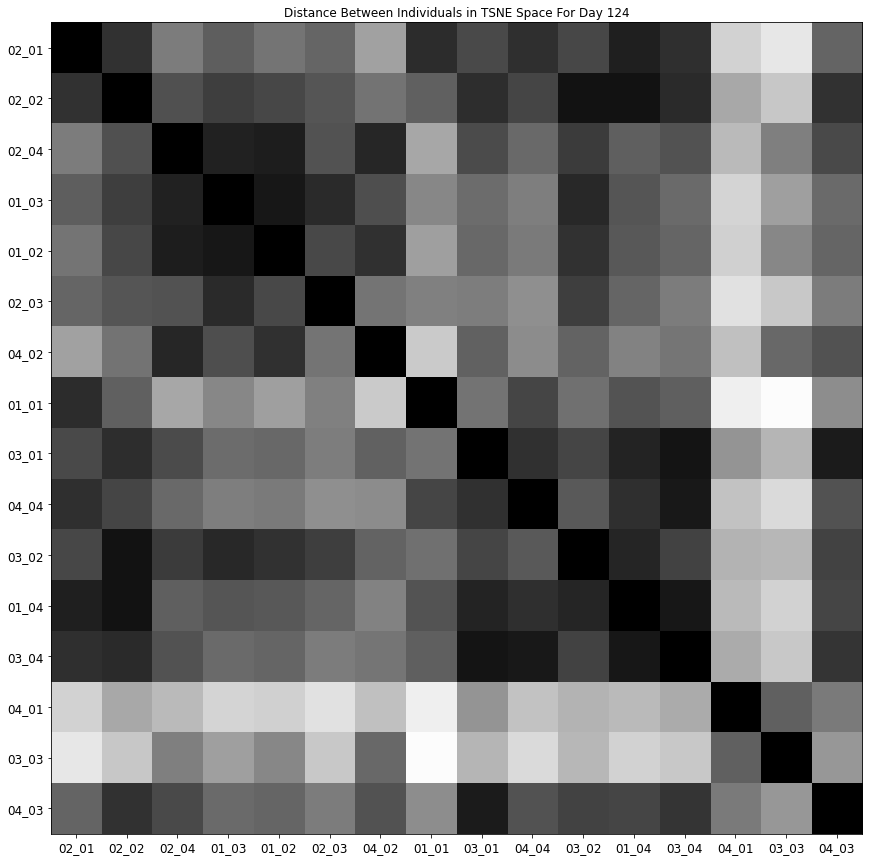

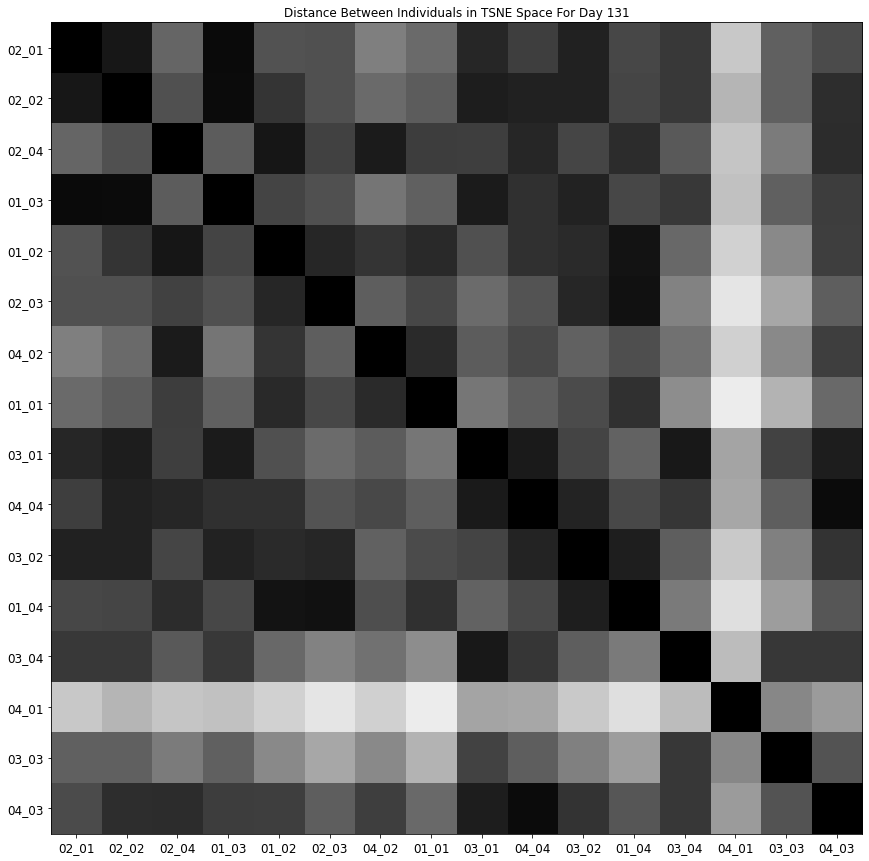

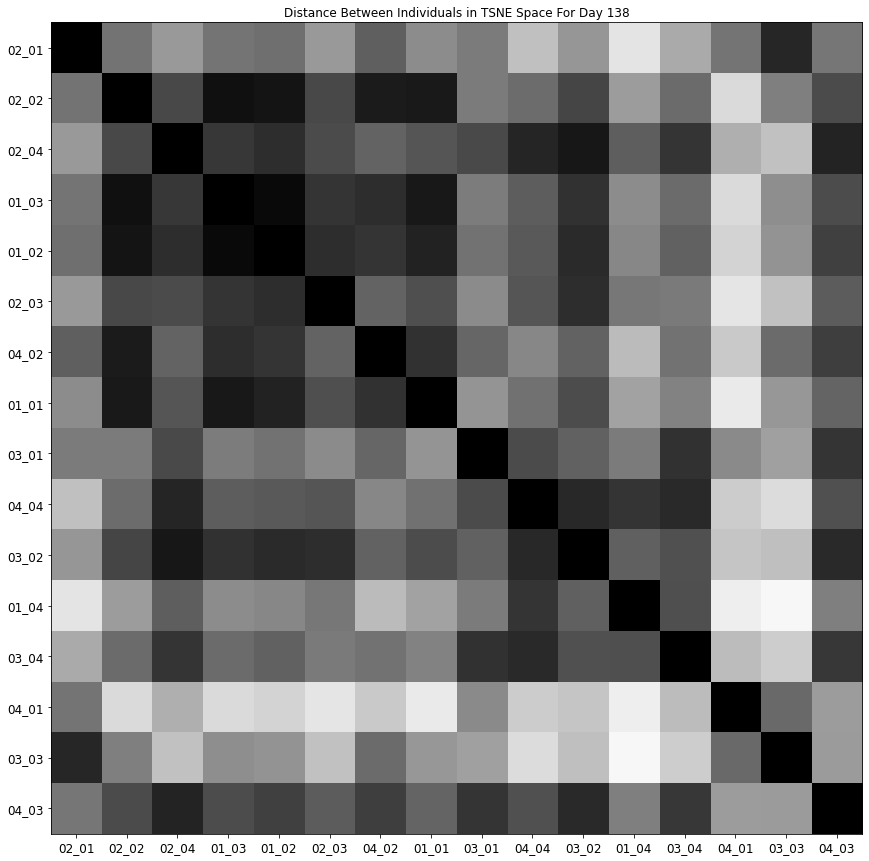

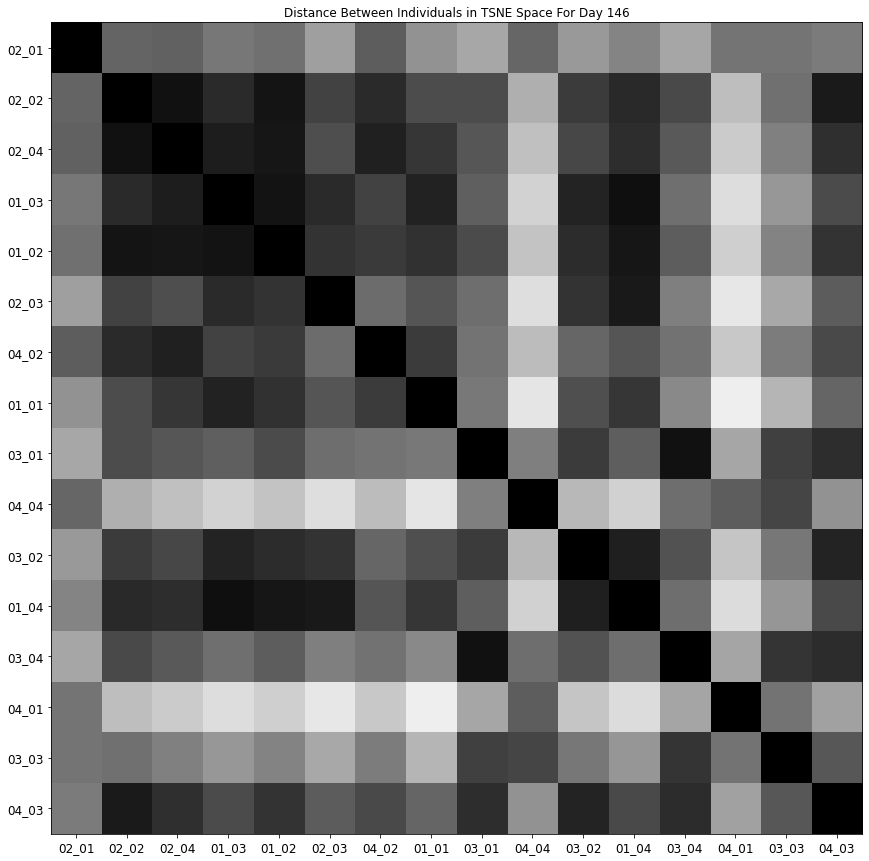

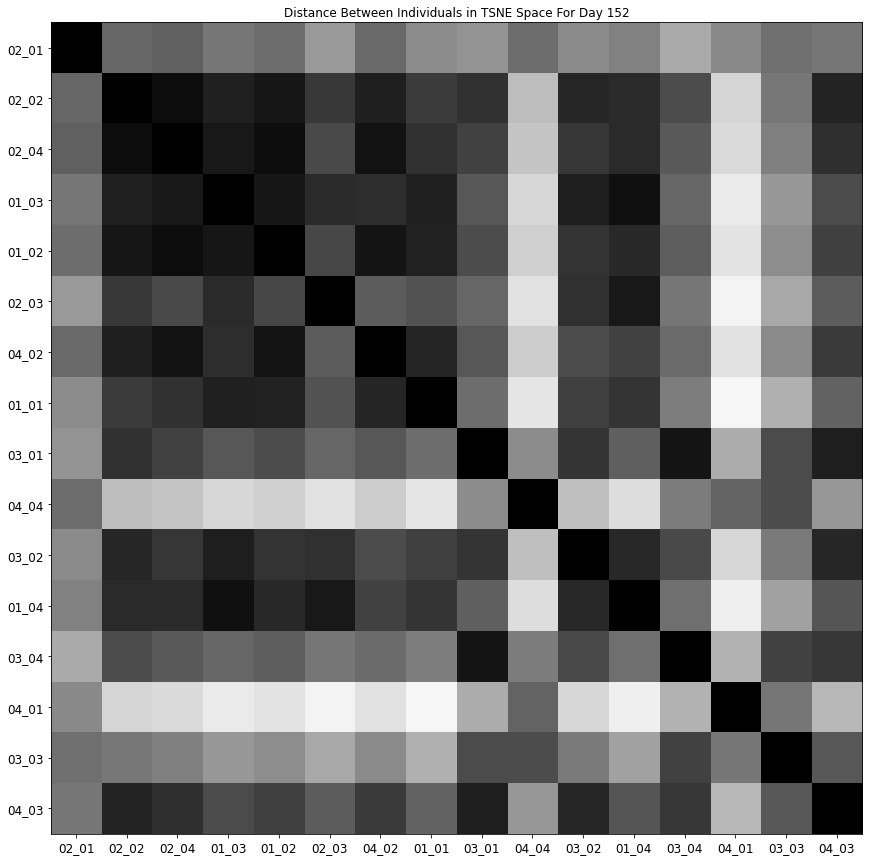

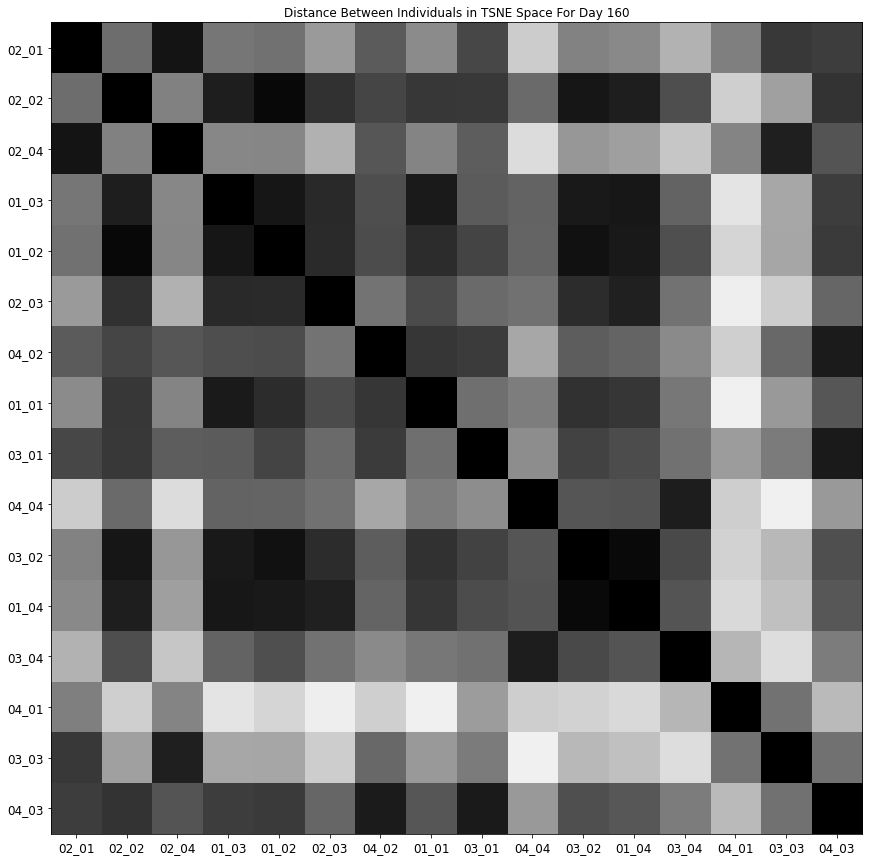

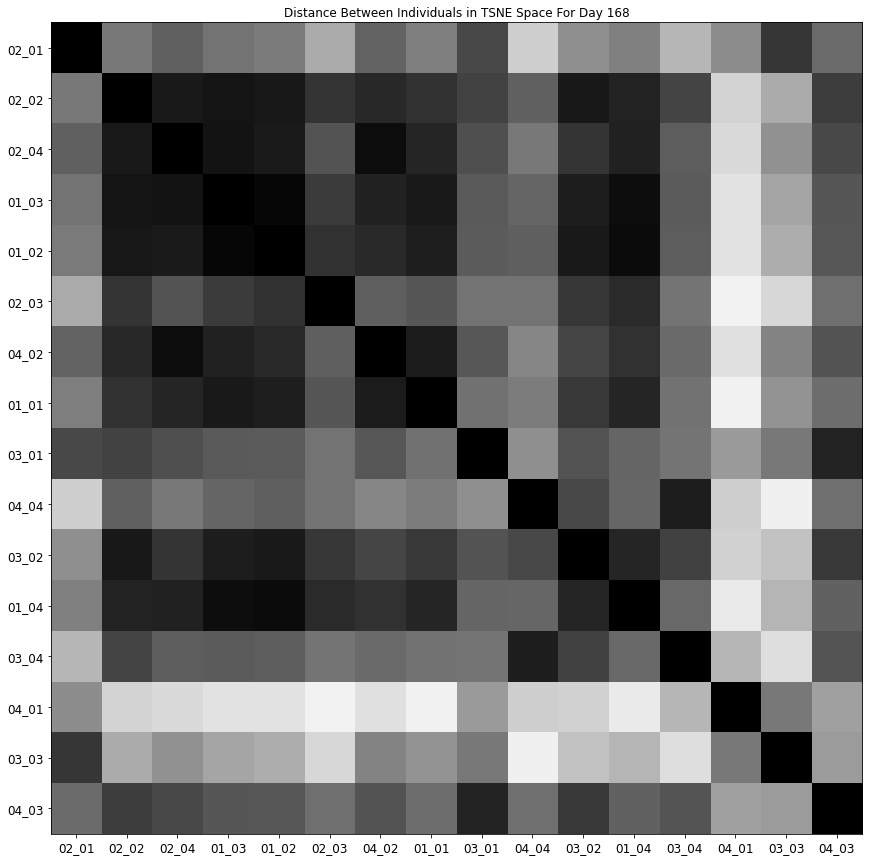

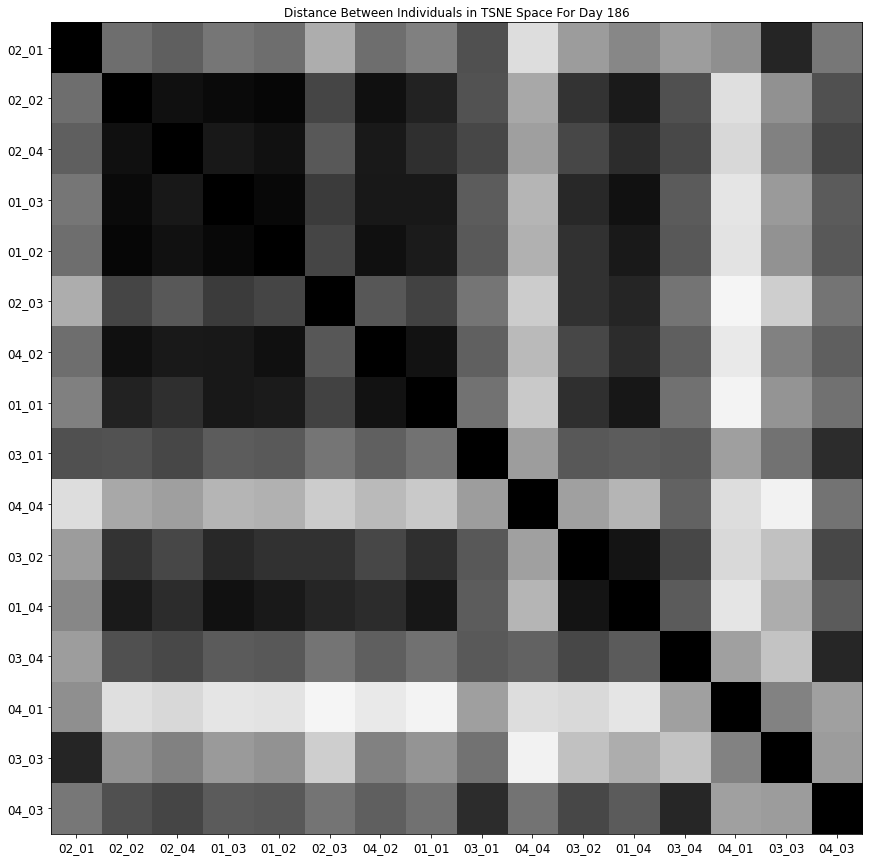

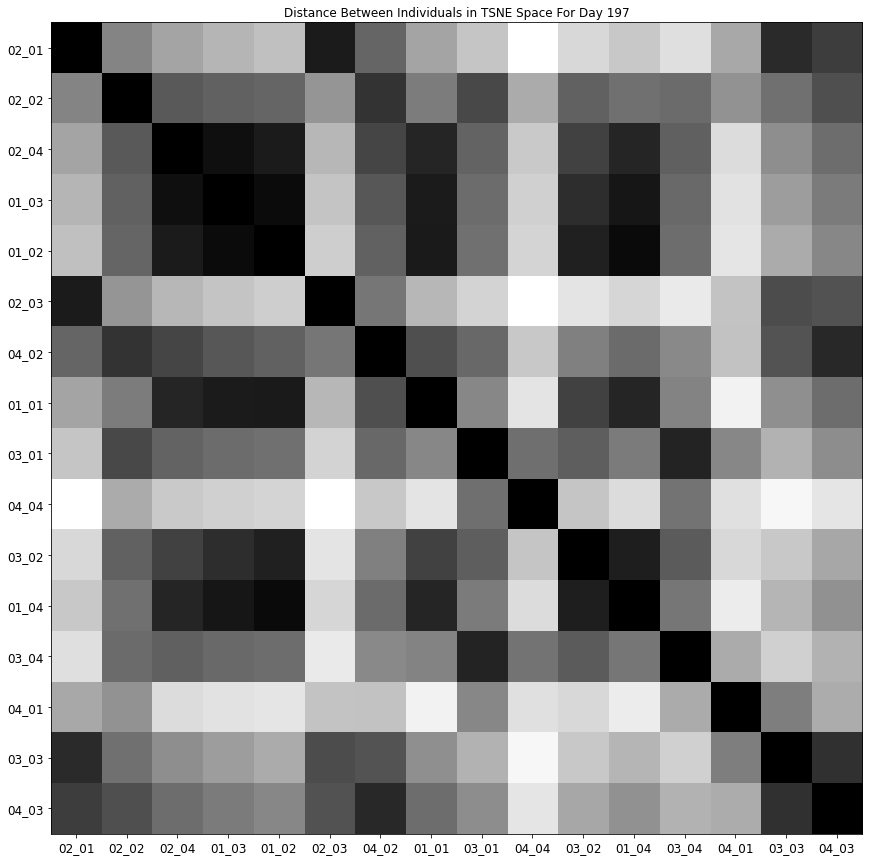

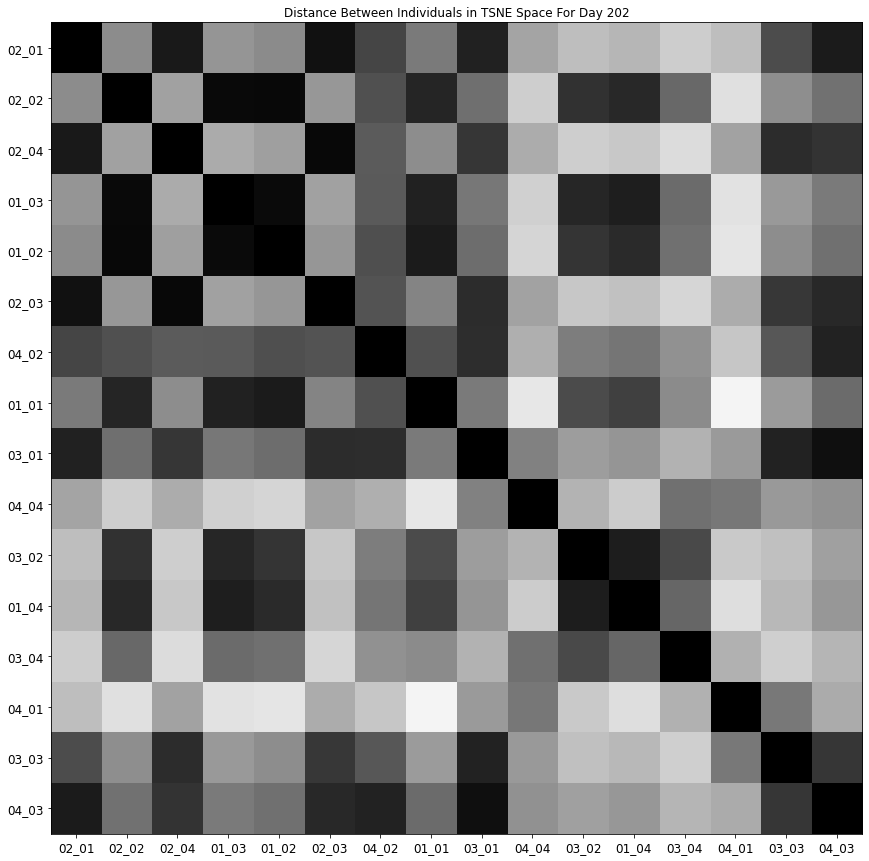

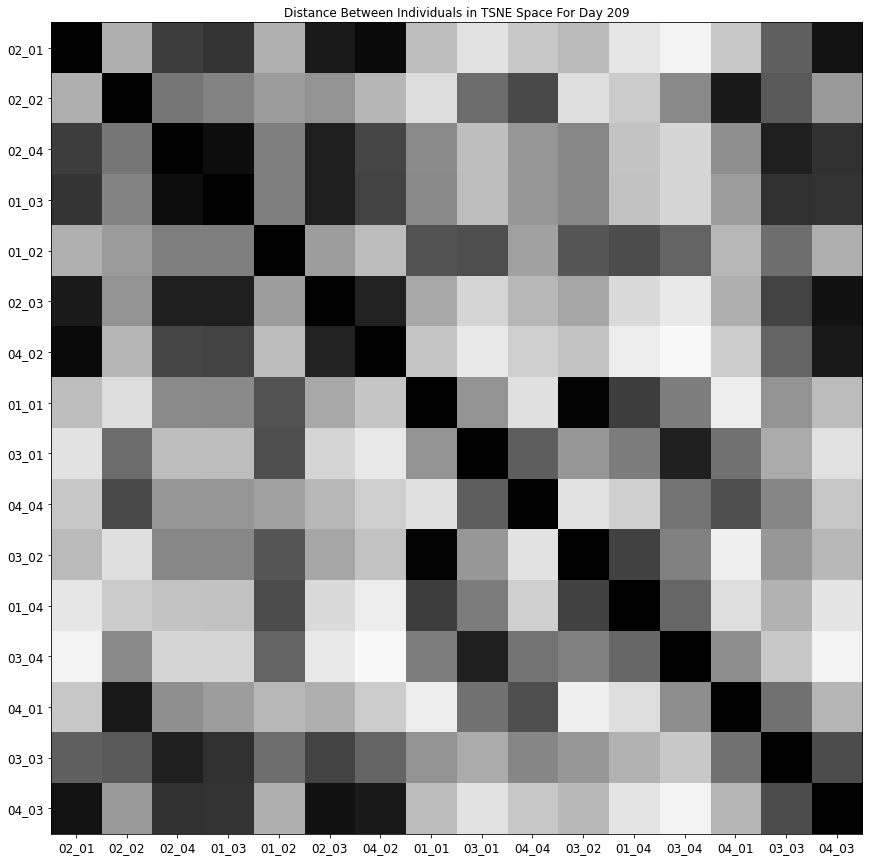

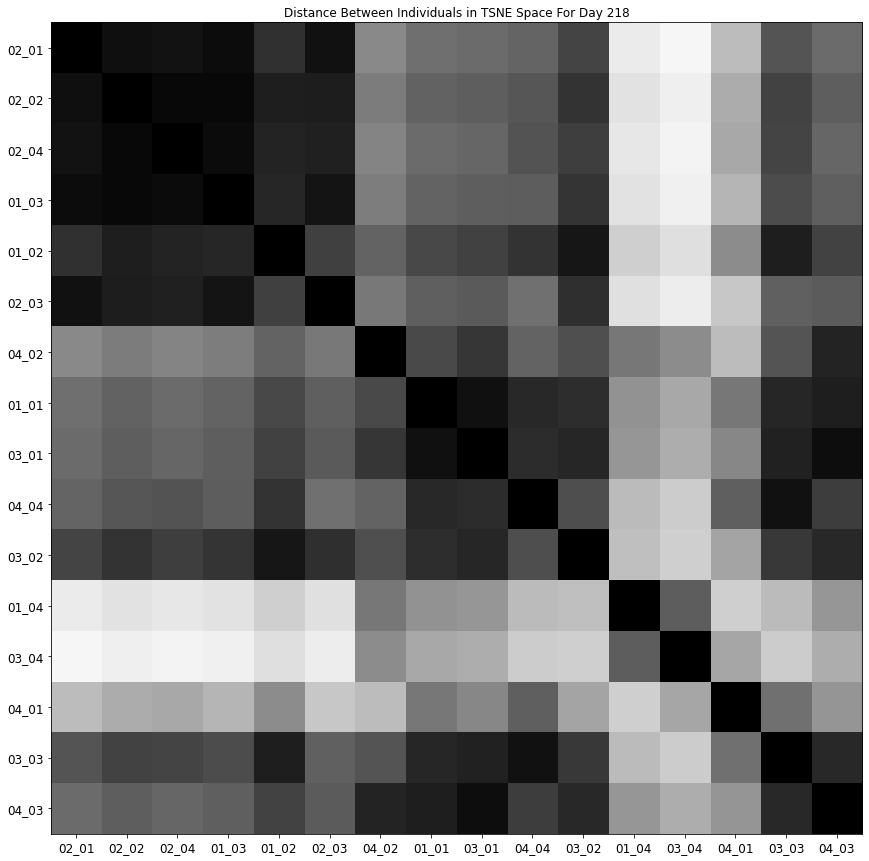

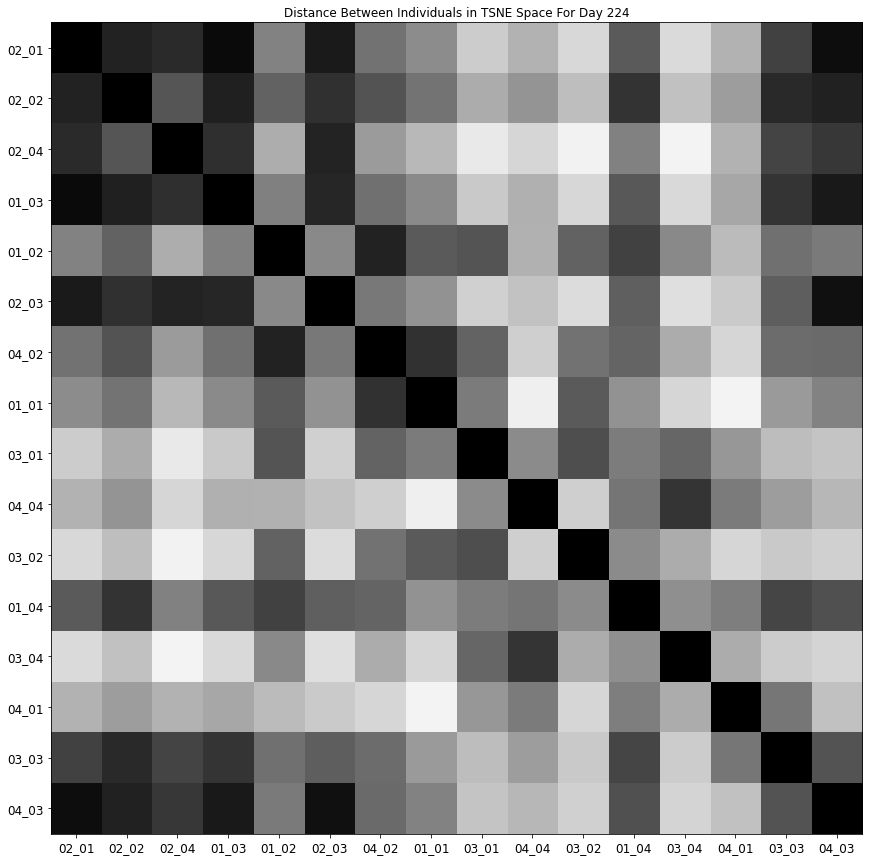

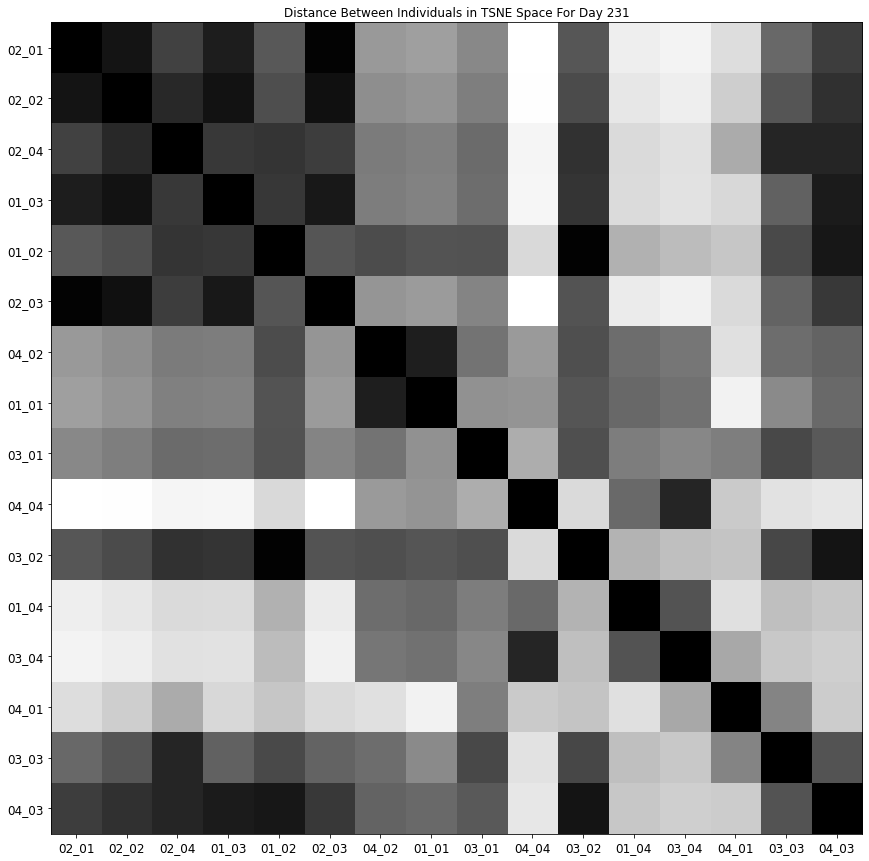

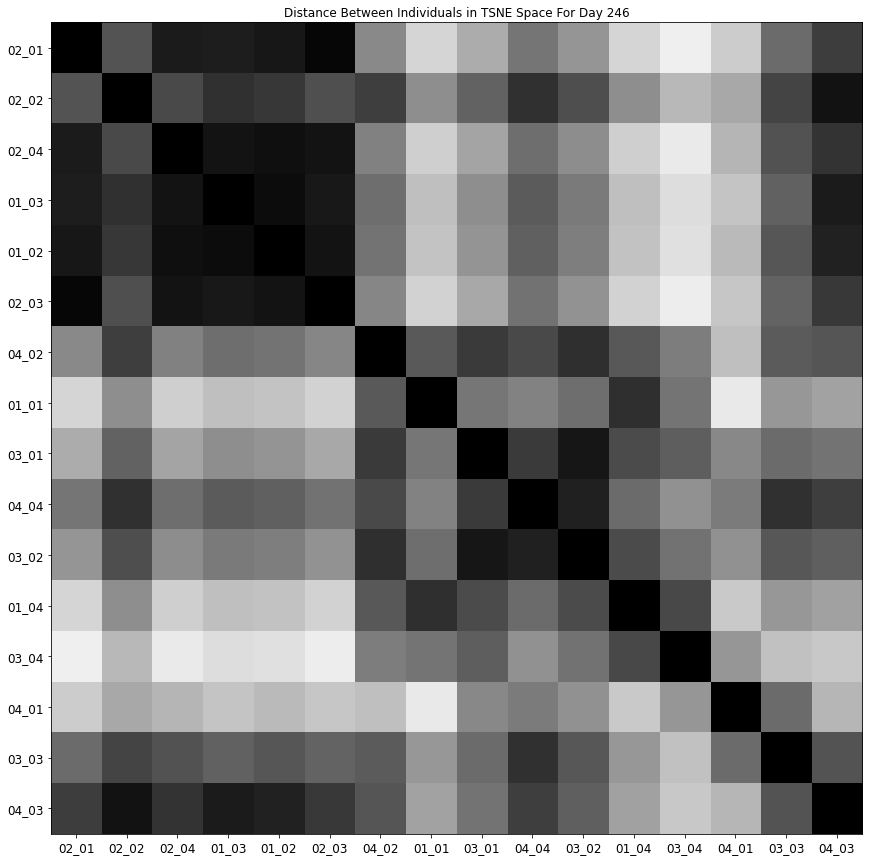

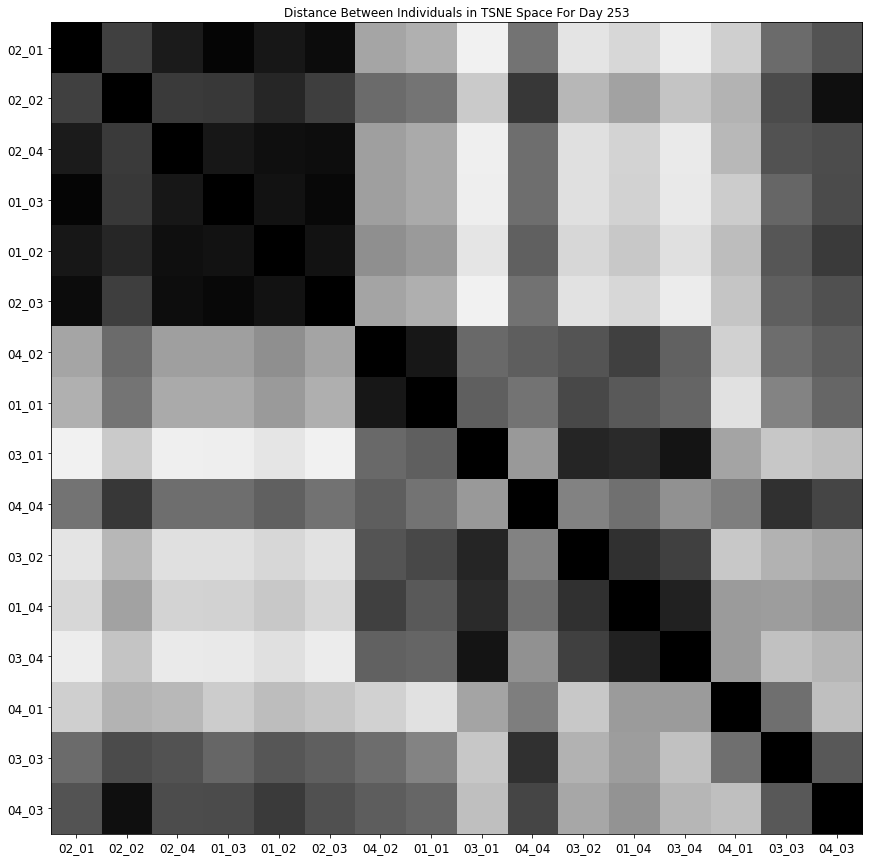

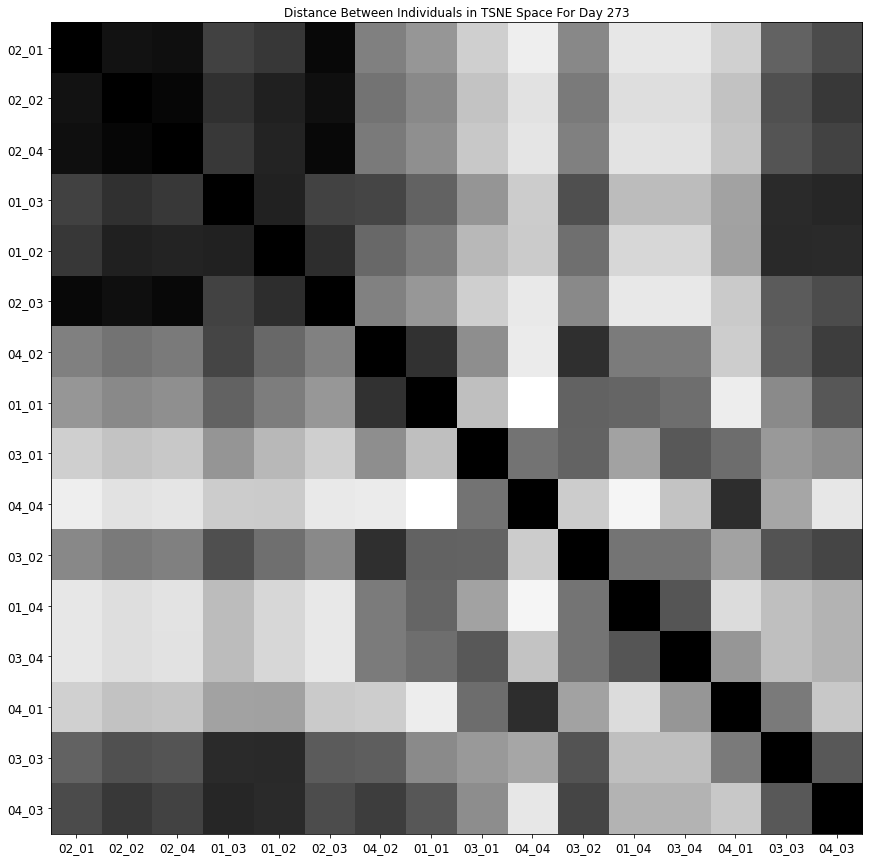

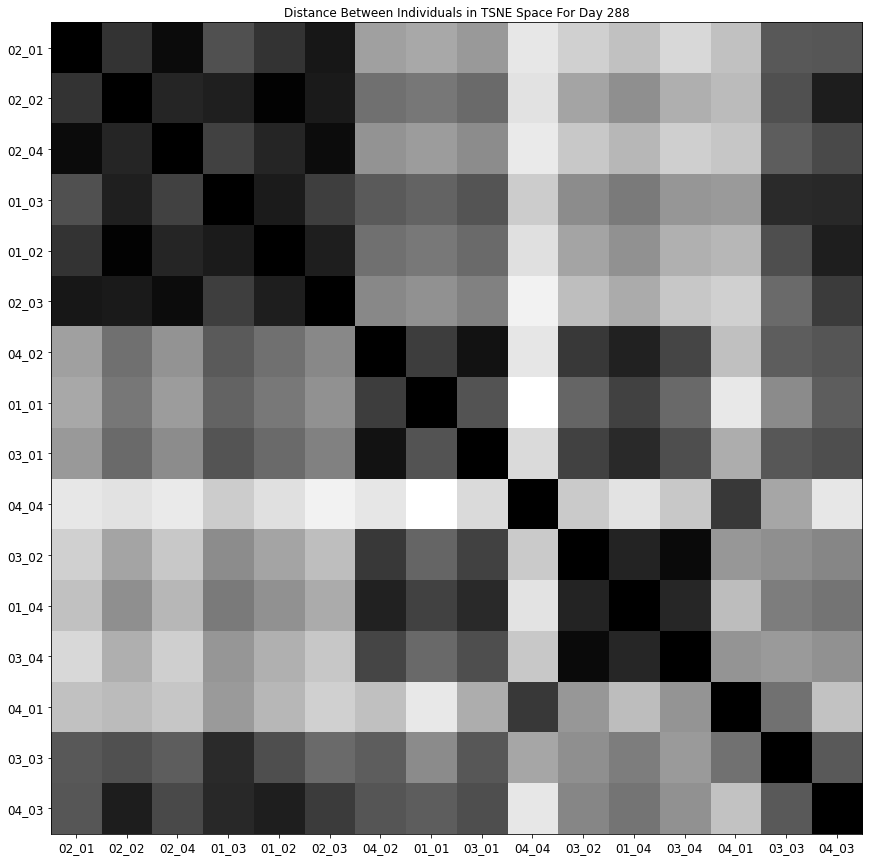

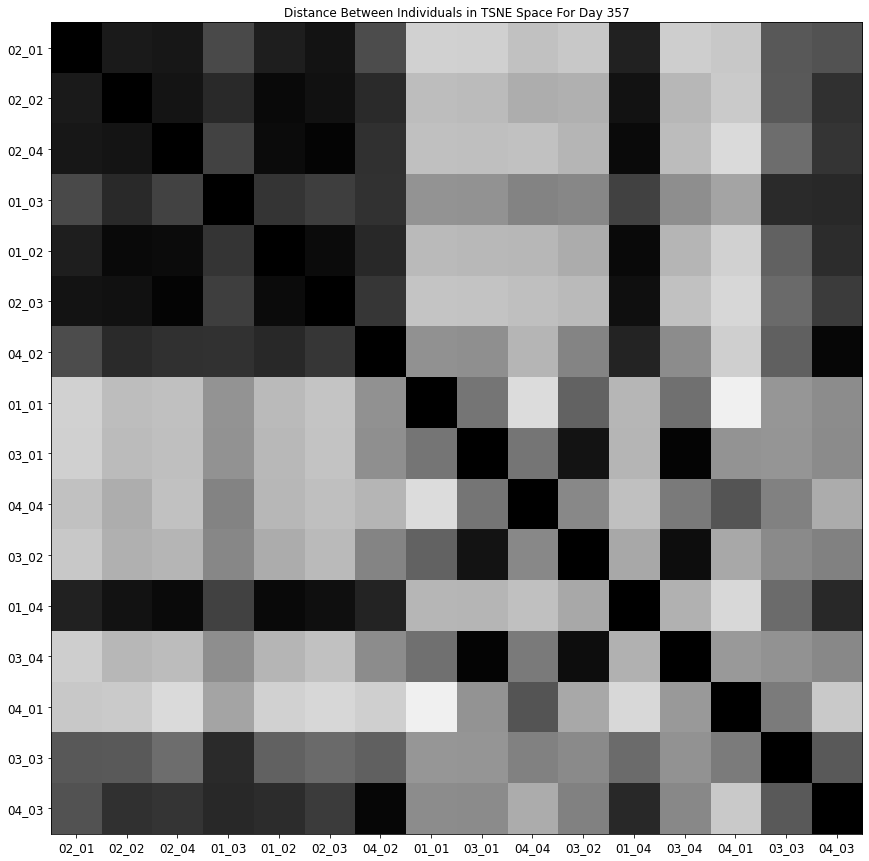

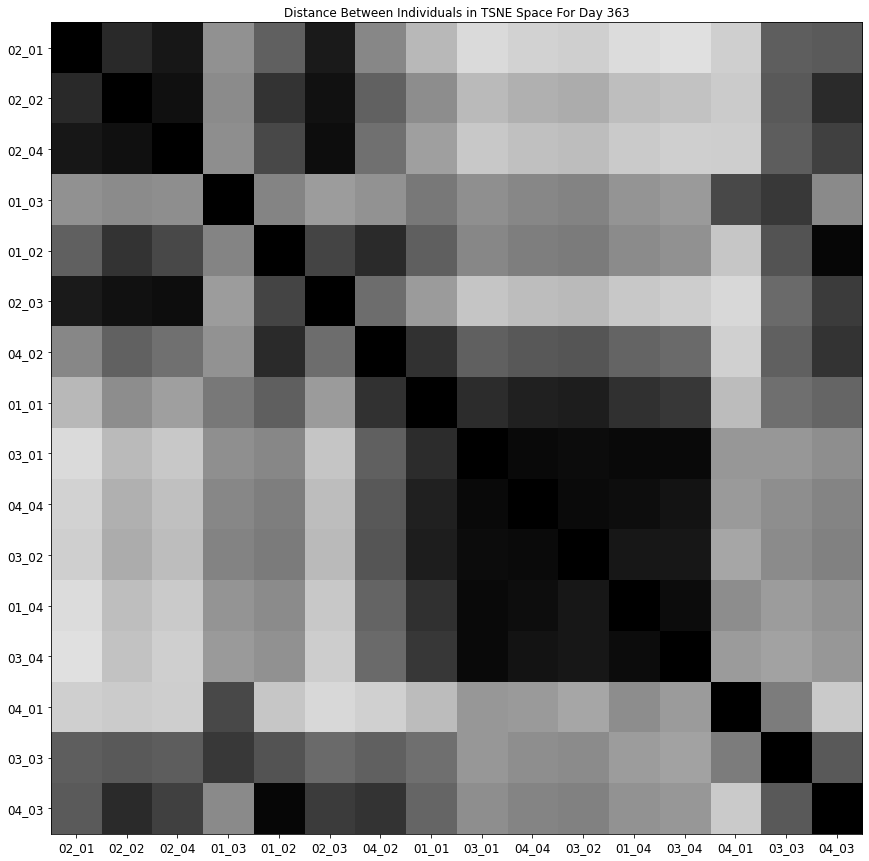

In [180]:
#movies

try:
    os.mkdir('male_dbiits_day')
except:
    print('directory already made')

#0,25,40,50 are good days for males

day=50
print(male_age_labels_int[day])

#order of best cluster on final day
#at day=40
o=np.array([6,14,4,13,10,2,7,15,5,12,8,11,1,3,0,9])

#at day=50
o=np.array([4,5,7,2,1,6,13,0,8,15,9,3,11,12,10,14])

for day in range(50):
    sort_by_day_x=True

    fig,ax=plt.subplots()
    fig.set_size_inches(12,12)
    fig.patch.set_facecolor('white')
    fig.tight_layout()


    tsne_dist=np.zeros((len(male_filled_x),len(male_filled_x)))
    plt.title('Distance Between Individuals in TSNE Space For Day ' + str(male_age_labels_int[day]))
    for i in range(len(male_filled_x)):
        for j in range(len(male_filled_x)):

            x1=male_filled_x[i][day]
            if math.isnan(x1):

                for k in range(30):
                    try:
                        x1=male_filled_x[i][day+k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass
            if math.isnan(x1):

                for k in range(20):
                    try:
                        x1=male_filled_x[i][day-k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass



            x2=male_filled_x[j][day]
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=male_filled_x[j][day+k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=male_filled_x[j][day-k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass



            y1=male_filled_y[i][day]

            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=male_filled_y[i][day+k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass
            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=male_filled_y[i][day-k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass



            y2=male_filled_y[j][day]
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=male_filled_y[j][day+k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=male_filled_y[j][day-k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass



            try:
                xdiff=x2-x1
                ydiff=y2-y1
                diff=(xdiff**2)**.5 + (ydiff**2)**.5
                tsne_dist[i,j]=diff
            except:
                print('huh')

        ax.set_xticks(np.arange(len(unique_individual_longtogeny_males)))
        ax.set_yticks(np.arange(len(unique_individual_longtogeny_males)))

        if not sort_by_day_x:
            ax.set_xticklabels(list(np.array(unique_individual_longtogeny_males)),fontsize=12)
            ax.set_yticklabels(list(np.array(unique_individual_longtogeny_males)),fontsize=12)

        if sort_by_day_x:
            ax.set_xticklabels(list(np.array(unique_individual_longtogeny_males)[o]),fontsize=12)
            ax.set_yticklabels(list(np.array(unique_individual_longtogeny_males)[o]),fontsize=12)


        if not sort_by_day_x:
            p2plot=plt.imshow(tsne_dist,cmap='Greys_r',vmax=80)

        if sort_by_day_x:
            p2plot=plt.imshow(tsne_dist[o][:,o],cmap='Greys_r',vmax=80)


    #personality_plot=sns.clustermap(tsne_dist,vmax=100,vmin=0)

    #     if not sort_by_day_x:
    #         fig.savefig(strain + 'male_tsne_dist_sort_cage_' + str(day) + '.pdf', bbox_inches='tight')
    #         fig.savefig(strain + 'male_tsne_dist_sort_cage_' + str(day) + '.png', bbox_inches='tight')

    if sort_by_day_x:
            
        #fig.savefig(strain + 'male_tsne_dist_sort_last_day_' + str(day) + '.pdf', bbox_inches='tight')
        #fig.savefig(strain + 'male_tsne_dist_sort_last_day_' + str(day) + '.png', bbox_inches='tight')
        fig.savefig("male_dbiits_day/{:04d}.png".format(day),bbox_inches='tight')

!ffmpeg -r 4 -i male_dbiits_day/%04d.png -vb 20M -pix_fmt yuv420p male_tsne_dist_evolution.mp4
os.chdir(abra)
os.chdir(data_loc)


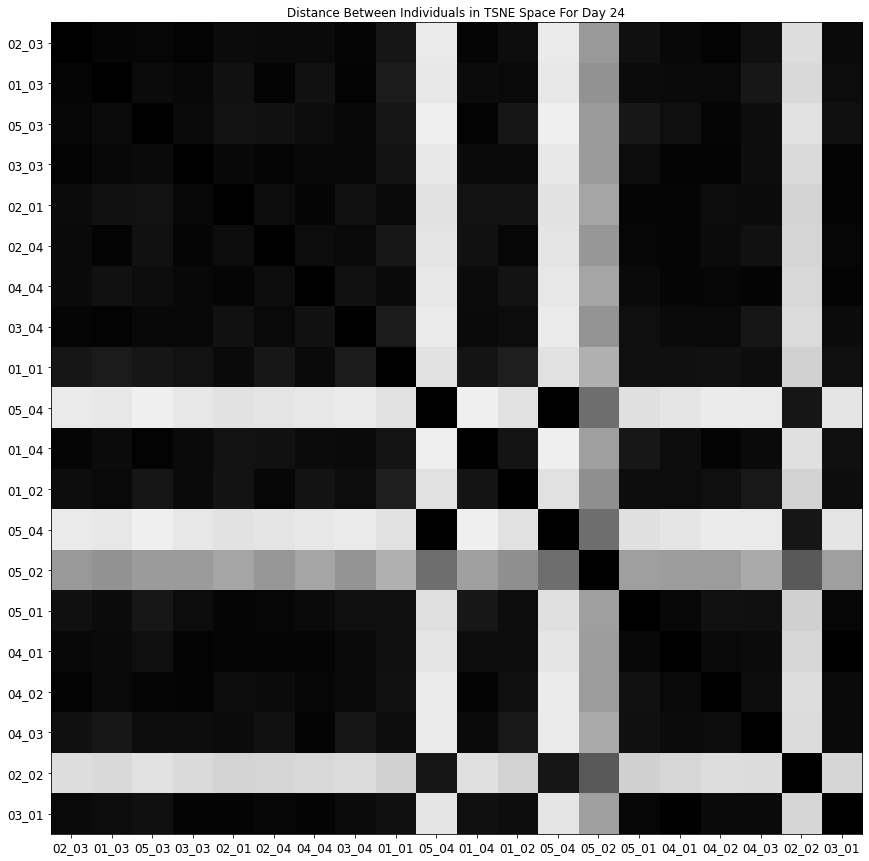

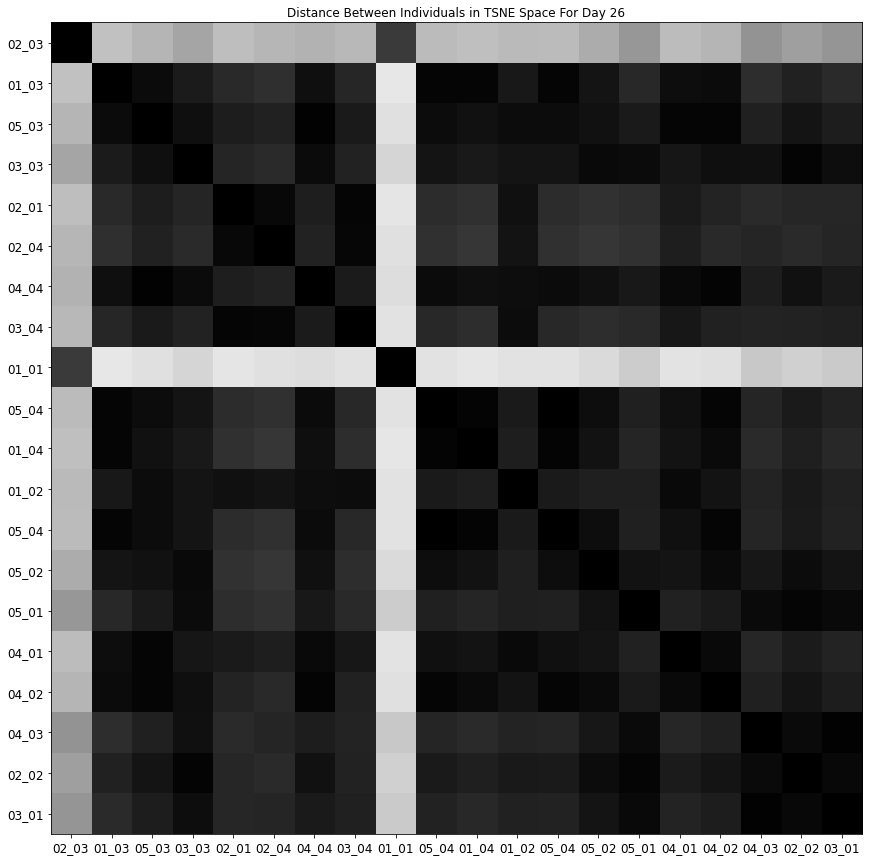

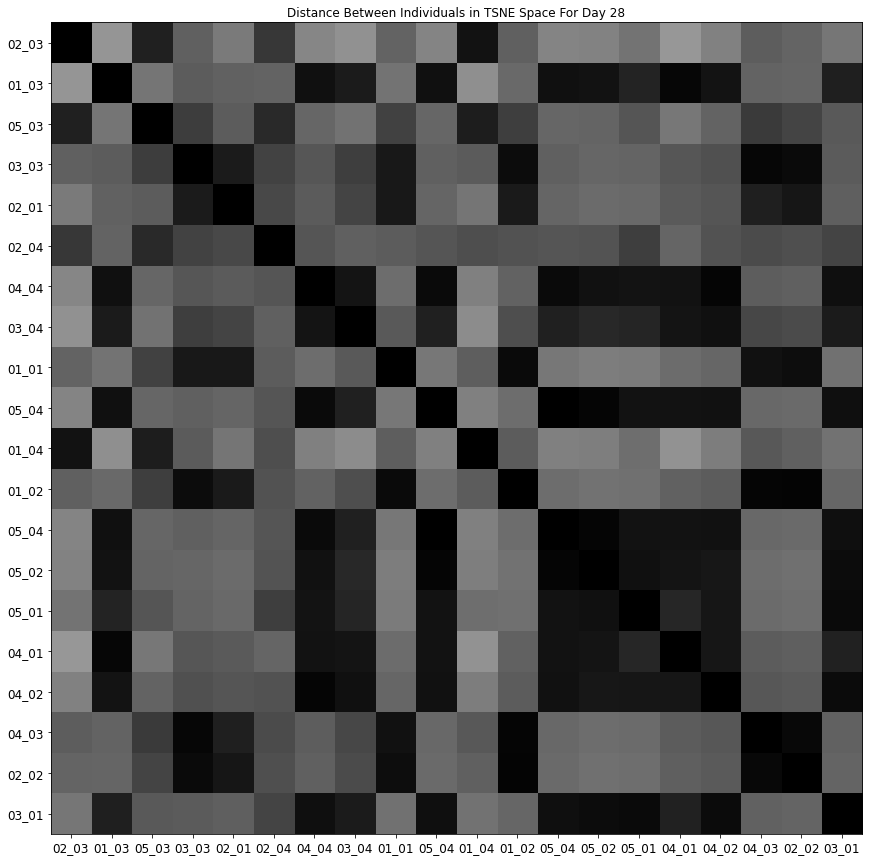

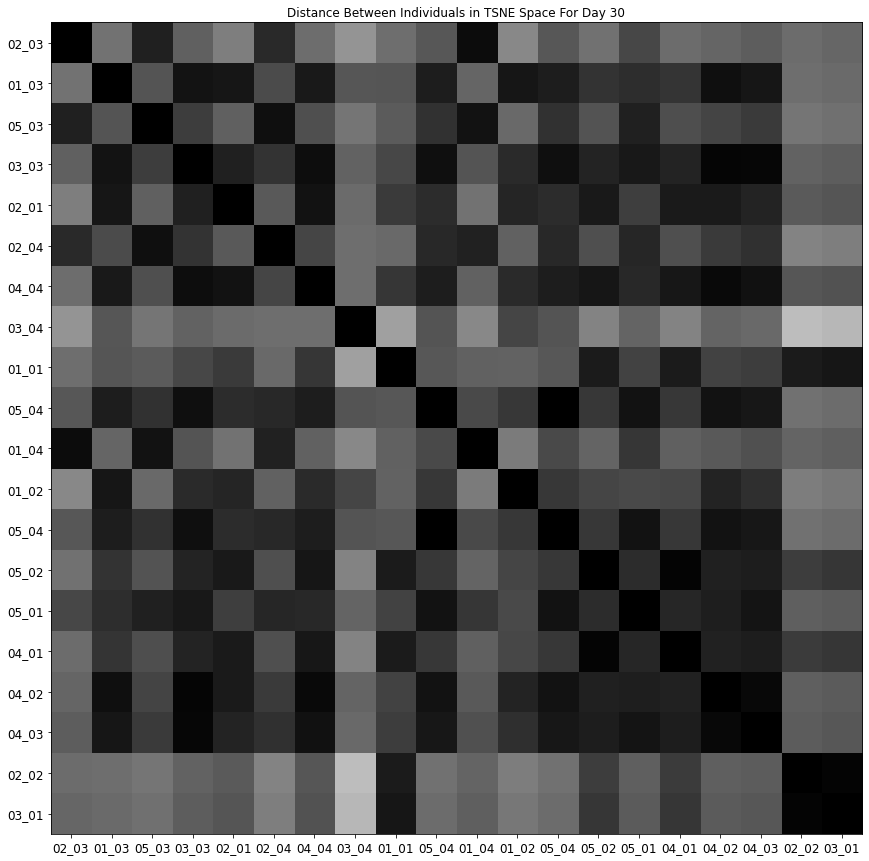

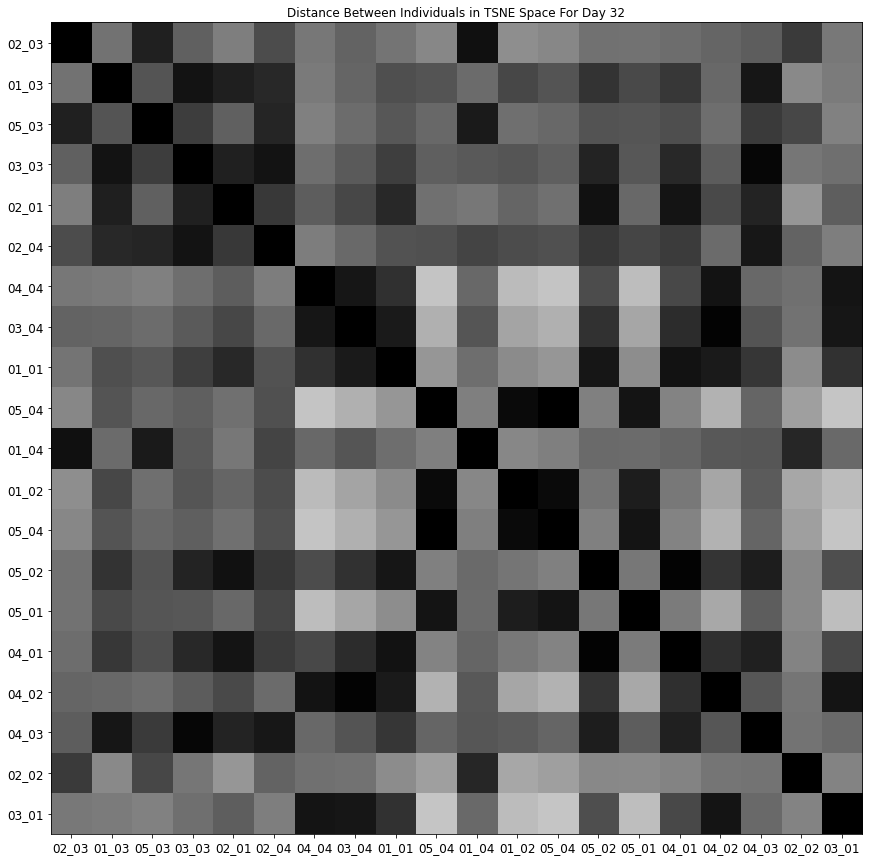

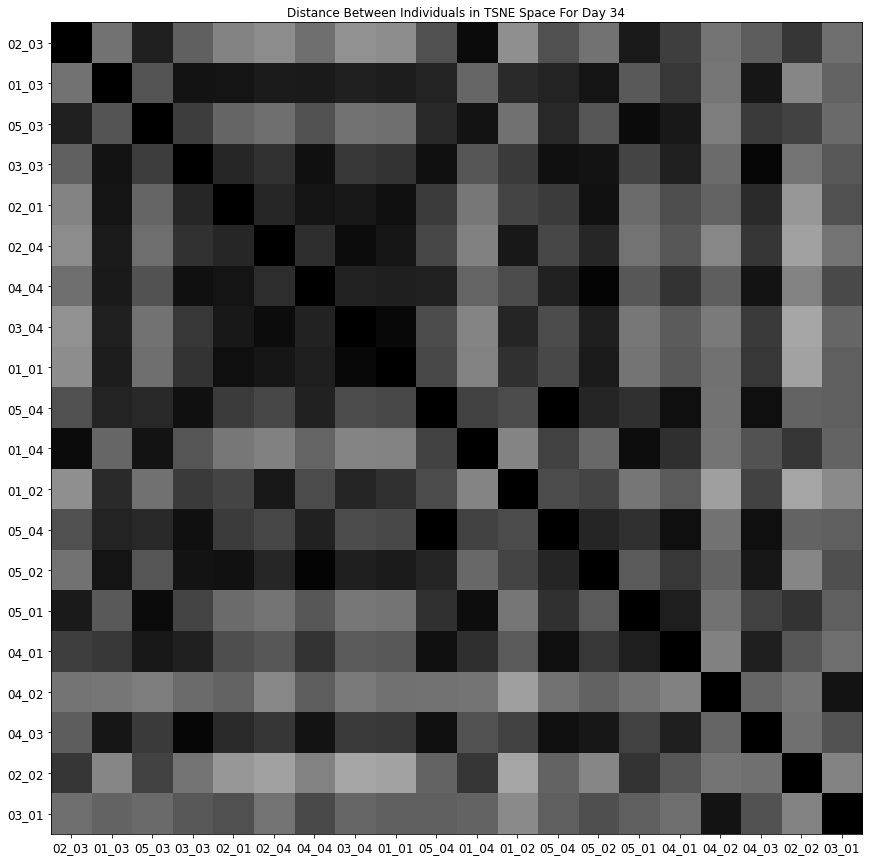

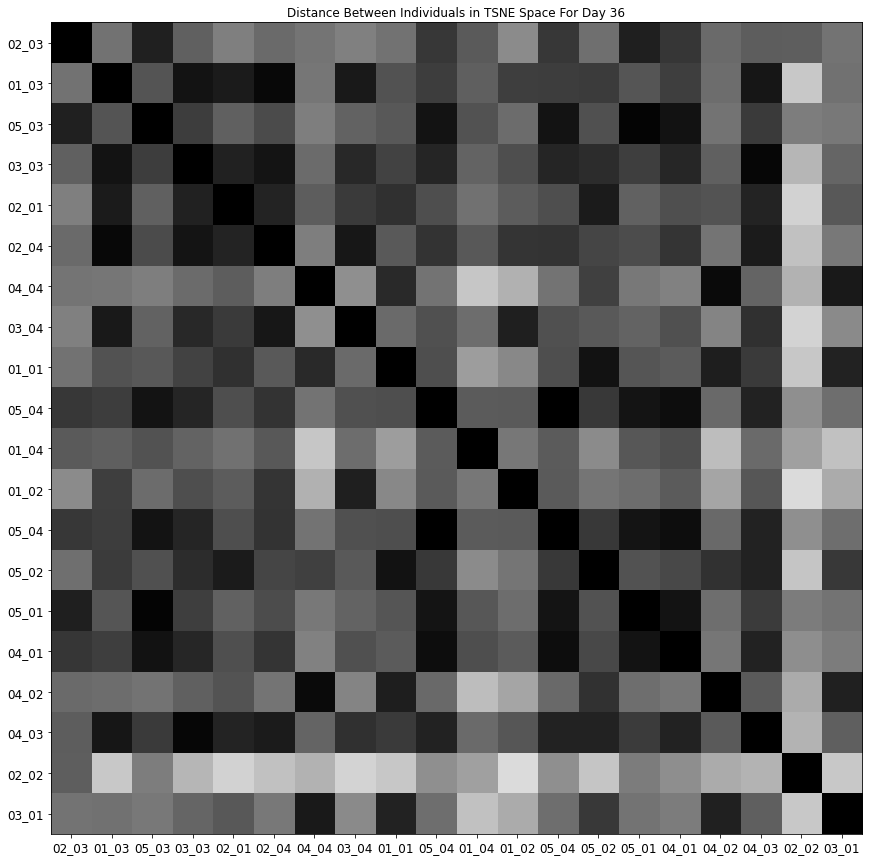

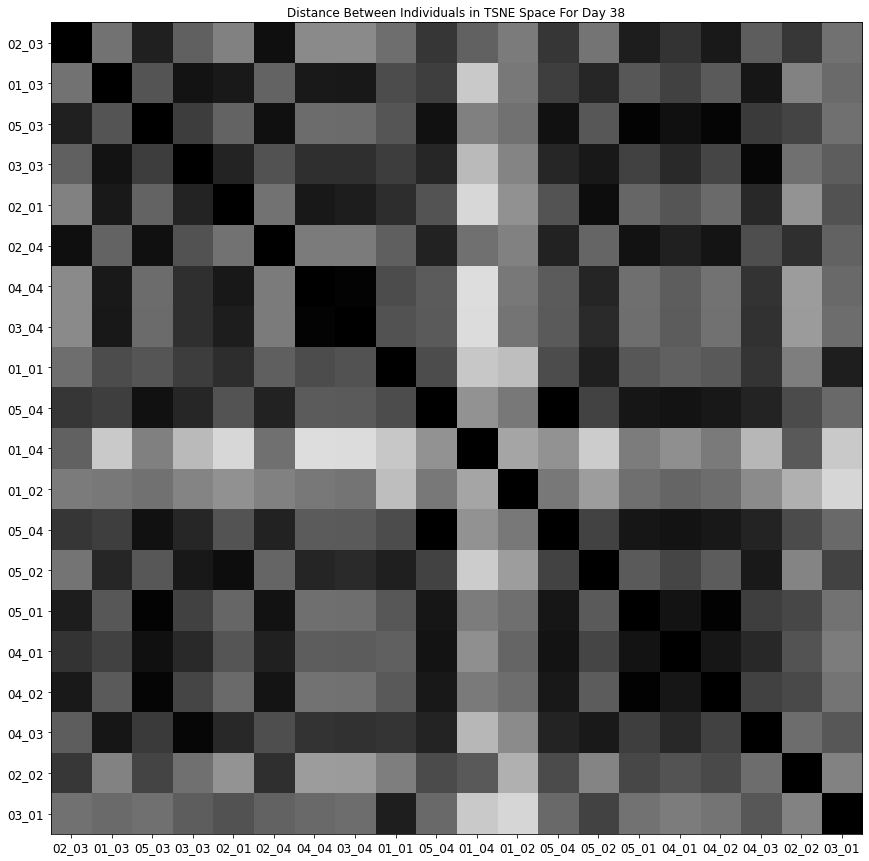

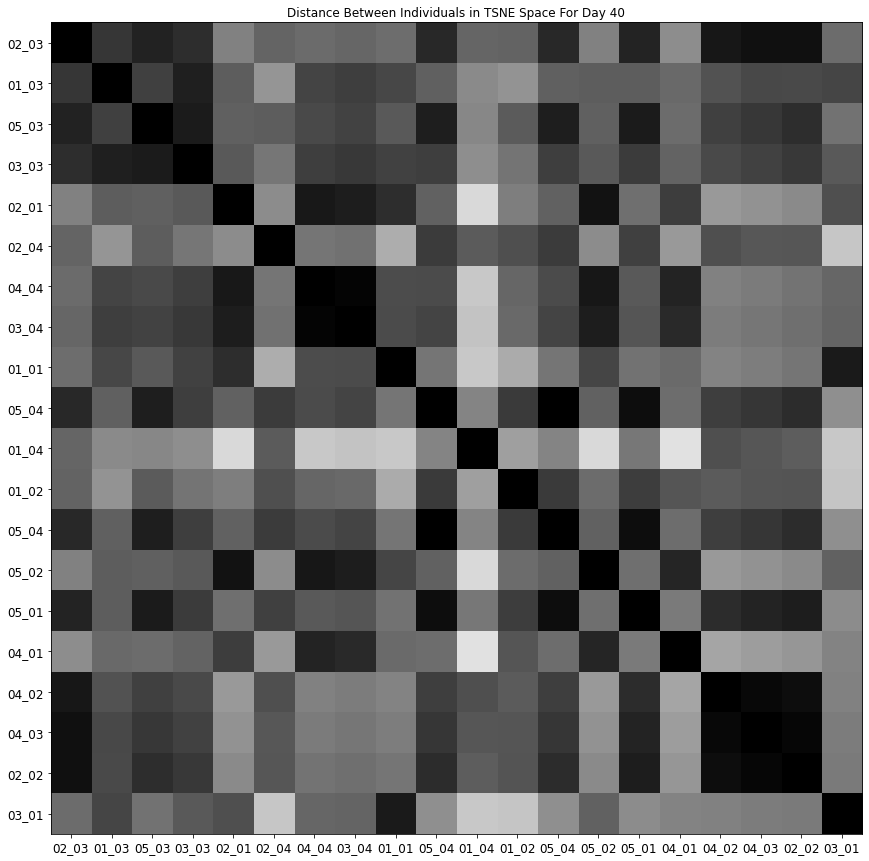

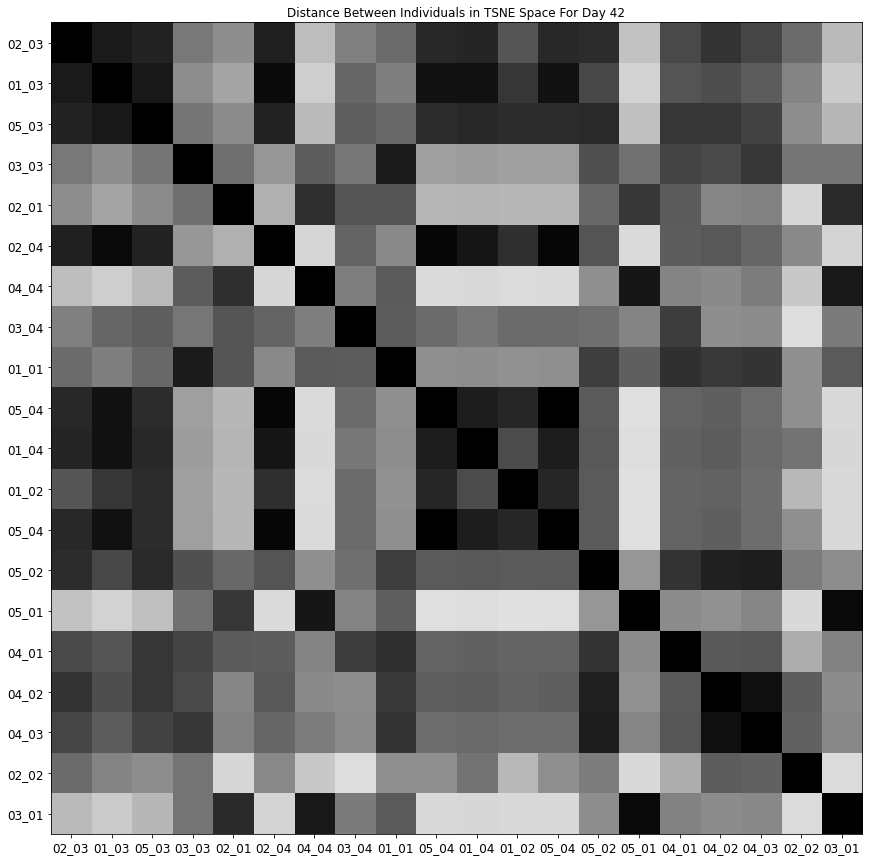

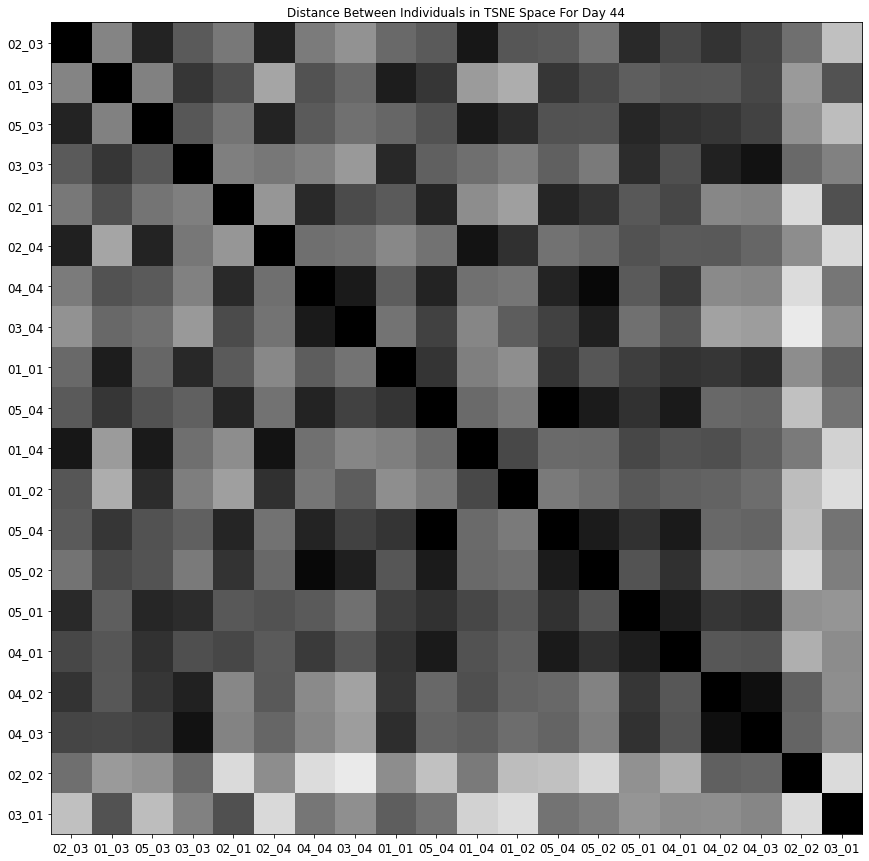

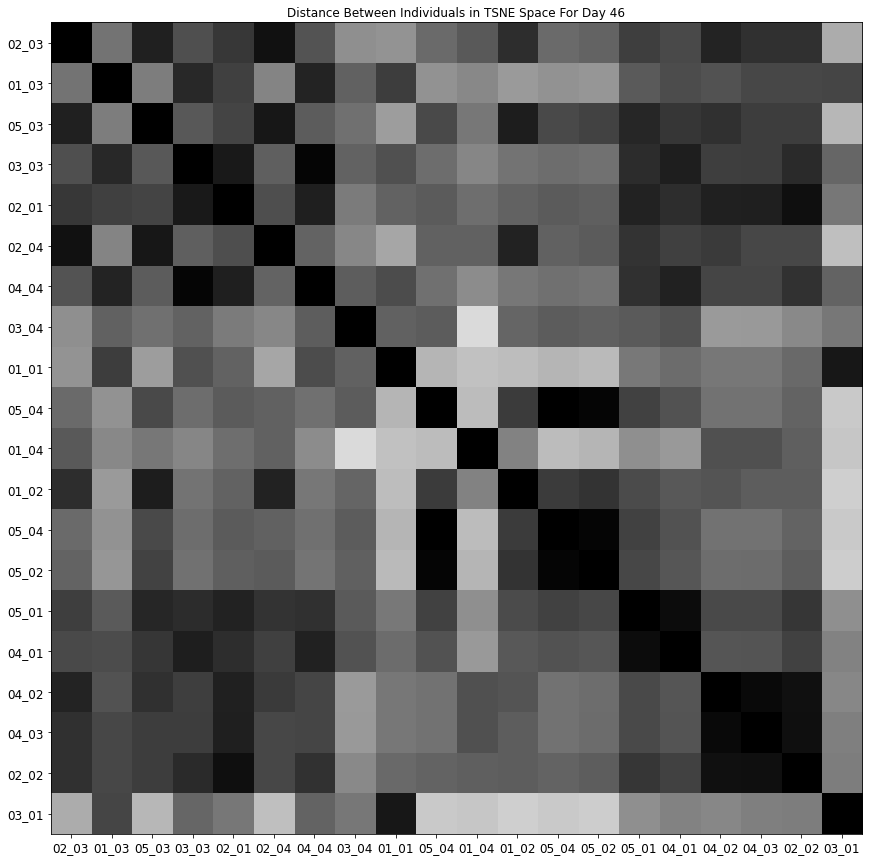

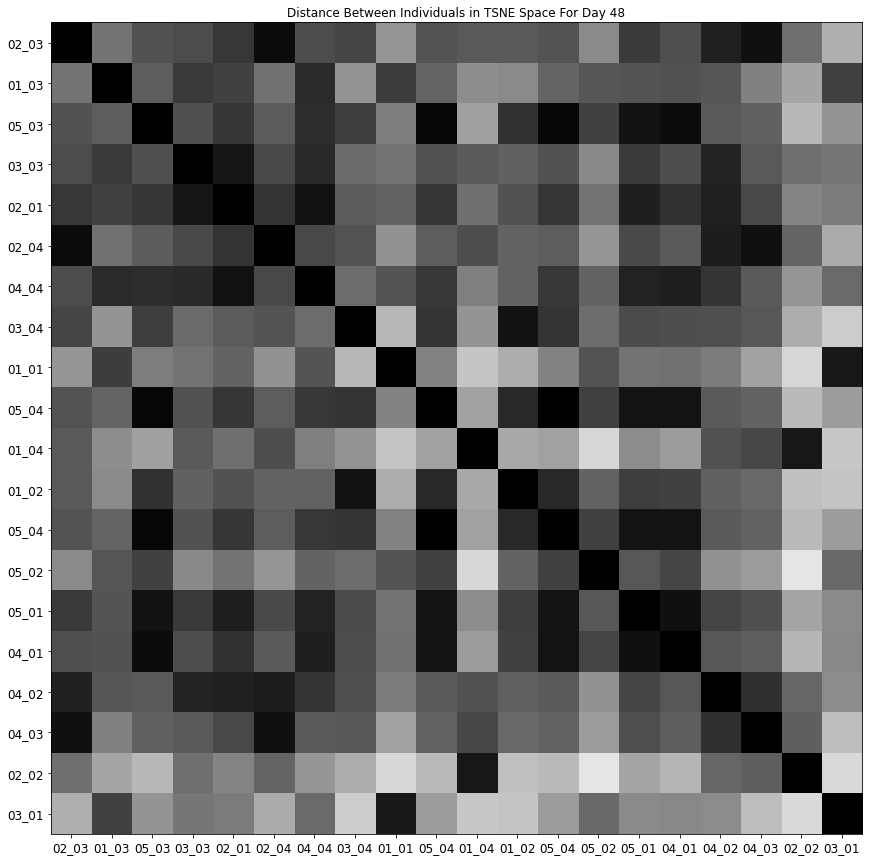

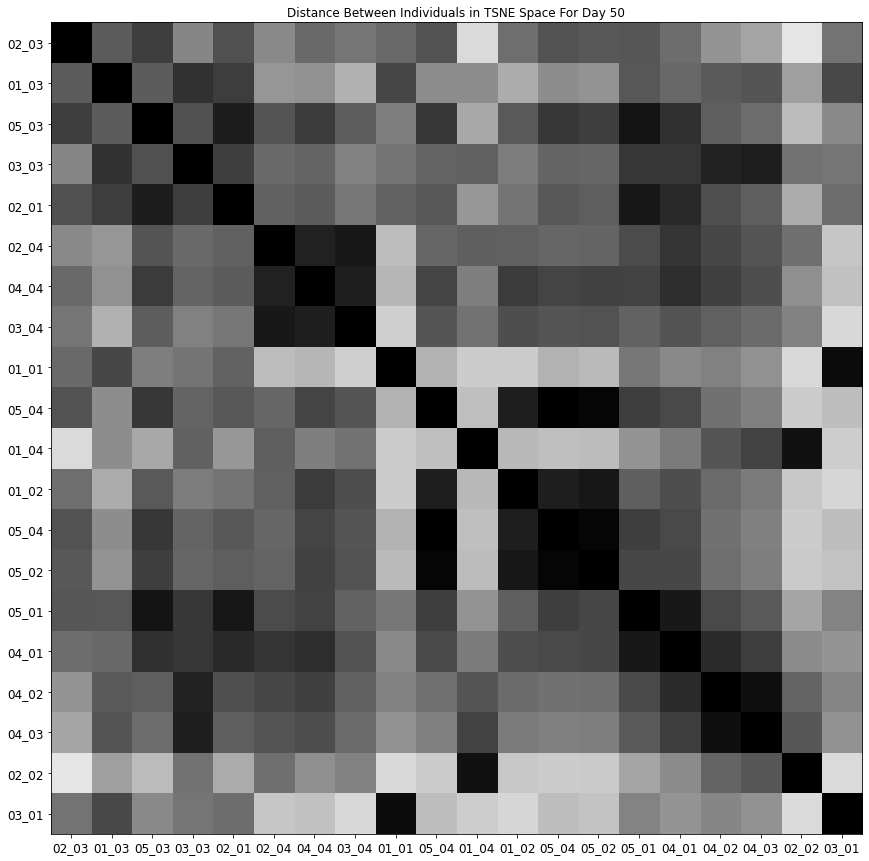

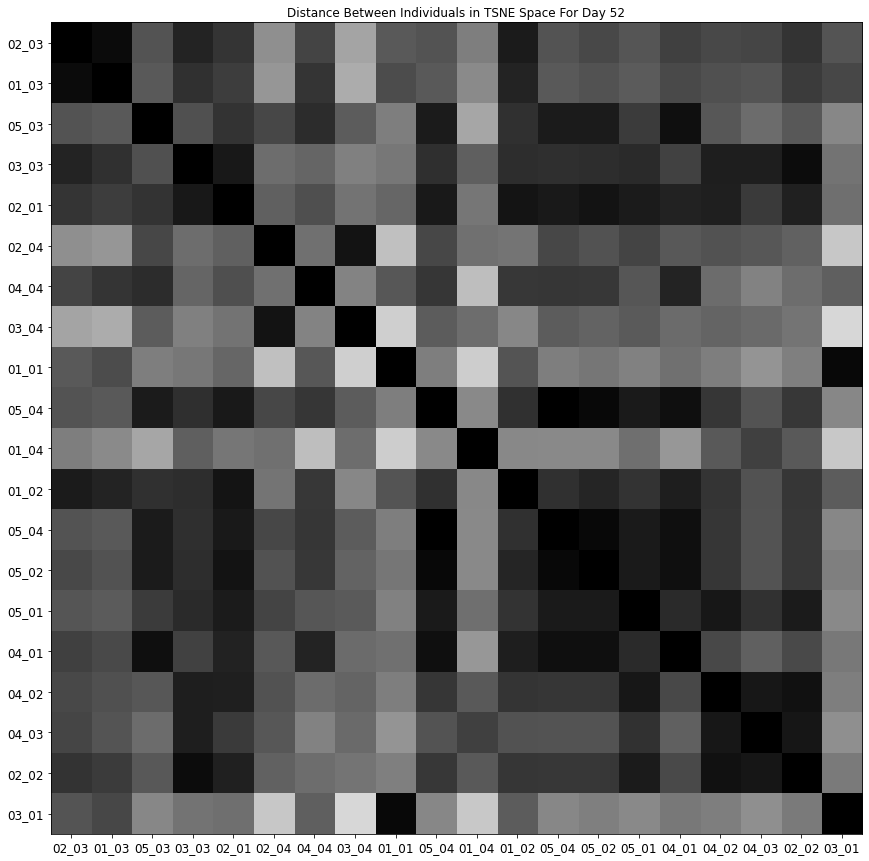

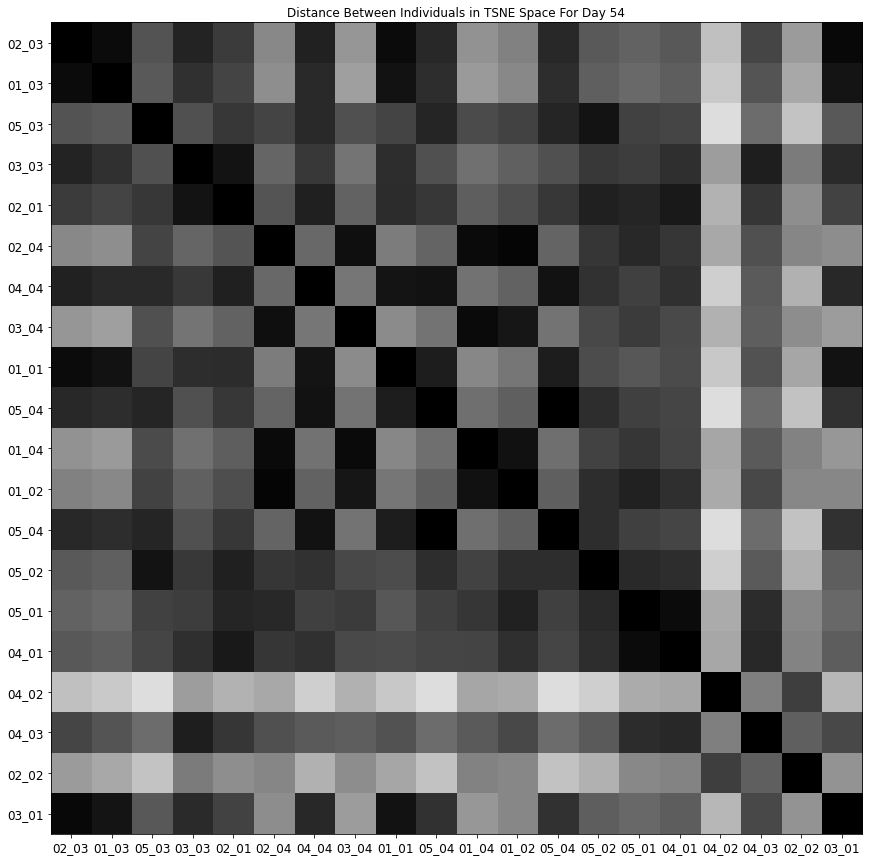

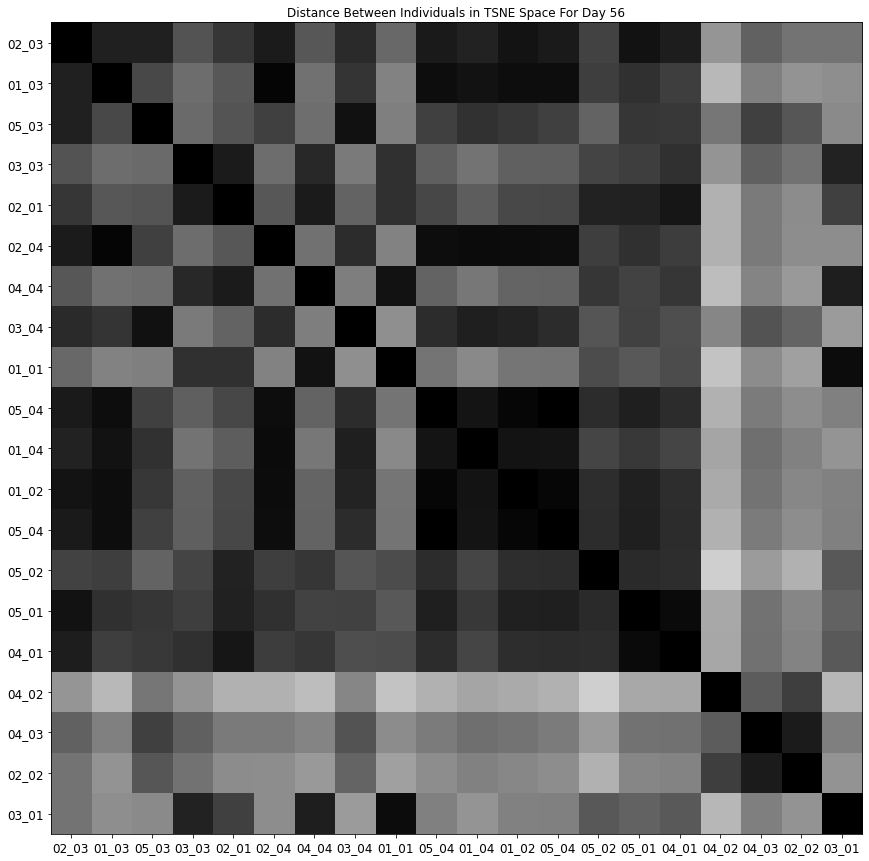

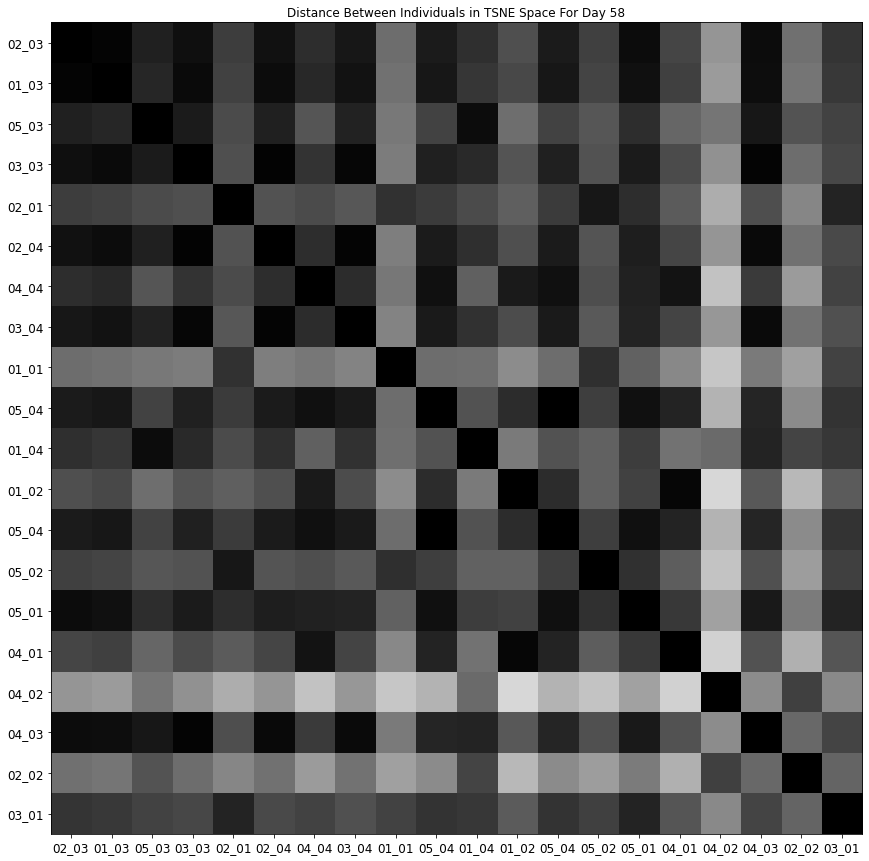

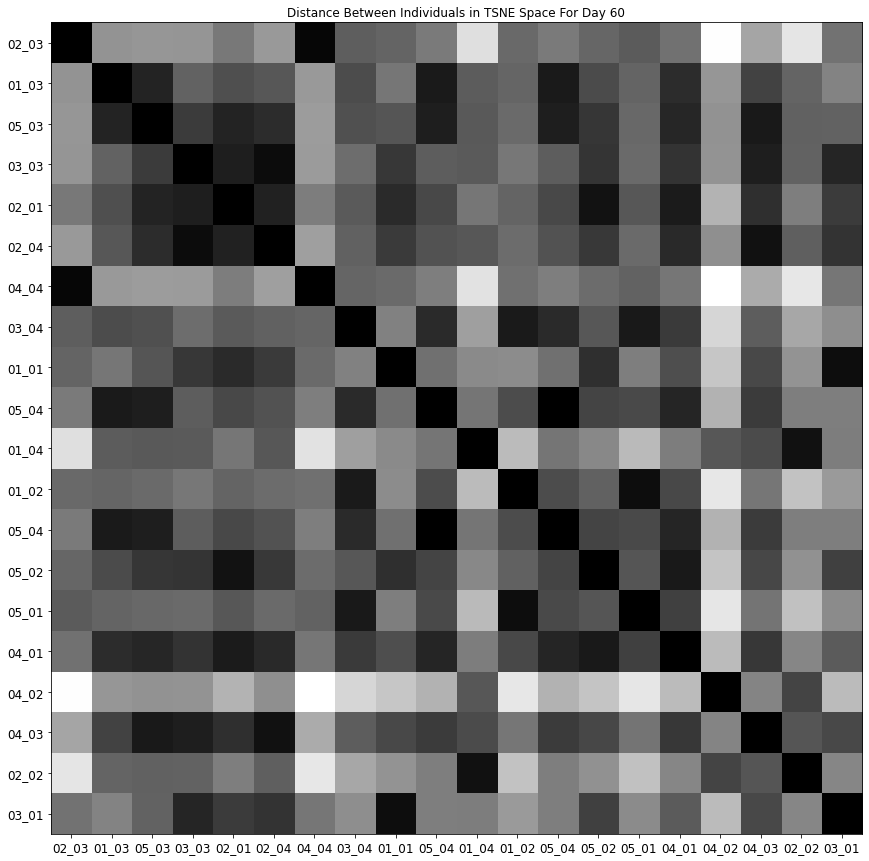

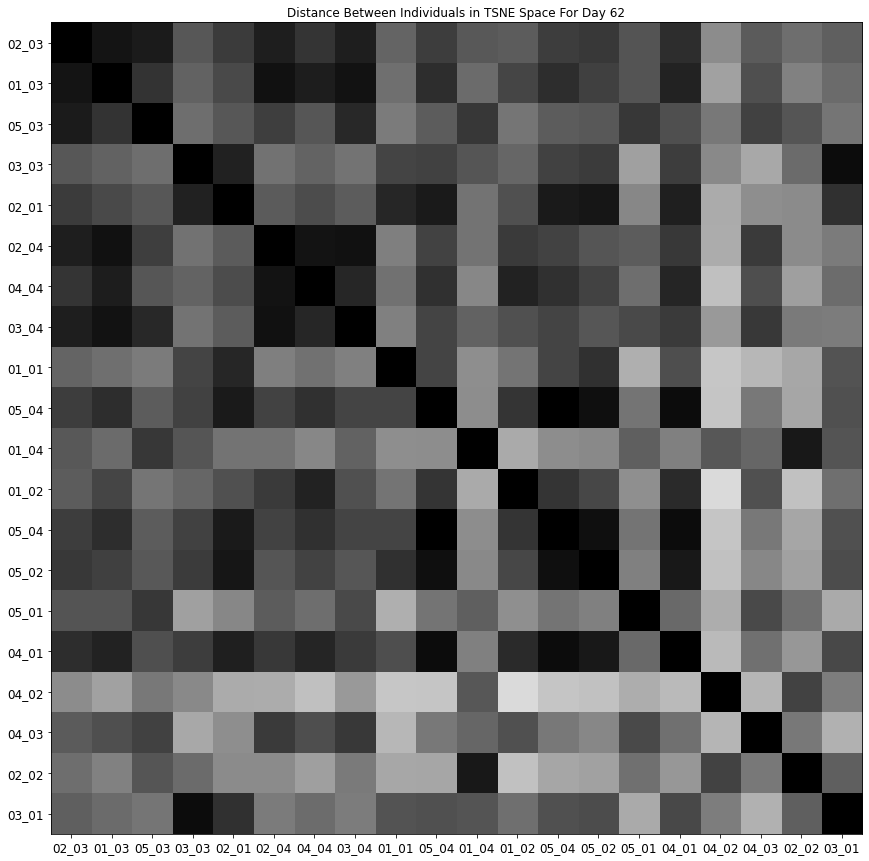

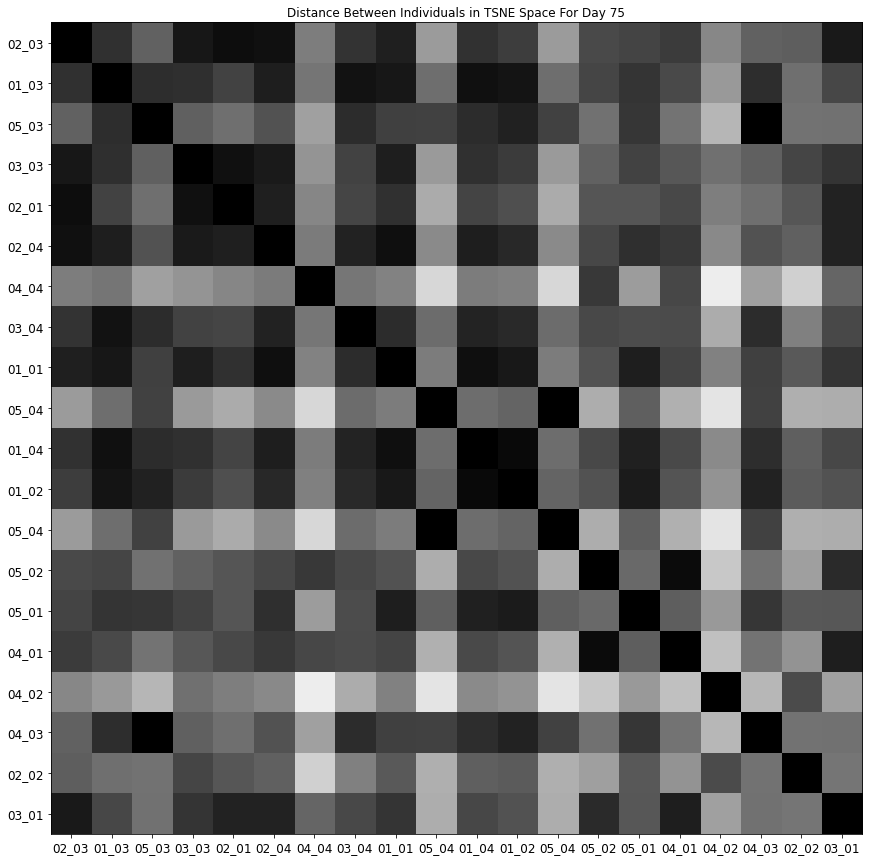

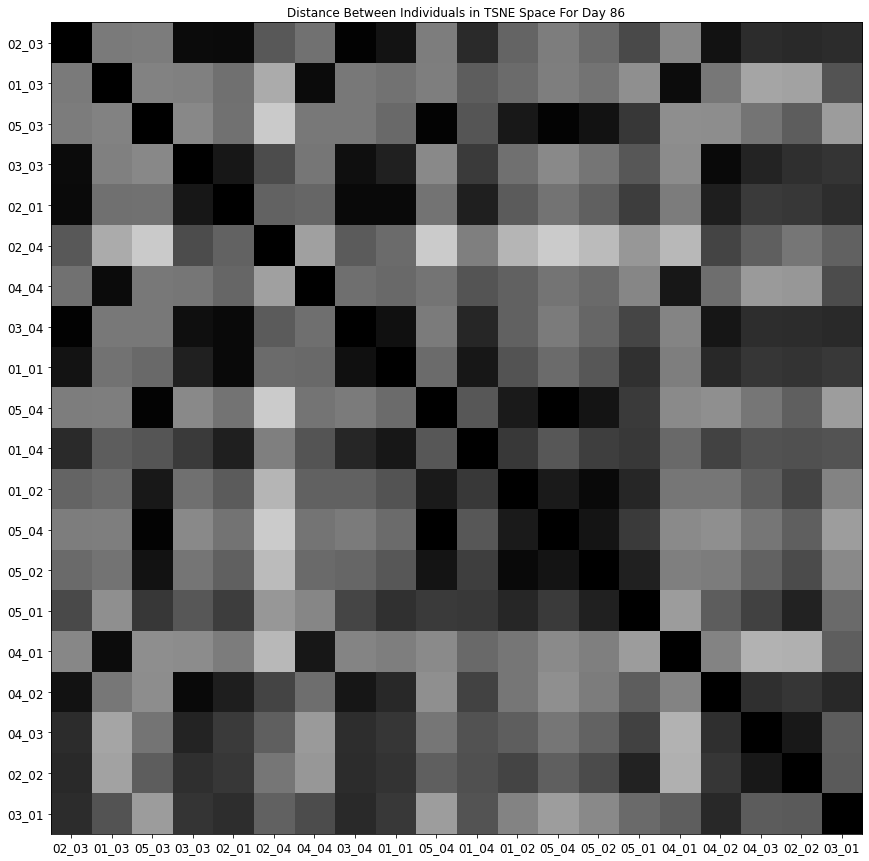

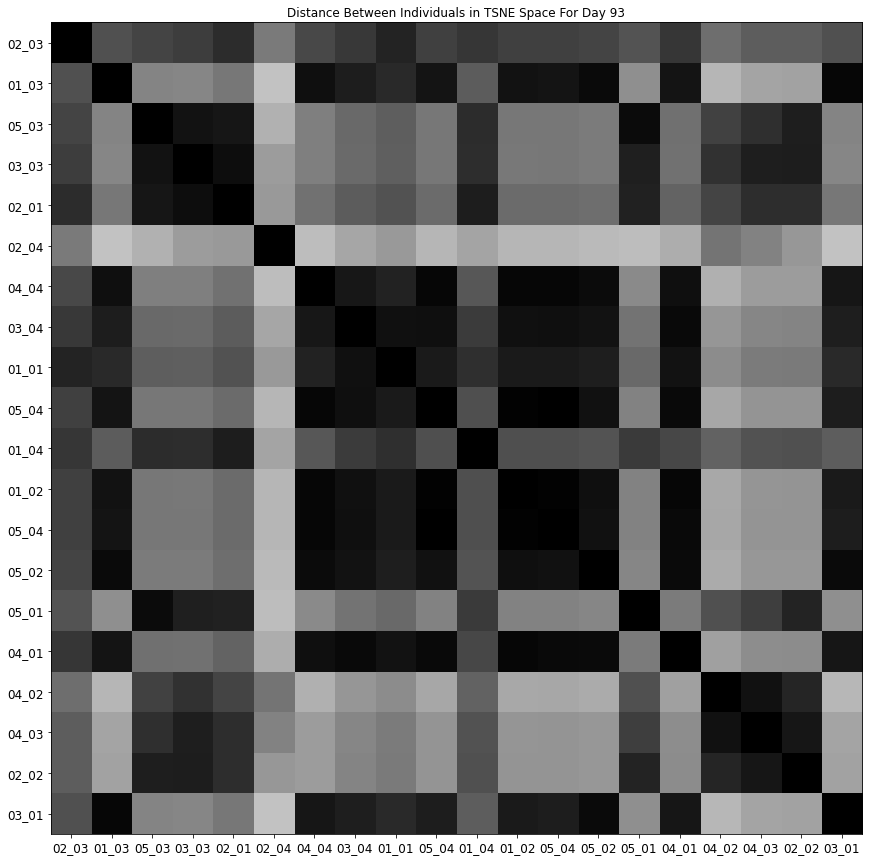

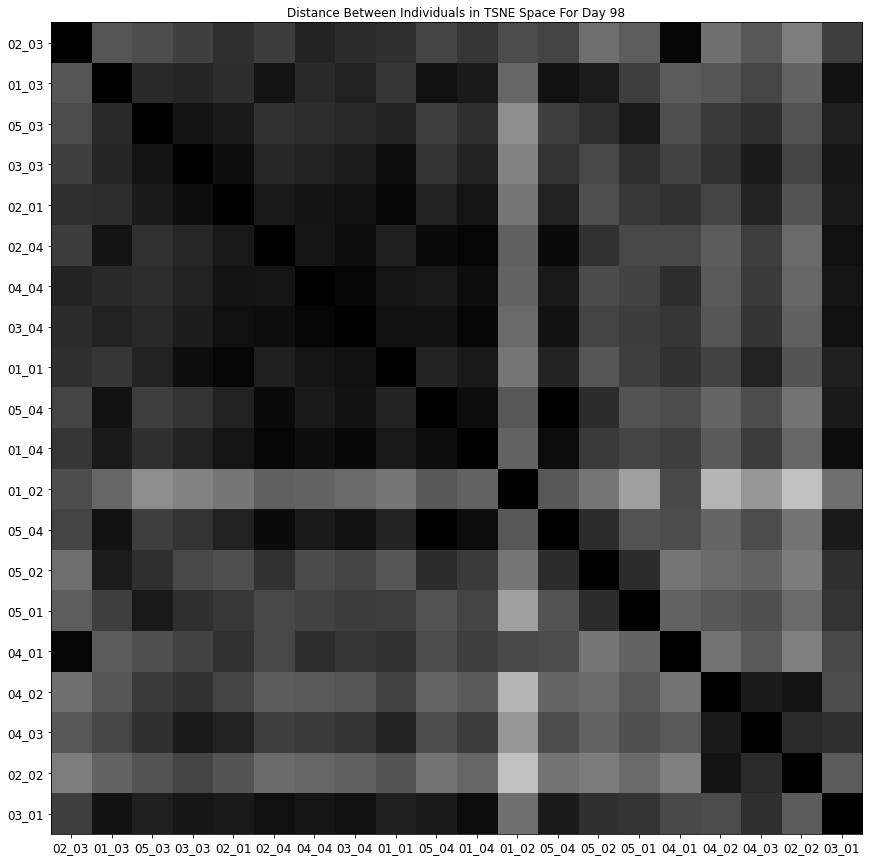

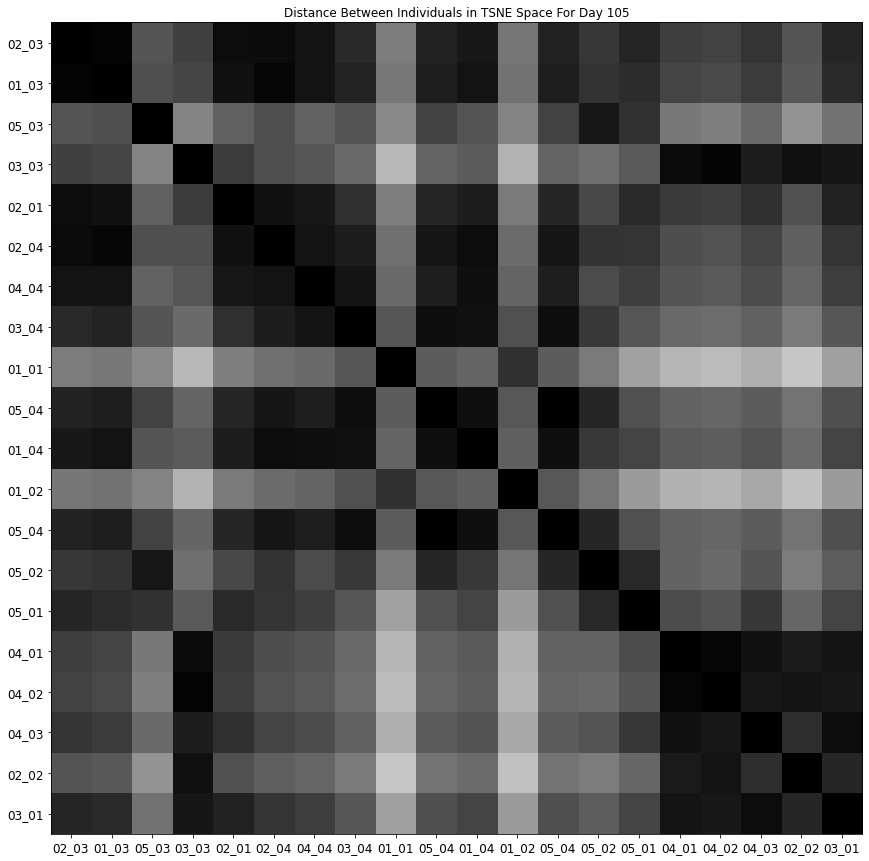

In [183]:
try:
    os.mkdir('female_dbiits_day')
except:
    print('directory already made')

#0,24,25 are good days for females
day=28

#order of best cluster on final day
#at day=25
o=[6,2,18,10,4,7,15,11,0,19,3,1,19,17,16,12,13,14,5,8]

#at day=28 order of the grouped cages by cluster map = o (empriaclly calculated)
o=[10,6,14,17,9,18,15,1,3,0,11,16,19,12,13,5,4,7,2,8]

for day in range(25):
    sort_by_day_x=True



    fig,ax=plt.subplots()
    fig.set_size_inches(12,12)
    fig.patch.set_facecolor('white')
    fig.tight_layout()

    plt.title('Distance Between Individuals in TSNE Space For Day ' + str(female_age_labels_int[day]))

    tsne_dist=np.zeros((len(female_filled_x),len(female_filled_x)))
    for i in range(len(female_filled_x)):
        for j in range(len(female_filled_x)):

            x1=female_filled_x[i][day]
            if math.isnan(x1):

                for k in range(30):
                    try:
                        x1=female_filled_x[i][day+k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass
            if math.isnan(x1):

                for k in range(20):
                    try:
                        x1=female_filled_x[i][day-k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass



            x2=female_filled_x[j][day]
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=female_filled_x[j][day+k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=female_filled_x[j][day-k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass



            y1=female_filled_y[i][day]

            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=female_filled_y[i][day+k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass
            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=female_filled_y[i][day-k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass



            y2=female_filled_y[j][day]
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=female_filled_y[j][day+k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=female_filled_y[j][day-k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass



            try:
                xdiff=x2-x1
                ydiff=y2-y1
                diff=(xdiff**2)**.5 + (ydiff**2)**.5
                tsne_dist[i,j]=diff
            except:
                print('huh')

    ax.set_xticks(np.arange(len(unique_individual_longtogeny_females)))
    ax.set_yticks(np.arange(len(unique_individual_longtogeny_females)))

    if not sort_by_day_x:
        ax.set_xticklabels(list(np.array(unique_individual_longtogeny_females)),fontsize=12)
        ax.set_yticklabels(list(np.array(unique_individual_longtogeny_females)),fontsize=12)

    if sort_by_day_x:
        ax.set_xticklabels(list(np.array(unique_individual_longtogeny_females)[o]),fontsize=12)
        ax.set_yticklabels(list(np.array(unique_individual_longtogeny_females)[o]),fontsize=12)


    if not sort_by_day_x:
        plt.imshow(tsne_dist,cmap='Greys_r',vmax=80)

    if sort_by_day_x:
        plt.imshow(tsne_dist[o][:,o],cmap='Greys_r',vmax=80)
    plt.show()



    #personality_plot=sns.clustermap(tsne_dist,vmax=100,vmin=0)

    if not sort_by_day_x:

        fig.savefig(strain + 'female_tsne_dist_sort_cage_' + str(day) + '.pdf', bbox_inches='tight')
        fig.savefig(strain + 'female_tsne_dist_sort_cage_' + str(day) + '.png', bbox_inches='tight')

    if sort_by_day_x:

        fig.savefig(strain + 'female_tsne_dist_sort_last_day_' + str(day) + '.pdf', bbox_inches='tight')
        fig.savefig(strain + 'female_tsne_dist_sort_last_day_' + str(day) + '.png', bbox_inches='tight')
        fig.savefig("female_dbiits_day/{:04d}.png".format(day),bbox_inches='tight')

!ffmpeg -r 4 -i female_dbiits_day/%04d.png -vb 20M -pix_fmt yuv420p female_tsne_dist_evolution.mp4



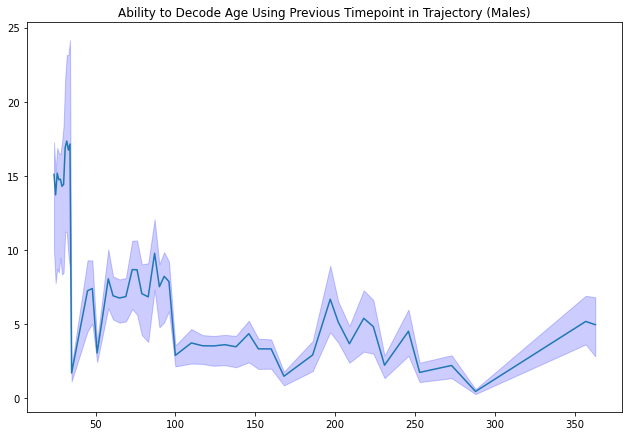

In [290]:
#decodeabillity of males (decoding age using previous time point)

male_tsne_dist_for_each_time_point=[]

day=50

#order of best cluster on final day
#at day=40
o=np.array([6,14,4,13,10,2,7,15,5,12,8,11,1,3,0,9])

#at day=50
o=np.array([4,5,7,2,1,6,13,0,8,15,9,3,11,12,10,14])

for day in range(50):
    sort_by_day_x=True


    tsne_dist=np.zeros((len(male_filled_x),len(male_filled_x)))
    
    for i in range(len(male_filled_x)):
        for j in range(len(male_filled_x)):

            x1=male_filled_x[i][day]
            if math.isnan(x1):

                for k in range(30):
                    try:
                        x1=male_filled_x[i][day+k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass
            if math.isnan(x1):

                for k in range(20):
                    try:
                        x1=male_filled_x[i][day-k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass



            x2=male_filled_x[j][day+1]
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=male_filled_x[j][day+k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=male_filled_x[j][day-k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass



            y1=male_filled_y[i][day]

            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=male_filled_y[i][day+k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass
            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=male_filled_y[i][day-k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass



            y2=male_filled_y[j][day+1]
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=male_filled_y[j][day+k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=male_filled_y[j][day-k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass



            try:
                xdiff=x2-x1
                ydiff=y2-y1
                diff=(xdiff**2)**.5 + (ydiff**2)**.5
                tsne_dist[i,j]=diff
            except:
                print('huh')
    day_length=male_age_labels_int[day+1]-male_age_labels_int[day]            
    male_tsne_dist_for_each_time_point.append(tsne_dist/day_length)

male_each_individuals_decodeability_trajectory=[]

for i in range(len(unique_individual_longtogeny_males)):
    for j in range(len(unique_individual_longtogeny_males)):
        ind_decode_traj=[]
        for n in male_tsne_dist_for_each_time_point:
            ind_decode_traj.append(n[i,j])
        male_each_individuals_decodeability_trajectory.append(ind_decode_traj)

male_mean_age_decodeablity=np.nanmean(male_each_individuals_decodeability_trajectory,axis=0)
male_mean_age_decodeablity_error1=np.percentile(male_each_individuals_decodeability_trajectory,68,axis=0)
male_mean_age_decodeablity_error2=np.percentile(male_each_individuals_decodeability_trajectory,32,axis=0)

fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Ability to Decode Age Using Previous Timepoint in Trajectory (Males)')

plt.plot(male_age_labels_int[0:len(male_age_labels_int)-2],male_mean_age_decodeablity) 
plt.fill_between(male_age_labels_int[0:len(male_age_labels_int)-2],male_mean_age_decodeablity_error1,male_mean_age_decodeablity_error2,alpha=.2,color='blue')
plt.show()

fig.savefig(strain + 'male_age_decodeability_from_tsne.pdf', bbox_inches='tight')
fig.savefig(strain + 'male_age_decodeability_from_tsne.png', bbox_inches='tight')

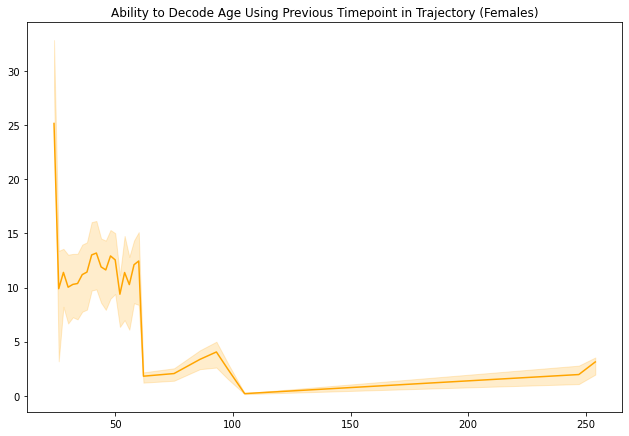

In [291]:
#decodeabillity of males (decoding age using previous time point)

female_tsne_dist_for_each_time_point=[]

day=27

#at day=28 order of the grouped cages by cluster map = o (empriaclly calculated)
o=[10,6,14,17,9,18,15,1,3,0,11,16,19,12,13,5,4,7,2,8]

for day in range(27):
    sort_by_day_x=True


    tsne_dist=np.zeros((len(female_filled_x),len(female_filled_x)))
    
    for i in range(len(female_filled_x)):
        for j in range(len(female_filled_x)):

            x1=female_filled_x[i][day]
            if math.isnan(x1):

                for k in range(30):
                    try:
                        x1=female_filled_x[i][day+k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass
            if math.isnan(x1):

                for k in range(20):
                    try:
                        x1=female_filled_x[i][day-k]
                        if not math.isnan(x1):
                            break
                    except:
                        pass



            x2=female_filled_x[j][day+1]
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=female_filled_x[j][day+k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass
            if math.isnan(x2):

                for k in range(30):
                    try:
                        x2=female_filled_x[j][day-k]
                        if not math.isnan(x2):
                            break
                    except:
                        pass



            y1=female_filled_y[i][day]

            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=female_filled_y[i][day+k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass
            if math.isnan(y1):

                for k in range(30):
                    try:
                        y1=female_filled_y[i][day-k]
                        if not math.isnan(y1):
                            break
                    except:
                        pass



            y2=female_filled_y[j][day+1]
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=female_filled_y[j][day+k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass
            if math.isnan(y2):

                for k in range(30):
                    try:
                        y2=female_filled_y[j][day-k]
                        if not math.isnan(y2):
                            break
                    except:
                        pass



            try:
                xdiff=x2-x1
                ydiff=y2-y1
                diff=(xdiff**2)**.5 + (ydiff**2)**.5
                tsne_dist[i,j]=diff
            except:
                print('huh')
    day_length=female_age_labels_int[day+1]-female_age_labels_int[day]            
    female_tsne_dist_for_each_time_point.append(tsne_dist/day_length)

female_each_individuals_decodeability_trajectory=[]

for i in range(len(unique_individual_longtogeny_females)):
    for j in range(len(unique_individual_longtogeny_females)):
        ind_decode_traj=[]
        for n in female_tsne_dist_for_each_time_point:
            ind_decode_traj.append(n[i,j])
        female_each_individuals_decodeability_trajectory.append(ind_decode_traj)

female_mean_age_decodeablity=np.nanmean(female_each_individuals_decodeability_trajectory,axis=0)
female_mean_age_decodeablity_error1=np.percentile(female_each_individuals_decodeability_trajectory,68,axis=0)
female_mean_age_decodeablity_error2=np.percentile(female_each_individuals_decodeability_trajectory,32,axis=0)

fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Ability to Decode Age Using Previous Timepoint in Trajectory (Females)')

plt.plot(female_age_labels_int[0:len(female_age_labels_int)-2],female_mean_age_decodeablity,color='orange') 
plt.fill_between(female_age_labels_int[0:len(female_age_labels_int)-2],female_mean_age_decodeablity_error1,female_mean_age_decodeablity_error2,alpha=.2,color='orange')
plt.show()

fig.savefig(strain + 'female_age_decodeability_from_tsne.pdf', bbox_inches='tight')
fig.savefig(strain + 'female_age_decodeability_from_tsne.png', bbox_inches='tight')

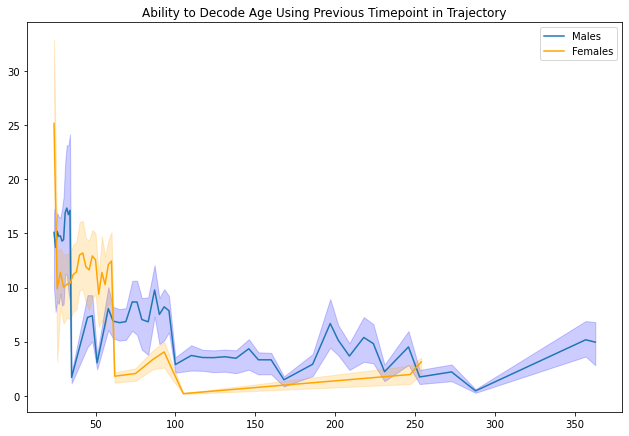

In [293]:
fig,ax=plt.subplots()
fig.set_size_inches(9,6)
fig.patch.set_facecolor('white')
fig.tight_layout()

plt.title('Ability to Decode Age Using Previous Timepoint in Trajectory')

plt.plot(male_age_labels_int[0:len(male_age_labels_int)-2],male_mean_age_decodeablity) 
plt.plot(female_age_labels_int[0:len(female_age_labels_int)-2],female_mean_age_decodeablity,color='orange') 
plt.legend(['Males','Females'],loc='upper right')

plt.fill_between(male_age_labels_int[0:len(male_age_labels_int)-2],male_mean_age_decodeablity_error1,male_mean_age_decodeablity_error2,alpha=.2,color='blue')
plt.fill_between(female_age_labels_int[0:len(female_age_labels_int)-2],female_mean_age_decodeablity_error1,female_mean_age_decodeablity_error2,alpha=.2,color='orange')

plt.show()

fig.savefig(strain + 'male_and_female_age_decodeability_from_tsne.pdf', bbox_inches='tight')
fig.savefig(strain + 'male_and_female_age_decodeability_from_tsne.png', bbox_inches='tight')

In [304]:
y=[.98,.65,.0625]
yerr=[.01,.11,.015625]

In [305]:
1/16

0.0625

In [306]:
.0625/4

0.015625

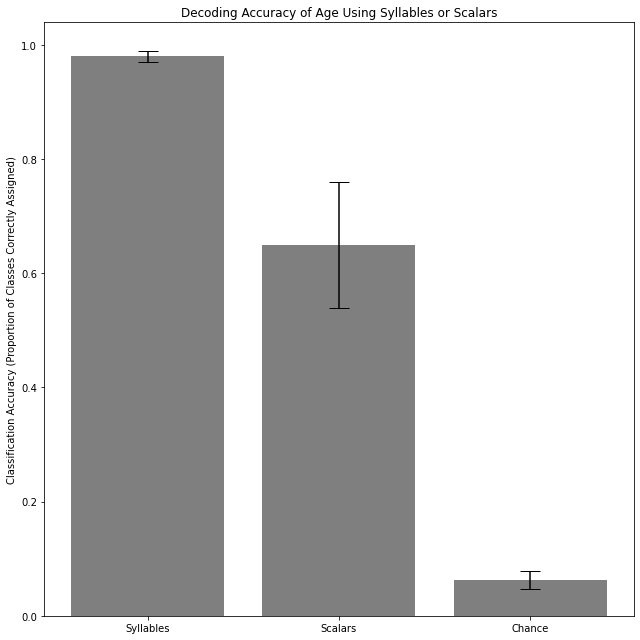

In [314]:
# Build the plot
fig, ax = plt.subplots()
fig.set_size_inches(9,9)
plt.bar(['Syllables','Scalars','Chance'], y, yerr=yerr, align='center', color='black',alpha=0.5, ecolor='black', capsize=10)
ax.set_ylabel('Classification Accuracy (Proportion of Classes Correctly Assigned)')

ax.set_title('Decoding Accuracy of Age Using Syllables or Scalars')

# Save the figure and show
plt.tight_layout()
plt.show()

fig.savefig(strain + 'ontogeny_decodeability_of_age_from_syllables_or_scalrs.pdf', bbox_inches='tight')
fig.savefig(strain + 'ontogeny_decodeability_of_age_from_syllables_or_scalrs.png', bbox_inches='tight')